# GFI/LFI BAR PLOT TESTS 

Try to redo the tests on all the real-world datasets to obtain the bar plots but with a different approach than the one used up to now. 

1. Train the model on the entire dataset under analysis (for example the wine.mat or annthyroid.mat (maybe annthyroid is better because it has just 6 features so it's faster to train and test))

2. Compute the Anomaly Score for all the training samples and divide them into outliers and inliers. Use the assumption that 10% of the data are outliers. We do not know in advance the correct outlier percentage but usually 10% is a good guess. I can also try with other percentages (e.g. 5%, 15%) if there is time. 

3. Finally the GFI and LFI Bar Plots should be computed only on the outliers. In fact at the end we care about the most important features to identify anomalies and at test time we look at the importance scores just when an anomaly is detected. 

N.B For what concerns the Synthetic datasets to obtain reasonable results we have to train the model and run the plt_global_importance_bars function on the entire dataset, so the concatenation of X_train and X_xaxis,X_yaxis,... The test sets like X_xaxis,X_yaxis,... can be used alone just for the Local Importances. 

# GFI/LFI BAR PLOT AND FEATURE IMPORTANCE SCORE PLOT


In [8]:
import sys
import numpy as np
from datetime import datetime
import pandas as pd
import argparse
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
sys.path.append('../')
from utils import *
#from utils.feature_selection import *
from plot import *
from simulation_setup import *
from models import *
from models.Extended_IF import *
from models.Extended_DIFFI import *
from models.Extended_DIFFI_original import *
import math
import seaborn as sns
sns.set()

import os
import pickle 
import scipy.io

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
os.chdir('../')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI'

In [9]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data'

## Generate Synthetic Data

In [3]:
def generate_cartesian_points(size,n_col,contamination_factor):
    n_outliers=int(np.round(size*contamination_factor))
    n_inliers=size+n_outliers
    # Inliers
    theta_in=np.random.uniform(0,2*math.pi,size=n_inliers)
    rho_in=np.random.uniform(0,3,size=n_inliers)

    # Outliers
    theta_out=np.random.uniform(0,2*math.pi,size=n_outliers)
    rho_out=np.random.uniform(4,30,size=n_outliers)

    inliers=np.column_stack((rho_in*np.cos(theta_in),rho_in*np.sin(theta_in)))
    outliers=np.column_stack((rho_out*np.cos(theta_out),rho_out*np.sin(theta_out)))

    #White samples noisy features

    noise_inliers=np.random.normal(0,1,size=(n_inliers,n_col))
    noise_outliers=np.random.normal(0,1,size=(n_outliers,n_col))

    inliers=np.column_stack((inliers,noise_inliers))
    y_inlier=np.zeros(shape=inliers.shape[0])
    outliers=np.column_stack((outliers,noise_outliers))
    y_outlier=np.ones(shape=outliers.shape[0])

    #data=np.row_stack((inliers,outliers))
    #y=np.concatenate((y_inlier,y_outlier))

    return inliers,y_inlier,outliers,y_outlier

In [5]:
X_train,y_train,X_test,y_test=generate_cartesian_points(900,4,0.055)
X_train.shape,y_train.shape

((950, 6), (950,))

In [7]:
X_train=np.r_[X_train,X_test]
X_train.shape

(1000, 6)

### Load data from pkl files 

#### Train 

In [3]:
file_to_read = open(os.getcwd()+'\\syn_train.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train,y_train= loaded_dictionary['X'],loaded_dictionary['y']

In [4]:
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train=loaded_dictionary['X_train']

In [18]:
file_to_read = open(os.getcwd()+'\\syn_train_100.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train,y_train= loaded_dictionary['X_train'],loaded_dictionary['y_train']

N.B -> Main difference. The central circle withe all the inliers is centered in the origin and with radius 1 in X_train_mine (in fact the x and y coordinates are in [-1,1]), while it has radius equal to 3 in X_train (here the coordinates are in fact in [-3,3])

#### Test 

In [5]:
file_to_read = open(os.getcwd()+'\\anomalies.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_xaxis,X_yaxis,X_bisect,X_bisect_3d,X_bisect_6d=loaded_dictionary['X_xaxis'],loaded_dictionary['X_yaxis'],loaded_dictionary['X_bisec'],loaded_dictionary['X_bisec_3d'],loaded_dictionary['X_bisec_6d']

In [4]:
file_to_read = open(os.getcwd()+'\\syn_test_anomaly_interval.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_xaxis,X_yaxis,X_bisec = loaded_dictionary['X_xaxis'],loaded_dictionary['X_yaxis'],loaded_dictionary['X_bisect']

In [5]:
file_to_read = open(os.getcwd()+'\\syn_test_multi_dim_anomaly_interval.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_bisect_3d,X_bisect_4d,X_bisect_6d = loaded_dictionary['X_bisect_3d'],loaded_dictionary['X_bisect_4d'],loaded_dictionary['X_bisect_6d']

In [6]:
file_to_read = open(os.getcwd()+'\\syn_test_100_multi_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_bisec_3d,X_bisec_4d,X_bisec_6d = loaded_dictionary['X_bisec_3d'],loaded_dictionary['X_bisec_4d'],loaded_dictionary['X_bisec_6d']

#### Toy Datasets 

In [10]:
file_to_read = open(os.getcwd()+'\\toy_datasets.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_toy_2d,X_toy_3d,X_toy_4d,X_toy_6d,y = loaded_dictionary['X_toy_2d'],loaded_dictionary['X_toy_3d'],loaded_dictionary['X_toy_4d'],loaded_dictionary['X_toy_6d'],loaded_dictionary['y']

In [11]:
X_toy_2d=X_toy_2d[:,:2]
X_toy_2d.shape

(400, 2)

I have to create syn_test_50_multi_dim

In [8]:
file_to_read = open(os.getcwd()+'\\syn_test_50_multi_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_bisec_3d,X_bisec_4d,X_bisec_6d = loaded_dictionary['X_bisec_3d'],loaded_dictionary['X_bisec_4d'],loaded_dictionary['X_bisec_6d']

In '\\results\\compare_features\\results\\Importances_dict\\' we have a dictionary with the GFI vectors for 10 executions for ExIFFI and DIFFI. With the importances contained in these files the Bar Plot are working as expected. 

Now we compute the LFI and GFI on all the synthetic datasets using the original version of Ex-IFFI. 

## Create the model 

Let's try to create the ExIFFI model as it was created in synt_global_bars_copy.ipynb

In [17]:
def partition_data(X,y):
    inliers=X[y==0,:]
    outliers=X[y==1,:]
    return inliers,outliers

In [18]:
X_train,X_test=partition_data(X_toy_2d,y)
X_train.shape,X_test.shape

((390, 2), (10, 2))

In [119]:
N = X_train.shape[0]
dim = X_train.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10

In [120]:
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size,plus=1)
EDIFFI.fit(X_train)

In [121]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI'

# Plot Functions

In [12]:
def plt_importances_bars(importances, name, pwd, dim, f = 6):
    
    if 'GFI_' not in name:
        name='LFI_'+name

    
    number_colours = 20
    color = plt.cm.get_cmap('tab20',number_colours).colors
    patterns = [None, "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]

    importances_matrix = np.array([np.array(pd.Series(x).sort_values(ascending = False).index).T for x in importances])
    bars = [[(list(importances_matrix[:,j]).count(i)/len(importances_matrix))*100 for i in range(dim)] for j in range(dim)]
    
    bars = pd.DataFrame(bars)
    display(bars)

    tick_names=[]
    for i in range(1,f+1):
        if i==1:
            tick_names.append(r'${}'.format(i) + r'^{st}$')
        elif i==2:
            tick_names.append(r'${}'.format(i) + r'^{nd}$')
        elif i==3:
            tick_names.append(r'${}'.format(i) + r'^{rd}$')
        else:
            tick_names.append(r'${}'.format(i) + r'^{th}$')

    barWidth = 0.85
    r=range(dim)
 
    for i in range(dim):
        plt.bar(r[:f], bars.T.iloc[i,:f].values, bottom=bars.T.iloc[:i,:f].sum().values ,color=color[i%number_colours], edgecolor='white', width=barWidth, label=str(i), hatch=patterns[i//number_colours])


    plt.xlabel("Rank", fontsize = 20)
    #plt.xticks(range(f),[r'$1^{st}$', r'$2^{nd}$', r'$3^{rd}$', r'$4^{th}$', r'$5^{th}$', r'$6^{th}$', r'$7^{th}$', r'$8^{th}$', r'$9^{th}$'][:f])
    plt.xticks(range(f),tick_names[:f])
    plt.ylabel("Percentage count", fontsize = 20)
    plt.yticks(range(10,101,10),[str(x)+"%" for x in range(10,101,10)])
    #plt.title("synthetic {} anomalies E-diffi \n percentage count of feature ranking".format(name,f), fontsize = 18)
    plt.legend(bbox_to_anchor = (1.05,0.95),loc="upper left")
    #plt.savefig(pwd+'/results_local_diffi/images/'+name+'.pdf',bbox_inches = "tight")
    #current_time=datetime.now()
    #tm=[current_time.day,current_time.month,current_time.year,
    #current_time.hour,current_time.minute,current_time.second]
    plt.savefig(pwd+'//results//davide/{}_synt.pdf'
                .format(name),bbox_inches='tight')
    plt.show()

In [13]:
def plt_global_importance_bars(model,X_train,X_test,n_runs,name,pwd,dim,f=6):

    name='GFI_'+name

    #X_test=np.r_[X_train,X_test]

    imps=np.zeros(shape=(n_runs,X_train.shape[1]))
    for i in tqdm(range(n_runs)):
        model.fit(X_train)
        imps[i,:]=model.Global_importance(X_test,calculate=True,sovrascrivi=False,depth_based=False)

    #Take the mean feature importance scores over the different runs for the Feature Importance Plot
    #and put it in decreasing order of importance
    mean_imp=np.mean(imps,axis=0)
    std_imp=np.std(imps,axis=0)
    mean_imp_val=np.sort(mean_imp)
    feat_order=mean_imp.argsort()

    plt_data={'Importances': mean_imp_val,
              'feat_order': feat_order,
              'std': std_imp[mean_imp.argsort()]}

    plt_importances_bars(imps,name,pwd,dim,f)
    plt_feat_bar_plot(plt_data,X,name,pwd,f)

In [14]:
def compute_imps(model,X_train,X_test,n_runs,name,pwd,dim,f=6):

    name='GFI_'+name

    #X_test=np.r_[X_train,X_test]

    imps=np.zeros(shape=(n_runs,X_train.shape[1]))
    for i in tqdm(range(n_runs)):
        model.fit(X_train)
        imps[i,:]=model.Global_importance(X_test,calculate=True,sovrascrivi=False,depth_based=False)

    path = pwd + '\\results\\davide\\Importance_Scores\\Imp Score\\imp_score_' + name + '.pkl'
    with open(path, 'wb') as fl:
        pickle.dump(imps,fl)

    #Take the mean feature importance scores over the different runs for the Feature Importance Plot
    #and put it in decreasing order of importance
    mean_imp=np.mean(imps,axis=0)
    std_imp=np.std(imps,axis=0)
    mean_imp_val=np.sort(mean_imp)
    feat_order=mean_imp.argsort()

    plt_data={'Importances': mean_imp_val,
              'feat_order': feat_order,
              'std': std_imp[mean_imp.argsort()]}

    path = pwd + '\\results\\davide\\Importance_Scores\\Plt Data\\plt_data_' + name + '.pkl'
    with open(path, 'wb') as fl:
        pickle.dump(plt_data,fl)

    return imps,plt_data
    

In [21]:
def plt_feat_bar_plot(global_importances,X,name,pwd,f=6,save=True):
    
    name_file='Feat_bar_plot_'+name 
    patterns = [None, "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]

    imp_vals=global_importances['Importances']

    feat_imp=pd.DataFrame({'Global Importance': np.round(imp_vals,3),
                          'Feature': global_importances['feat_order'],
                          'std': global_importances['std']
                          })

    if len(feat_imp)>15:
        feat_imp=feat_imp.iloc[-15:].reset_index(drop=True)
    
    dim=feat_imp.shape[0]

    number_colours = 20

    plt.style.use('default')
    plt.rcParams['axes.facecolor'] = '#F2F2F2'
    plt.rcParams['axes.axisbelow'] = True
    #plt.grid(alpha = 0.7)
    color = plt.cm.get_cmap('tab20',number_colours).colors
    ax1=feat_imp.plot(y='Global Importance',x='Feature',kind="barh",color=color[feat_imp['Feature']%number_colours],xerr='std',
                     capsize=5, alpha=1,legend=False,
                     hatch=[patterns[i//number_colours] for i in feat_imp['Feature']])

    barWidth=0.85

    xlim=np.min(imp_vals)-0.2*np.min(imp_vals)

    text_x=np.max(feat_imp['Global Importance'] + feat_imp['std'])*1.1

    ax1.grid(alpha=0.7)
    ax2 = ax1.twinx()
    # Add labels on the right side of the bars
    values=[]
    for i, v in enumerate(feat_imp['Global Importance']):
        #ax2.text(v + 1, i, str(v) + ' +- ' + str(np.round(feat_imp['std'][i],2)), color='blue', va='center')
        values.append(str(v) + ' +- ' + str(np.round(feat_imp['std'][i],2)))
    
    #print(values)
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_yticks(range(dim))
    ax2.set_yticklabels(values)
    ax2.grid(alpha=0)

    #for i, v in enumerate(feat_imp['Global Importance']):
        #ax.text(text_x,i-0.2,str(v)+' +- ' + str(np.round(feat_imp['std'][i],2)), ha='center', va='bottom')

    plt.axvline(x=0, color=".5")
    ax1.set_xlabel('Importance Score',fontsize=20)
    ax1.set_ylabel('Features',fontsize=20)
    plt.xlim(xlim)
    #plt.yticks(range(dim),feat_imp['Feature'])
    plt.subplots_adjust(left=0.3)
    if save:
        plt.savefig(pwd+'//results//davide/{}.pdf'.format(name_file),bbox_inches='tight')
        
    plt.show()


# AUTOMATIC PLOT FUNCTIONS 

In [15]:
def interpretation_plots(name,pwd):

    os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
    if name=='diabetes' or name=='moodify':
        X,y=csv_dataset(name,os.getcwd()+'\\')
    else:
        X,y=dataset(name,os.getcwd()+'\\')

    X,y=downsample(X,y)
    X_train,X_test=partition_data(X,y)
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    y_train=np.zeros(X_train.shape[0])
    y_test=np.ones(X_test.shape[0])
    y=np.concatenate([y_train,y_test])
    X_test=np.r_[X_train,X_test]
    scaler2=StandardScaler()
    X=scaler2.fit_transform(X)
    EDIFFI=Extended_DIFFI_original(300,max_depth=100,subsample_size=256,plus=1)
    dim=X.shape[1]

    # No Split 

    imps,plt_data=compute_imps(EDIFFI,X,X,10,name,pwd,dim,f=6)

    path = pwd + '\\results\\davide\\Importance_Scores\\Imp Score\\imp_score_GFI_' + name + '.pkl'
    with open(path, 'rb') as fl:
        imps = pickle.load(fl)

    path = pwd + '\\results\\davide\\Importance_Scores\\Plt Data\\plt_data_GFI_' + name + '.pkl'
    with open(path, 'rb') as fl:
        plt_data = pickle.load(fl)

    plt_importances_bars(imps,name,pwd,dim)
    plt_feat_bar_plot(plt_data,X,name,pwd)
    

    #Split
    name1=name+'_split'
    imps,plt_data=compute_imps(EDIFFI,X_train,X_test,10,name1,pwd,dim)
    plt_importances_bars(imps,name1,pwd,dim)
    plt_feat_bar_plot(plt_data,X,name1,pwd)


breastw 

[numero elementi = 449]
[percentage outliers = 0.5256124721603563]
[number features = 9]
[number outliers = 236]


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [09:27<00:00, 56.75s/it]


0     1     2     3     4     5     6     7      8
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  100.0
1   0.0   0.0   0.0   0.0  90.0   0.0  10.0   0.0    0.0
2   0.0  30.0   0.0  20.0   0.0  20.0  20.0  10.0    0.0
3   0.0   0.0  50.0   0.0  10.0  20.0  20.0   0.0    0.0
4  20.0  30.0  20.0  10.0   0.0   0.0  20.0   0.0    0.0
5  20.0  30.0  10.0   0.0   0.0  20.0   0.0  20.0    0.0
6   0.0   0.0   0.0  50.0   0.0  20.0  10.0  20.0    0.0
7  30.0  10.0  10.0  10.0   0.0  20.0  10.0  10.0    0.0
8  30.0   0.0  10.0  10.0   0.0   0.0  10.0  40.0    0.0

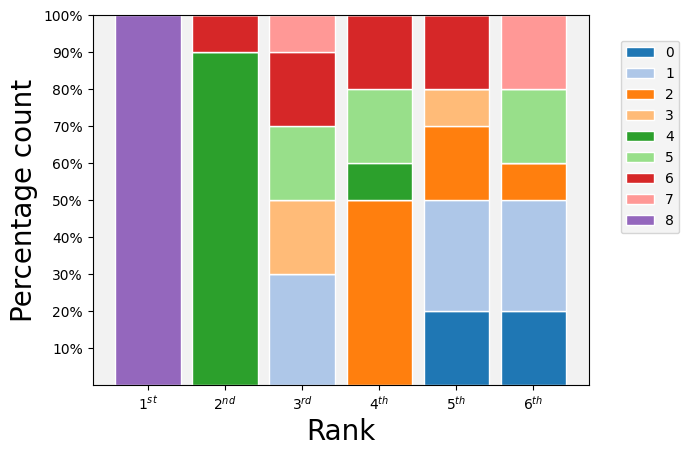

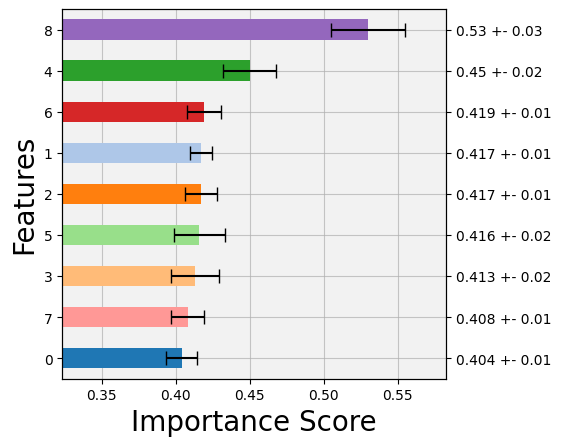

100%|██████████| 10/10 [06:18<00:00, 37.85s/it]


0     1     2     3     4     5     6     7     8
0   0.0   0.0  10.0   0.0   0.0   0.0   0.0   0.0  90.0
1   0.0   0.0  30.0  10.0  10.0   0.0  20.0  20.0  10.0
2  10.0  30.0   0.0  20.0   0.0   0.0  40.0   0.0   0.0
3  10.0  10.0  40.0  20.0  20.0   0.0   0.0   0.0   0.0
4  40.0   0.0   0.0  20.0  10.0   0.0  20.0  10.0   0.0
5  20.0  20.0  10.0  10.0  20.0   0.0  10.0  10.0   0.0
6  10.0   0.0   0.0   0.0  30.0  20.0  10.0  30.0   0.0
7  10.0  20.0  10.0  10.0  10.0  20.0   0.0  20.0   0.0
8   0.0  20.0   0.0  10.0   0.0  60.0   0.0  10.0   0.0

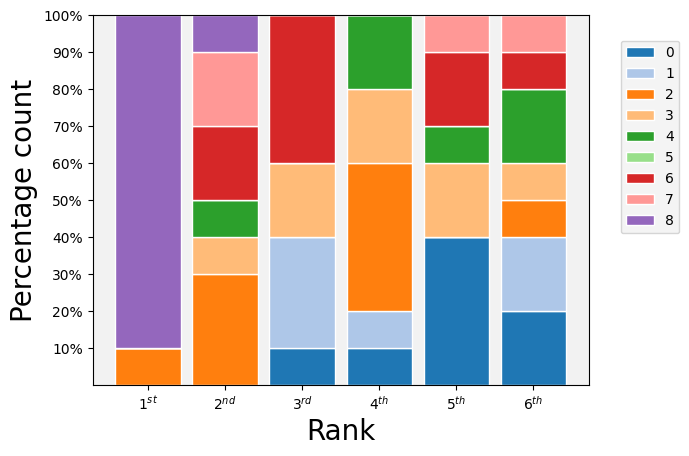

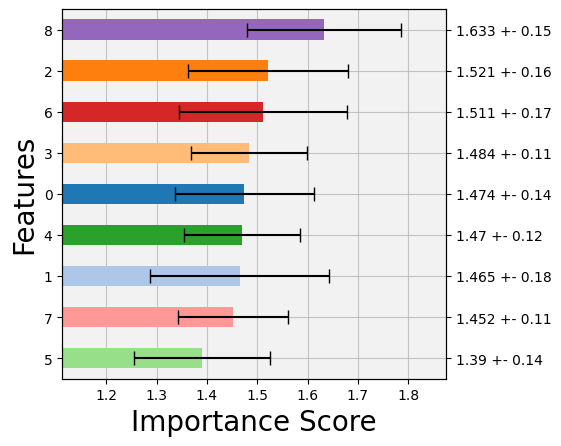

In [9]:
pwd='c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI'

interpretation_plots('breastw',pwd)

# GFI/LFI BAR PLOTS FOR SYNTHETIC DATASETS

In [9]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')

In [10]:
pwd = os.getcwd()
dim = X_train.shape[1]

# AUTOMATIC PLOT FUNCTION SYNTHETIC DATASETS

In [16]:
def interpretation_plots_synt(name,X_train,X_test,pwd):

    X=np.r_[X_train,X_test]
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    y_train=np.zeros(X_train.shape[0])
    y_test=np.ones(X_test.shape[0])
    y=np.concatenate([y_train,y_test])
    X_test=np.r_[X_train,X_test]
    scaler2=StandardScaler()
    X=scaler2.fit_transform(X)
    EDIFFI=Extended_DIFFI_original(300,max_depth=100,subsample_size=256,plus=1)
    dim=X.shape[1]

    # No Split 
    imps,plt_data=compute_imps(EDIFFI,X_test,X_test,10,name,pwd,dim,f=6)

    path = pwd + '\\results\\davide\\Importance_Scores\\Imp Score\\imp_score_GFI_' + name + '.pkl'
    with open(path, 'rb') as fl:
        imps = pickle.load(fl)

    path = pwd + '\\results\\davide\\Importance_Scores\\Plt Data\\plt_data_GFI_' + name + '.pkl'
    with open(path, 'rb') as fl:
        plt_data = pickle.load(fl)

    plt_importances_bars(imps,name,pwd,dim)
    plt_feat_bar_plot(plt_data,X,name,pwd)

    #Split
    name1=name+'_split'
    imps,plt_data=compute_imps(EDIFFI,X_train,X_test,10,name1,pwd,dim)
    plt_importances_bars(imps,name1,pwd,dim)
    plt_feat_bar_plot(plt_data,X,name1,pwd)


In [12]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train=loaded_dictionary['X_train']

In [19]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
pwd=os.getcwd()

## Bimodal 

100%|██████████| 10/10 [13:29<00:00, 81.00s/it]


0     1
0  20.0  80.0
1  80.0  20.0

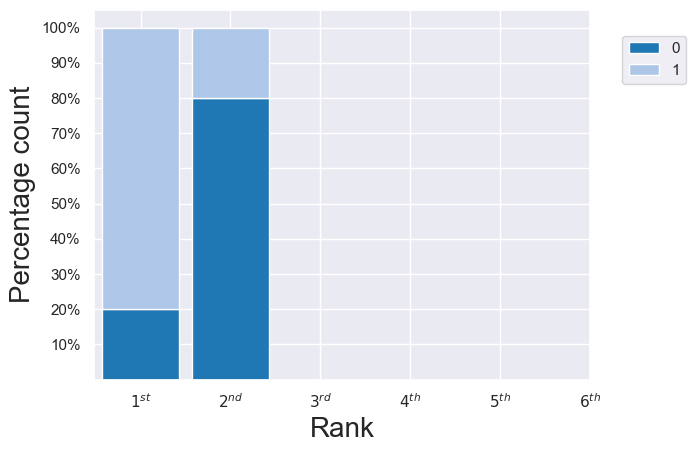

NameError: name 'plt_feat_bar_plot' is not defined

In [20]:
interpretation_plots_synt('bimodal',X_train,X_test,pwd)

## Xaxis

100%|██████████| 10/10 [18:36<00:00, 111.61s/it]


0     1     2     3     4     5
0  100.0   0.0   0.0   0.0   0.0   0.0
1    0.0  20.0  30.0  30.0  10.0  10.0
2    0.0  20.0  30.0  20.0  30.0   0.0
3    0.0  40.0  20.0  20.0  10.0  10.0
4    0.0  10.0  10.0  10.0  40.0  30.0
5    0.0  10.0  10.0  20.0  10.0  50.0

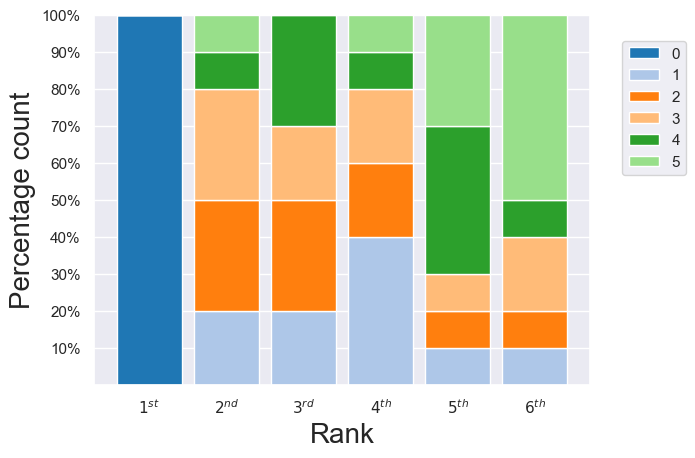

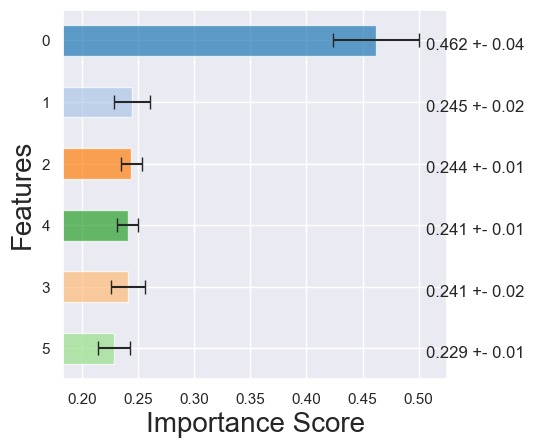

100%|██████████| 10/10 [18:50<00:00, 113.02s/it]


0     1     2     3     4     5
0  100.0   0.0   0.0   0.0   0.0   0.0
1    0.0  10.0  30.0  20.0   0.0  40.0
2    0.0  10.0  10.0  40.0  30.0  10.0
3    0.0   0.0  20.0   0.0  50.0  30.0
4    0.0  20.0  40.0  10.0  20.0  10.0
5    0.0  60.0   0.0  30.0   0.0  10.0

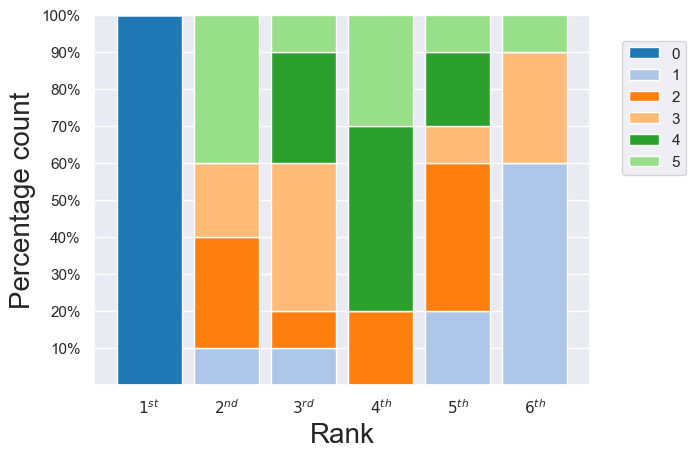

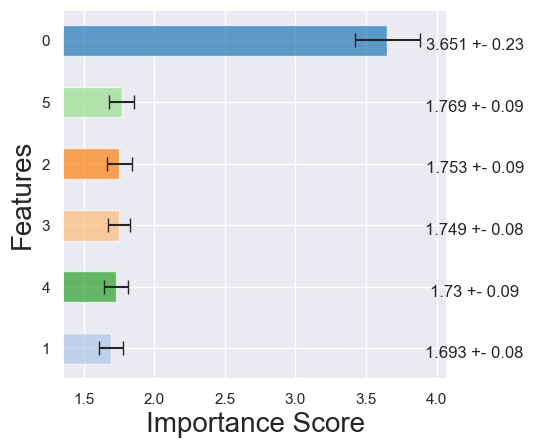

In [21]:
interpretation_plots_synt('Xaxis',X_train,X_xaxis,pwd)

## Yaxis

100%|██████████| 10/10 [17:38<00:00, 105.89s/it]


0      1     2     3     4     5
0   0.0  100.0   0.0   0.0   0.0   0.0
1   0.0    0.0  30.0  10.0  30.0  30.0
2  20.0    0.0  40.0  10.0  20.0  10.0
3  30.0    0.0   0.0  40.0  10.0  20.0
4  30.0    0.0  20.0  30.0  20.0   0.0
5  20.0    0.0  10.0  10.0  20.0  40.0

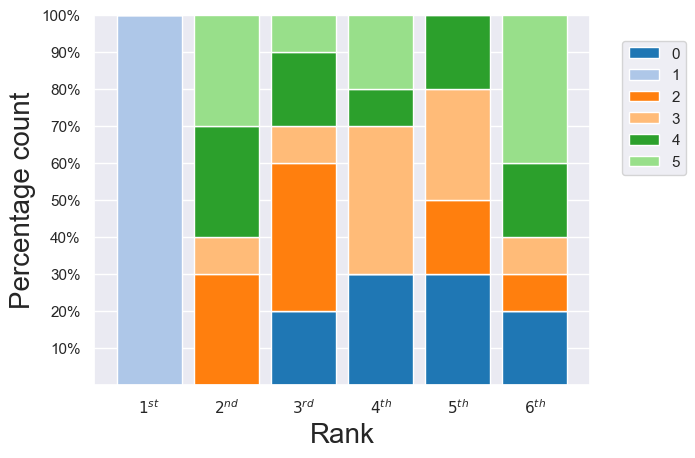

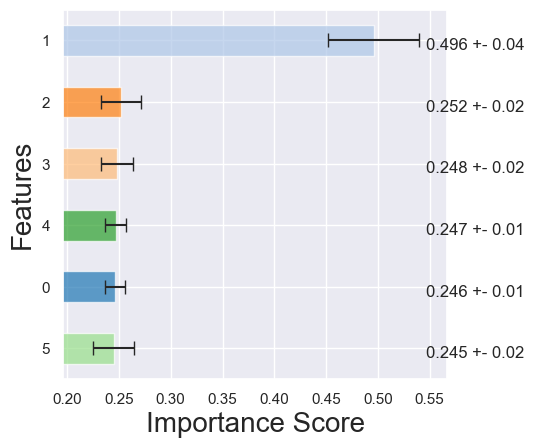

100%|██████████| 10/10 [19:11<00:00, 115.14s/it]


0      1     2     3     4     5
0   0.0  100.0   0.0   0.0   0.0   0.0
1  40.0    0.0  20.0  20.0  10.0  10.0
2  10.0    0.0  40.0   0.0  20.0  30.0
3  20.0    0.0  10.0  50.0  10.0  10.0
4  10.0    0.0  30.0  10.0  40.0  10.0
5  20.0    0.0   0.0  20.0  20.0  40.0

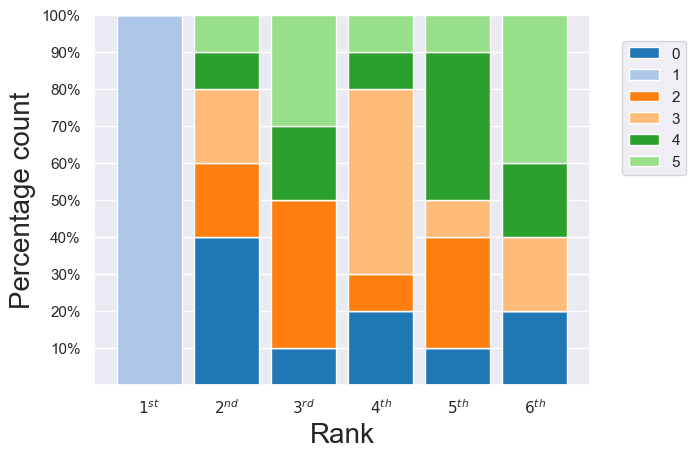

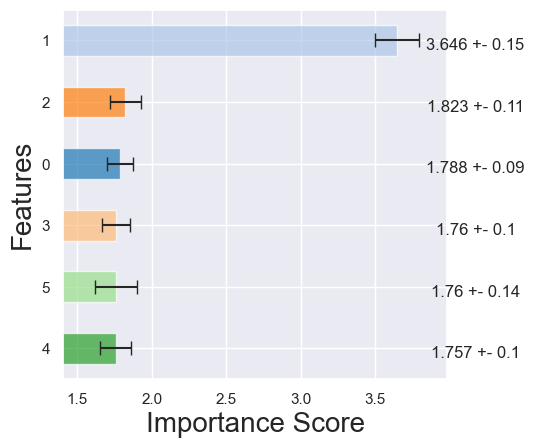

In [22]:
interpretation_plots_synt('Yaxis',X_train,X_yaxis,pwd)

# Bisect

100%|██████████| 10/10 [13:45<00:00, 82.55s/it]


0     1     2     3     4     5
0  20.0  80.0   0.0   0.0   0.0   0.0
1  80.0  20.0   0.0   0.0   0.0   0.0
2   0.0   0.0  70.0  20.0  10.0   0.0
3   0.0   0.0  20.0  30.0  40.0  10.0
4   0.0   0.0  10.0  20.0  30.0  40.0
5   0.0   0.0   0.0  30.0  20.0  50.0

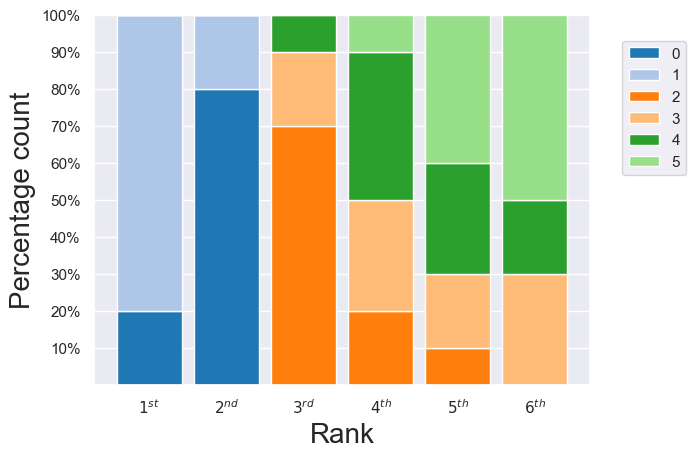

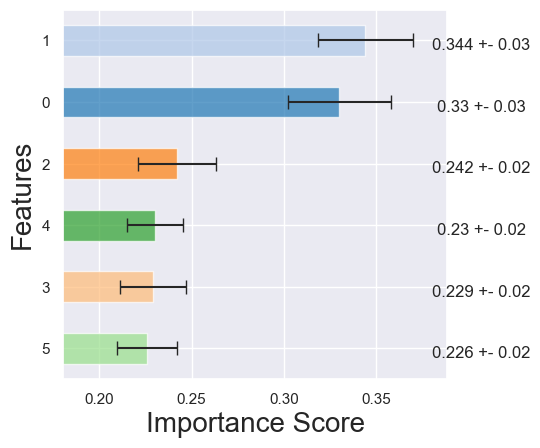

100%|██████████| 10/10 [13:10<00:00, 79.08s/it]


0     1     2     3     4     5
0  50.0  50.0   0.0   0.0   0.0   0.0
1  50.0  50.0   0.0   0.0   0.0   0.0
2   0.0   0.0  20.0  40.0  20.0  20.0
3   0.0   0.0  30.0  20.0  40.0  10.0
4   0.0   0.0  20.0  30.0  10.0  40.0
5   0.0   0.0  30.0  10.0  30.0  30.0

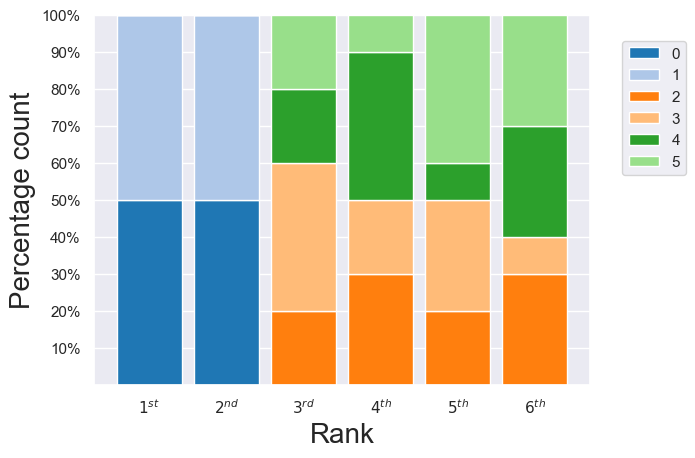

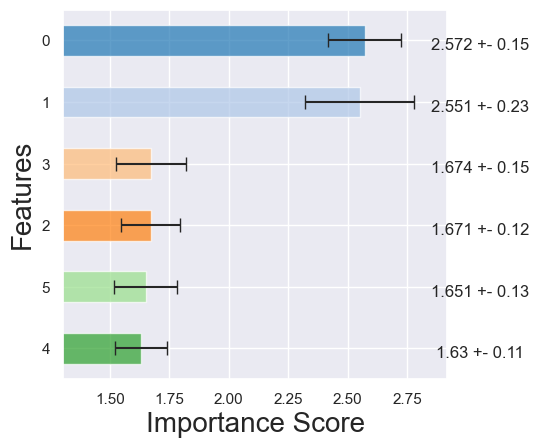

In [14]:
interpretation_plots_synt('Bisect',X_train,X_bisect,pwd)

# Bisect 3d

100%|██████████| 10/10 [16:01<00:00, 96.10s/it] 


0     1     2     3     4     5
0  20.0  30.0  50.0   0.0   0.0   0.0
1  10.0  50.0  40.0   0.0   0.0   0.0
2  70.0  20.0  10.0   0.0   0.0   0.0
3   0.0   0.0   0.0  40.0  30.0  30.0
4   0.0   0.0   0.0  30.0  50.0  20.0
5   0.0   0.0   0.0  30.0  20.0  50.0

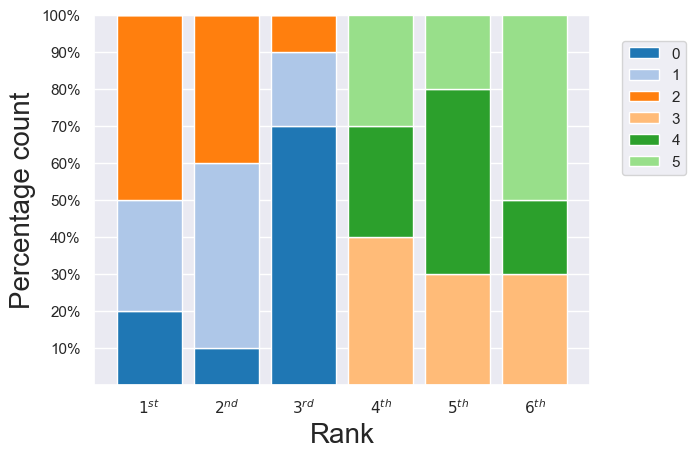

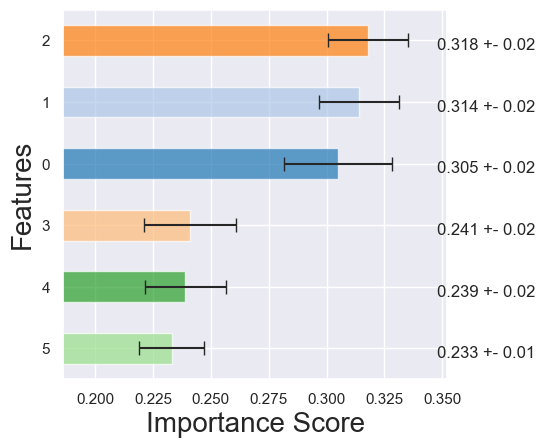

100%|██████████| 10/10 [19:18<00:00, 115.84s/it]


0     1     2     3     4     5
0  10.0  30.0  60.0   0.0   0.0   0.0
1  40.0  40.0  20.0   0.0   0.0   0.0
2  50.0  30.0  20.0   0.0   0.0   0.0
3   0.0   0.0   0.0  30.0  30.0  40.0
4   0.0   0.0   0.0  10.0  50.0  40.0
5   0.0   0.0   0.0  60.0  20.0  20.0

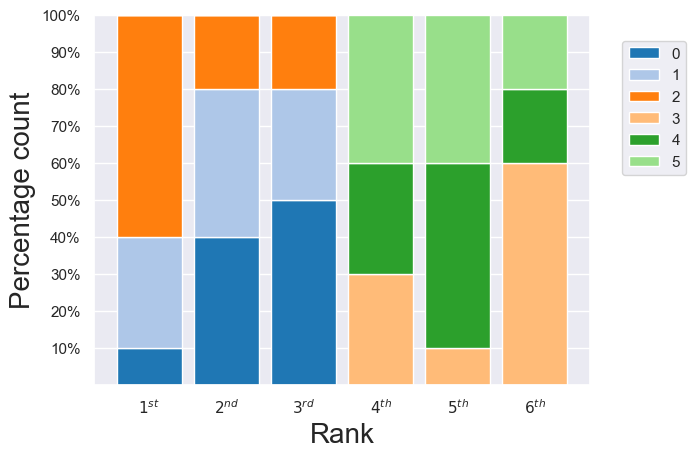

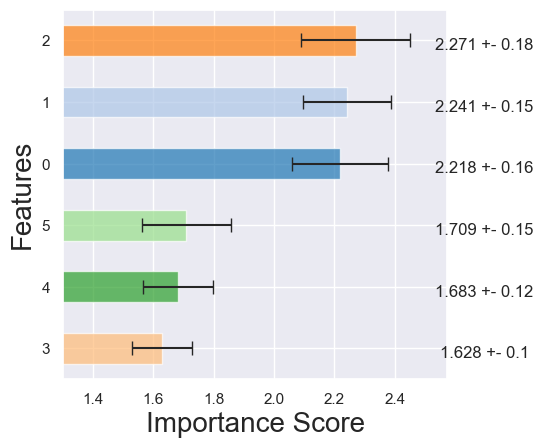

In [15]:
interpretation_plots_synt('Bisect_3d',X_train,X_bisect_3d,pwd)

# Bisect 6d

0     1     2     3     4     5
0  20.0  20.0  30.0   0.0  20.0  10.0
1  20.0   0.0  30.0  10.0  30.0  10.0
2  40.0  20.0  10.0  10.0  10.0  10.0
3  20.0  20.0  10.0  20.0  20.0  10.0
4   0.0  10.0  10.0  30.0  10.0  40.0
5   0.0  30.0  10.0  30.0  10.0  20.0

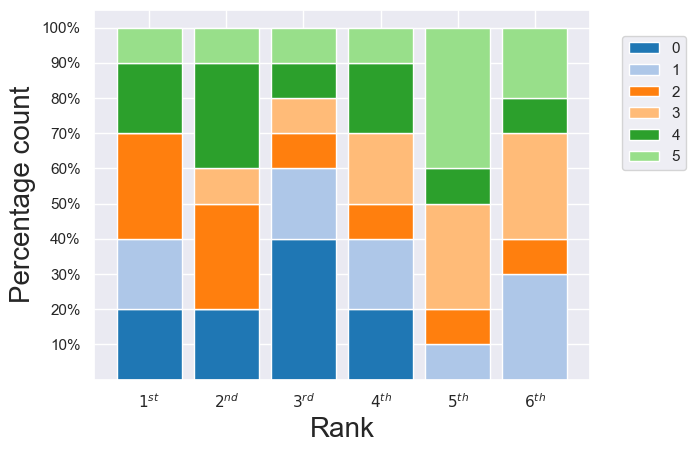

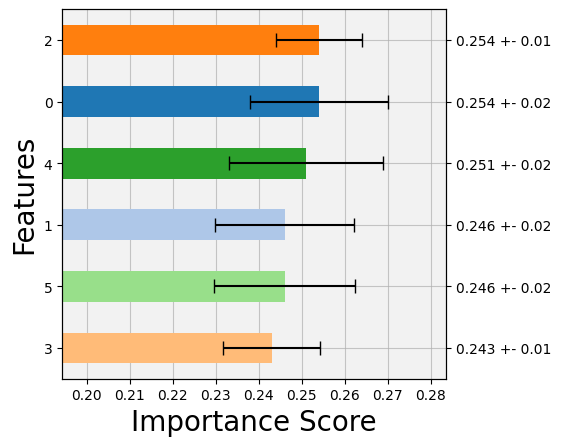

In [17]:
pwd='c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI'
name='Bisect_6d'
dim=6
path = pwd + '\\results\\davide\\Importance_Scores\\Imp Score\\imp_score_GFI_' + name + '.pkl'
with open(path, 'rb') as fl:
    imps = pickle.load(fl)

path = pwd + '\\results\\davide\\Importance_Scores\\Plt Data\\plt_data_GFI_' + name + '.pkl'
with open(path, 'rb') as fl:
    plt_data = pickle.load(fl)

plt_importances_bars(imps,name,pwd,dim)
plt_feat_bar_plot(plt_data,X_train,name,pwd)


In [17]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train=loaded_dictionary['X_train']

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [14:52<00:00, 89.29s/it]


0     1     2     3     4     5
0  20.0  20.0  30.0   0.0  20.0  10.0
1  20.0   0.0  30.0  10.0  30.0  10.0
2  40.0  20.0  10.0  10.0  10.0  10.0
3  20.0  20.0  10.0  20.0  20.0  10.0
4   0.0  10.0  10.0  30.0  10.0  40.0
5   0.0  30.0  10.0  30.0  10.0  20.0

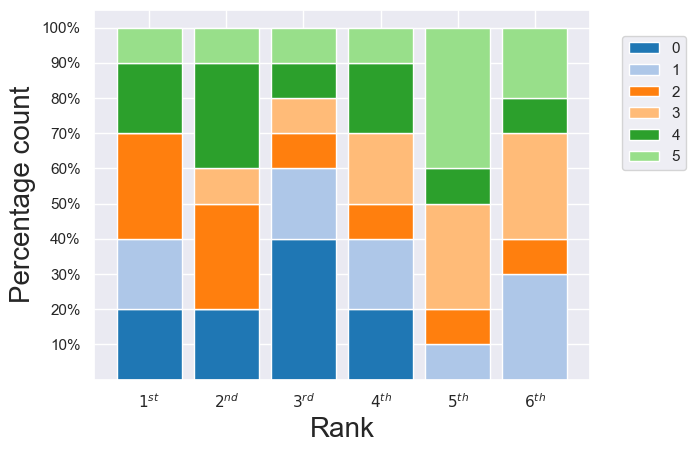

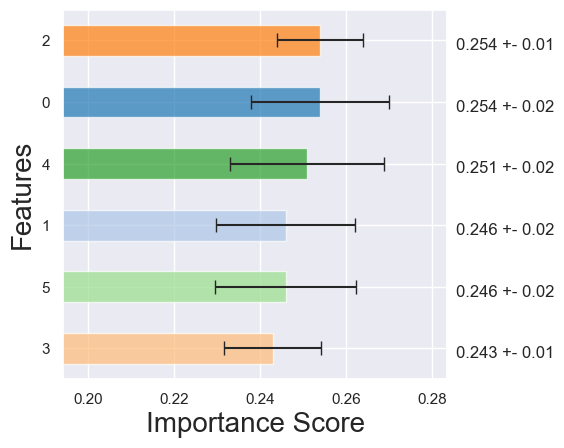

100%|██████████| 10/10 [11:10<00:00, 67.07s/it]


0     1     2     3     4     5
0  30.0  20.0  10.0  10.0  30.0   0.0
1  20.0   0.0  40.0  30.0   0.0  10.0
2   0.0  20.0   0.0  20.0  50.0  10.0
3   0.0  10.0  40.0  10.0  10.0  30.0
4  40.0  30.0  10.0  10.0  10.0   0.0
5  10.0  20.0   0.0  20.0   0.0  50.0

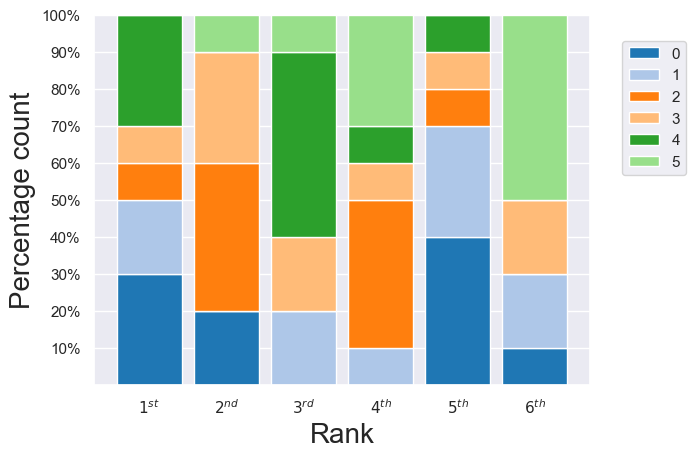

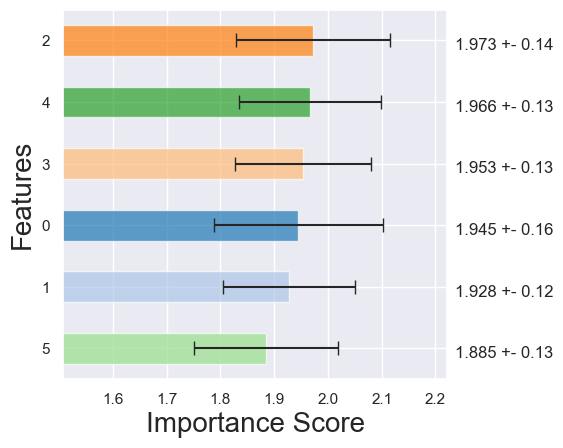

In [18]:
interpretation_plots_synt('Bisect_6d',X_train,X_bisect_6d,pwd)

## X_xaxis

In [35]:
scaler=StandardScaler()
X=np.r_[X_train,X_xaxis]
X=scaler.fit_transform(X)
EDIFFI=Extended_DIFFI_original(300,max_depth=100,subsample_size=256,plus=1)
EDIFFI.fit(X)

### LFI

0     1     2     3     4     5
0  100.0   0.0   0.0   0.0   0.0   0.0
1    0.0  41.0  31.0  19.0   4.0   5.0
2    0.0  21.0  49.0  18.0   6.0   6.0
3    0.0  10.0  17.0  21.0   9.0  43.0
4    0.0  20.0   2.0  41.0  15.0  22.0
5    0.0   8.0   1.0   1.0  66.0  24.0

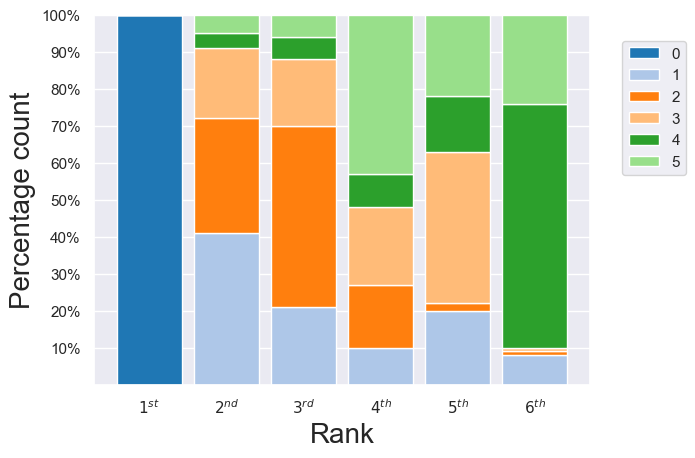

In [23]:
Local_importances = EDIFFI.Local_importances(X_xaxis,True,True)
name = "X_xaxis"
plt_importances_bars(Local_importances, name, pwd, dim)

### GFI 

In [36]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI'

100%|██████████| 10/10 [11:13<00:00, 67.33s/it]


0     1     2     3     4     5
0  100.0   0.0   0.0   0.0   0.0   0.0
1    0.0   0.0  50.0  20.0  20.0  10.0
2    0.0  30.0  30.0   0.0  40.0   0.0
3    0.0  30.0  10.0  30.0  10.0  20.0
4    0.0  30.0   0.0  20.0  10.0  40.0
5    0.0  10.0  10.0  30.0  20.0  30.0

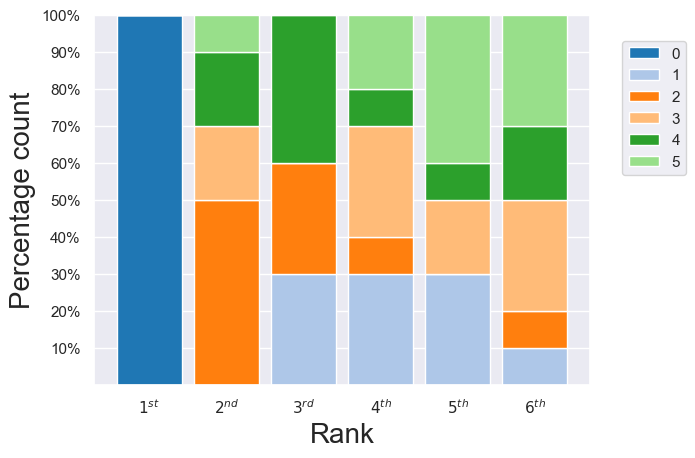

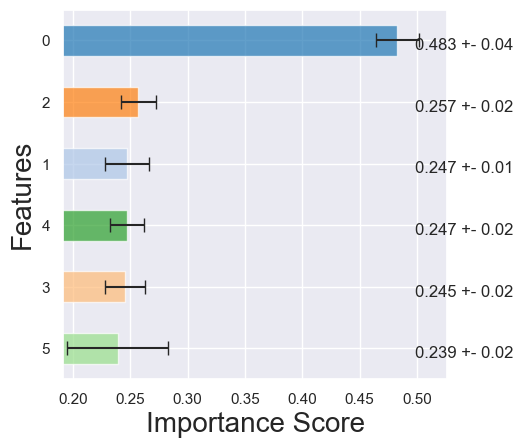

In [37]:
name='X_xaxis_final'
X_test=np.r_[X_train,X_xaxis]
plt_global_importance_bars(EDIFFI,X_test,X_test,10,name,pwd,dim)

## X_yaxis

In [38]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train=loaded_dictionary['X_train']

In [39]:
scaler=StandardScaler()
X=np.r_[X_train,X_yaxis]
X=scaler.fit_transform(X)
EDIFFI=Extended_DIFFI_original(300,max_depth=100,subsample_size=256,plus=1)
EDIFFI.fit(X)

### LFI 

0      1     2     3     4     5
0   0.0  100.0   0.0   0.0   0.0   0.0
1   0.0    0.0  62.0   0.0   0.0  38.0
2   0.0    0.0  33.0   3.0  10.0  54.0
3  15.0    0.0   4.0  20.0  55.0   6.0
4  49.0    0.0   1.0  19.0  29.0   2.0
5  36.0    0.0   0.0  58.0   6.0   0.0

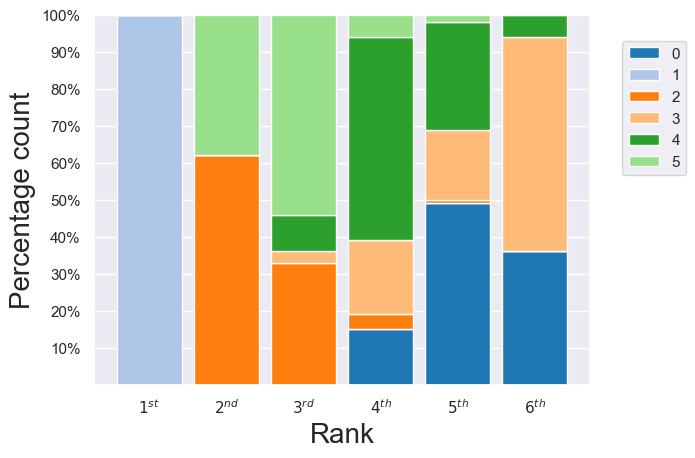

In [28]:
Local_importances = EDIFFI.Local_importances(X_yaxis,True,True)
name = "X_yaxis"
plt_importances_bars(Local_importances, name, pwd, dim)

Here we should have the opposite situation w.r.t X_xaxis. Feature is always the worst important one but Feature 1 is the most important one in 67% of the cases and second most important in 33% of the cases. Feature 1 can still be considered the most important one. This result is probably due to the stochasticity of the model. 

Maybe creating another instance of EXIFFI it works better -> in fact 

### GFI

100%|██████████| 10/10 [16:47<00:00, 100.72s/it]


0     1     2     3     4     5
0   0.0  90.0  10.0   0.0   0.0   0.0
1   0.0  10.0  50.0   0.0  40.0   0.0
2  30.0   0.0  20.0  20.0  30.0   0.0
3  10.0   0.0  10.0  60.0  10.0  10.0
4  40.0   0.0  10.0  20.0  10.0  20.0
5  20.0   0.0   0.0   0.0  10.0  70.0

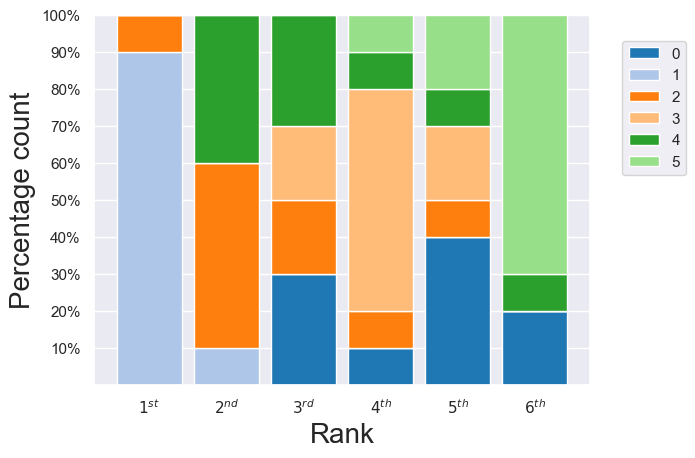

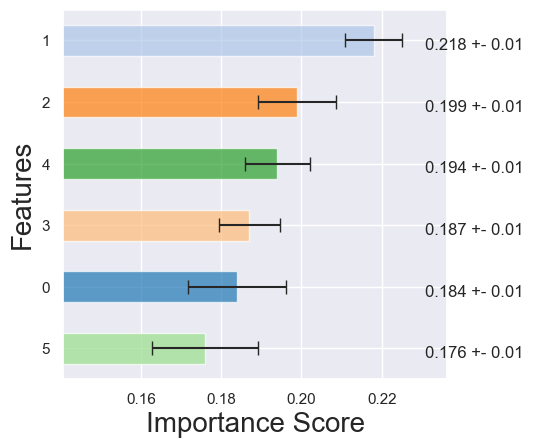

In [40]:
name='X_yaxis_final'
#X_test=np.r_[X_train,X_yaxis]
plt_global_importance_bars(EDIFFI,X,X,10,name,pwd,dim)

## X_bisec

In [30]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train=loaded_dictionary['X_train']

In [31]:
scaler=StandardScaler()
X=np.r_[X_train,X_bisect]
X=scaler.fit_transform(X)
EDIFFI=Extended_DIFFI_original(300,max_depth=100,subsample_size=256,plus=1)
EDIFFI.fit(X)

In [32]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
pwd=os.getcwd()
dim=X.shape[1]

### LFI

0     1     2     3     4     5
0  74.0  26.0   0.0   0.0   0.0   0.0
1  26.0  74.0   0.0   0.0   0.0   0.0
2   0.0   0.0  49.0  19.0  15.0  17.0
3   0.0   0.0   8.0  23.0   7.0  62.0
4   0.0   0.0  11.0  30.0  45.0  14.0
5   0.0   0.0  32.0  28.0  33.0   7.0

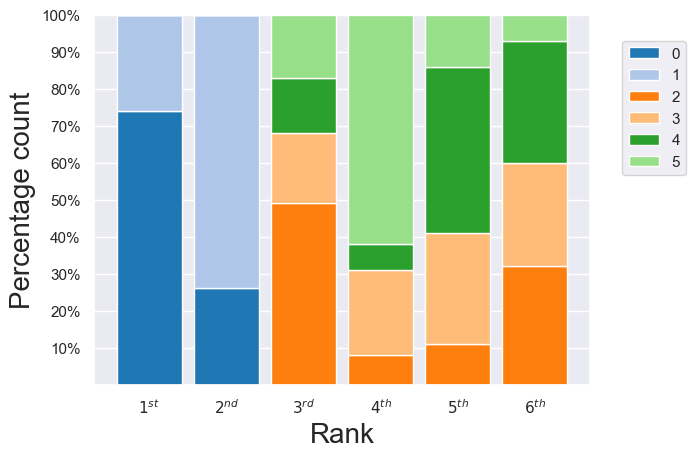

In [33]:
Local_importances = EDIFFI.Local_importances(X_bisect,True,True)
name = "X_bisec"
plt_importances_bars(Local_importances, name, pwd, dim)

Here we should have the first and second most important features divided between feature 0 and feature 1. In this execution there is a little bit this thing but we have also the other noisy variables that are considered important. Anyway these are the Local Feature scores so it may be that we have this mess mainly in this situation that is less clear than the one of X_xaxis and X_yaxis. 

### GFI 

100%|██████████| 10/10 [11:14<00:00, 67.42s/it]


0     1     2     3     4     5
0  40.0  50.0  10.0   0.0   0.0   0.0
1  30.0  30.0  30.0  10.0   0.0   0.0
2  30.0  10.0  30.0  20.0  10.0   0.0
3   0.0  10.0  30.0  20.0  40.0   0.0
4   0.0   0.0   0.0  50.0  40.0  10.0
5   0.0   0.0   0.0   0.0  10.0  90.0

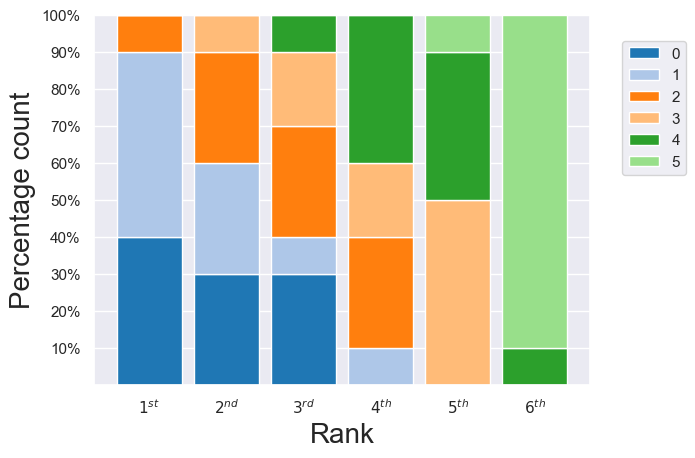

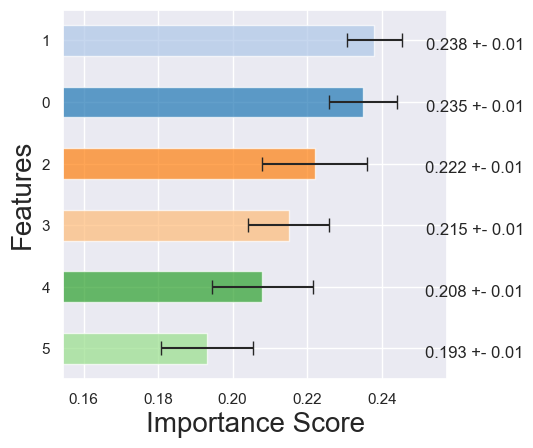

In [34]:
name='X_bisect_final'
X_test=np.r_[X_train,X_bisect]
plt_global_importance_bars(EDIFFI,X,X,10,name,pwd,dim)

## X_bisec_3d

In [43]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train=loaded_dictionary['X_train']

In [44]:
scaler=StandardScaler()
X=np.r_[X_train,X_bisect_3d]
X=scaler.fit_transform(X)
EDIFFI=Extended_DIFFI_original(300,max_depth=100,subsample_size=256,plus=1)
EDIFFI.fit(X)

In [45]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
pwd=os.getcwd()
dim=X.shape[1]

### LFI

0     1     2     3     4     5
0  56.0   1.0  43.0   0.0   0.0   0.0
1  23.0   6.0   6.0  46.0   0.0  19.0
2  14.0  28.0   8.0   6.0   6.0  38.0
3   6.0  24.0  13.0   1.0  26.0  30.0
4   1.0  31.0  17.0  15.0  26.0  10.0
5   0.0  10.0  13.0  32.0  42.0   3.0

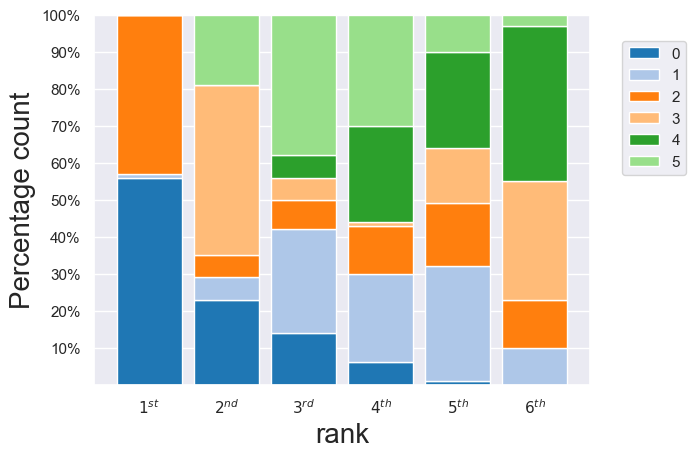

In [46]:
Local_importances = EDIFFI.Local_importances(X_bisect_3d,True,True)
name = "X_bisec_3d"
plt_importances_bars(Local_importances, name, pwd, dim)

### GFI 

In synt_bisect_3d the anomalies are distributed on the bisector hyperplane between Feature 0, 1 and 2. So generalizing form what was already said for synt_bisect and synt_anti_bisect the most important feature is one of the first 3 depending on the stochasticiy of the model. In the particular instance whose Feature Importance plot is reported here the most important Feature is Feature 2 that is any way closely followed by Feature 0 and 1. 

100%|██████████| 10/10 [17:27<00:00, 104.71s/it]


0     1     2     3     4     5
0  30.0  40.0  30.0   0.0   0.0   0.0
1  30.0  50.0  20.0   0.0   0.0   0.0
2  40.0  10.0  50.0   0.0   0.0   0.0
3   0.0   0.0   0.0  50.0  40.0  10.0
4   0.0   0.0   0.0  50.0  20.0  30.0
5   0.0   0.0   0.0   0.0  40.0  60.0

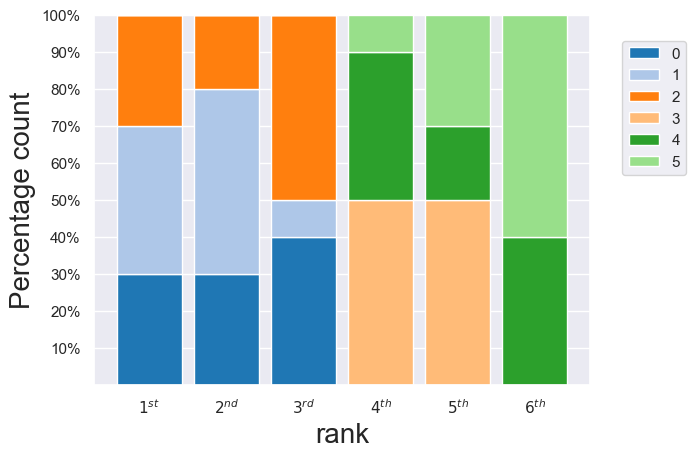

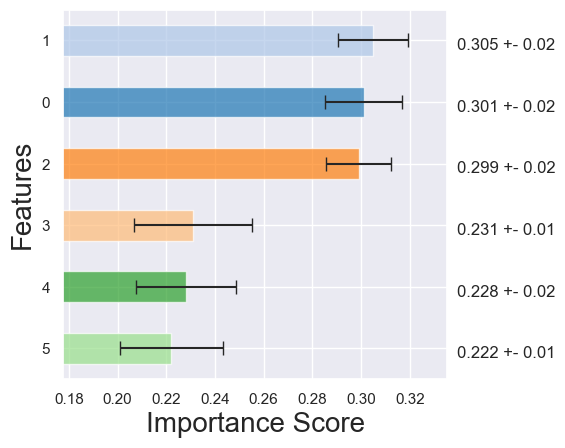

In [47]:
name='X_bisec_3d_final'
X_test=np.r_[X_train,X_bisect_3d]
plt_global_importance_bars(EDIFFI,X_test,X_test,10,name,pwd,dim)

## X_bisec_4d

In [48]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_bisect_4d=scaler.transform(X_bisect_4d)
X=np.r_[X_train,X_bisect_4d]
EDIFFI=Extended_DIFFI_original(300,max_depth=100,subsample_size=256,plus=1)
EDIFFI.fit(X)

### LFI 

0     1     2     3     4     5
0  12.0  34.0  23.0  19.0   6.0   6.0
1  19.0  21.0  20.0  19.0  12.0   9.0
2  13.0  20.0  13.0  23.0  20.0  11.0
3  14.0  12.0  16.0  27.0  16.0  15.0
4  16.0  10.0  19.0   7.0  21.0  27.0
5  26.0   3.0   9.0   5.0  25.0  32.0

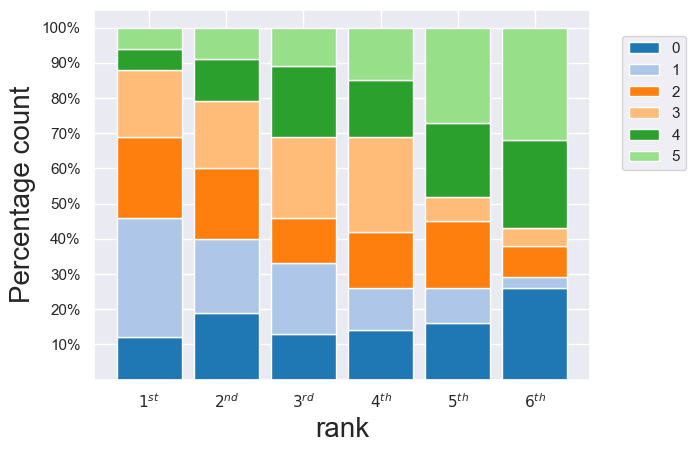

In [49]:
Local_importances = EDIFFI.Local_importances(X_bisect_4d,True,True)
name = "X_bisect_4d"
plt_importances_bars(Local_importances, name, pwd, dim)

### GFI 

100%|██████████| 10/10 [11:04<00:00, 66.49s/it]


0     1     2     3     4     5
0  20.0  30.0  30.0  20.0   0.0   0.0
1  10.0  30.0  30.0  20.0   0.0  10.0
2  50.0  20.0   0.0  20.0  10.0   0.0
3  20.0  20.0  20.0  30.0  10.0   0.0
4   0.0   0.0  10.0  10.0  30.0  50.0
5   0.0   0.0  10.0   0.0  50.0  40.0

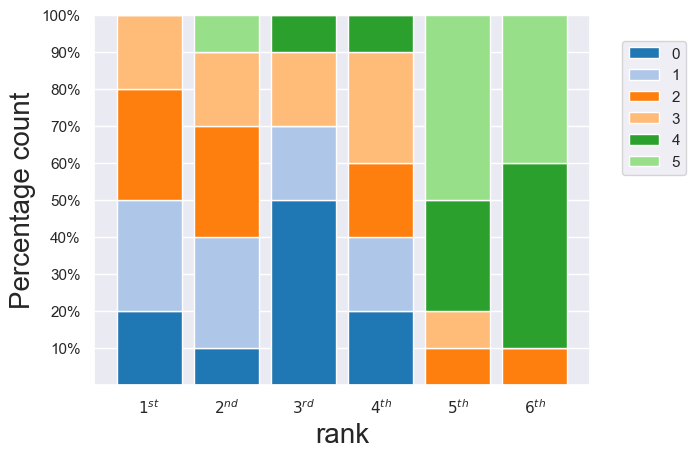

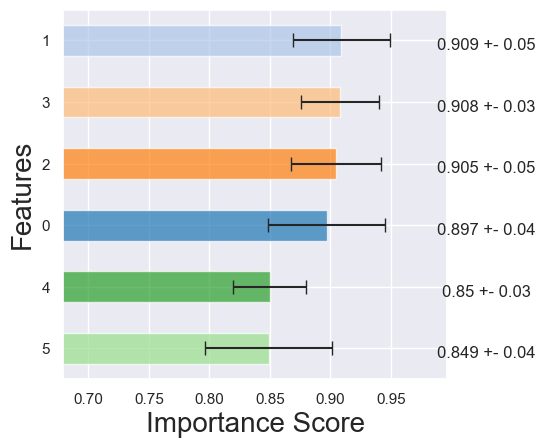

In [50]:
name='X_bisec_4d'
X_test=np.r_[X_train,X_bisect_4d]
plt_global_importance_bars(EDIFFI,X_test,X_test,10,name,pwd,dim)

## X_bisec_6d

In [48]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train=loaded_dictionary['X_train']

In [49]:
scaler=StandardScaler()
X=np.r_[X_train,X_bisect_6d]
X=scaler.fit_transform(X)
EDIFFI=Extended_DIFFI_original(300,max_depth=100,subsample_size=256,plus=1)
EDIFFI.fit(X)

In [50]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
pwd=os.getcwd()
dim=X.shape[1]

### LFI 

0     1     2     3     4     5
0  20.0   9.0  63.0   2.0   5.0   1.0
1  22.0  23.0  21.0  15.0  10.0   9.0
2   5.0  19.0  12.0  13.0  22.0  29.0
3   9.0   5.0   3.0  27.0  17.0  39.0
4  22.0  11.0   1.0  29.0  22.0  15.0
5  22.0  33.0   0.0  14.0  24.0   7.0

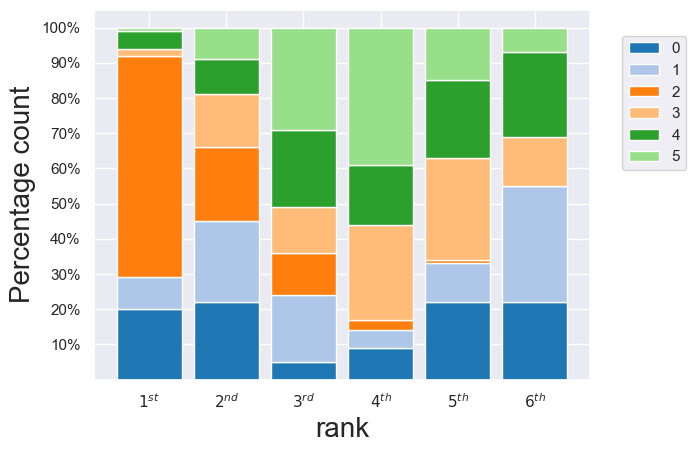

In [51]:
Local_importances = EDIFFI.Local_importances(X_bisect_6d,True,True)
name = "X_bisec_6d"
plt_importances_bars(Local_importances, name, pwd, dim)

### GFI 

With synt_bisect_4d and synt_bisect_6d the task of correctly detecting the most important feature/s becomes more complicated because outliers are due to anomalous values on 4 or 6 features. This is reflected on the importance scores that can be seen on the two Feature Importance Plots above where the score are very similar among all the features and so the Feature with the highest importance score is not guaranteed to be the real most important one. 

100%|██████████| 10/10 [11:37<00:00, 69.72s/it]


0     1     2     3     4     5
0   0.0  20.0  30.0  10.0  20.0  20.0
1  20.0  20.0  40.0   0.0  10.0  10.0
2  10.0  20.0   0.0  50.0  20.0   0.0
3  30.0  10.0  10.0   0.0  10.0  40.0
4  10.0  30.0  10.0  20.0  20.0  10.0
5  30.0   0.0  10.0  20.0  20.0  20.0

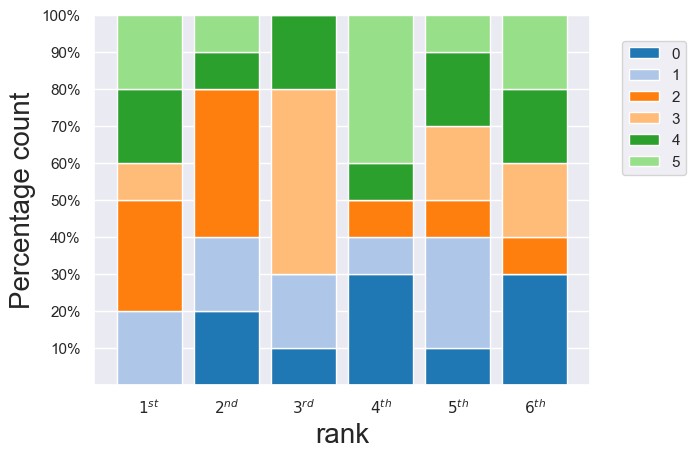

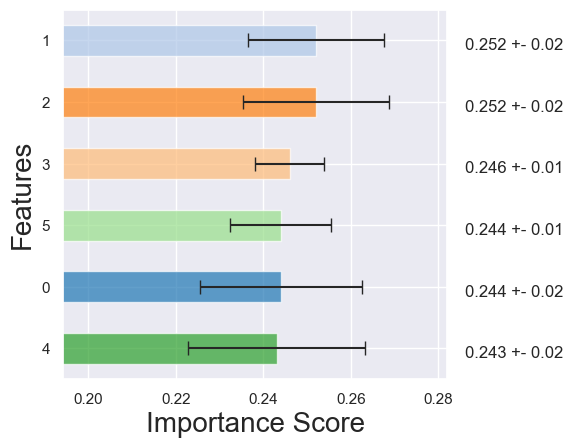

In [52]:
name='X_bisec_6d_final'
X_test=np.r_[X_train,X_bisect_6d]
plt_global_importance_bars(EDIFFI,X_test,X_test,10,name,pwd,dim)

# GFI/LFI BAR PLOTS FOR TOY DATASETS

## Toy 2d 

In [9]:
scaler=StandardScaler()
X_toy_2d=scaler.fit_transform(X_toy_2d)
EDIFFI=Extended_DIFFI_original(300,max_depth=100,subsample_size=256,plus=1)
EDIFFI.fit(X_toy_2d)

In [16]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
pwd=os.getcwd()
dim=X_toy_2d.shape[1]

### LFI 

0     1
0  30.0  70.0
1  70.0  30.0

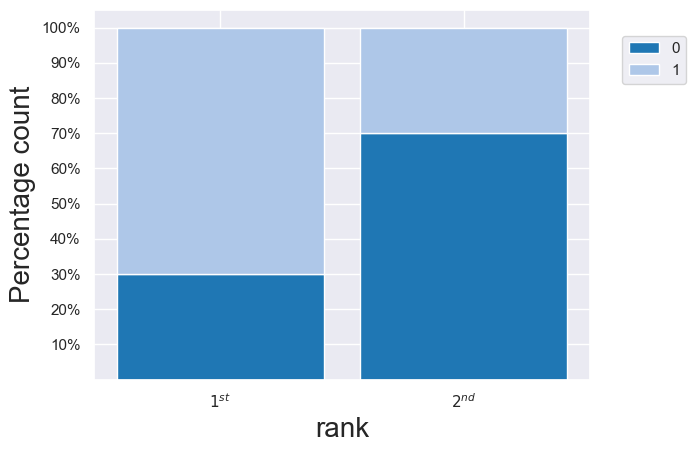

In [17]:
Local_importances = EDIFFI.Local_importances(X_test,True,True)
name = "X_toy_2d"
plt_importances_bars(Local_importances, name, pwd, dim,f=dim)

### GFI 

100%|██████████| 10/10 [07:10<00:00, 43.09s/it]


0     1
0  40.0  60.0
1  60.0  40.0

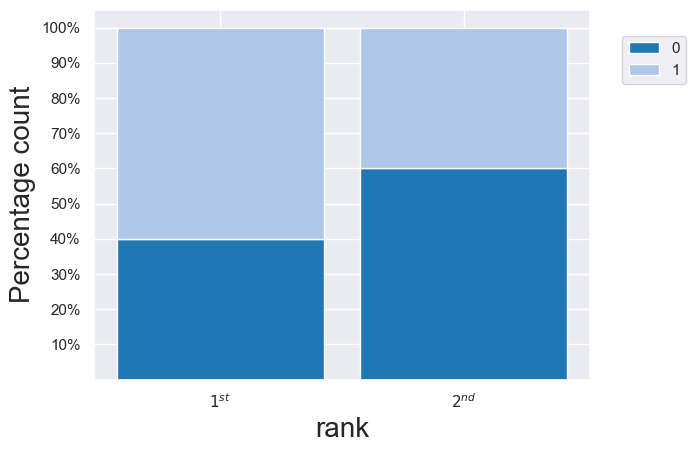

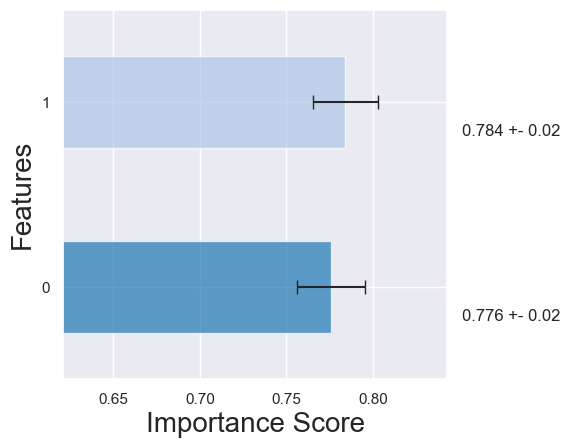

In [18]:
name='X_toy_2d'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_toy_2d,X_toy_2d,10,name,pwd,dim,f=2)

100%|██████████| 10/10 [03:44<00:00, 22.41s/it]


0     1
0  50.0  50.0
1  50.0  50.0

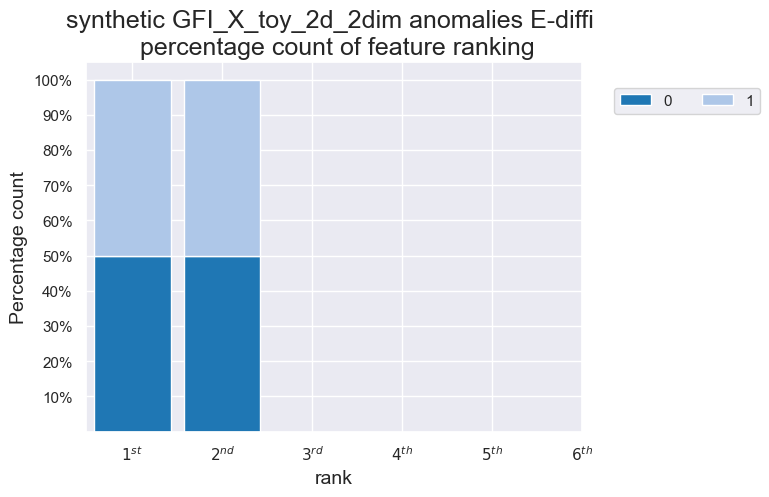

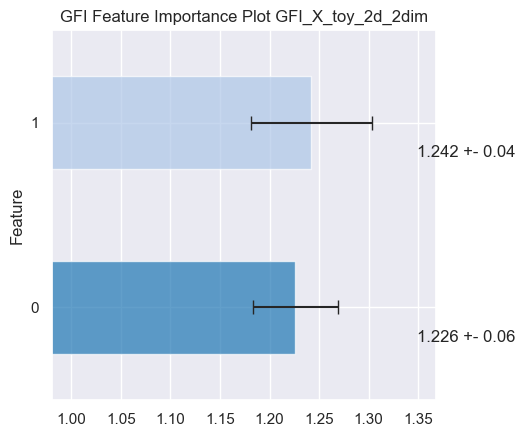

In [18]:
name='X_toy_2d_2dim'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

## Toy 3d 

In [18]:
X_train,X_test=partition_data(X_toy_3d,y)
X_train.shape,X_test.shape

((390, 6), (10, 6))

### LFI 

0     1     2     3     4     5
0  10.0  40.0  50.0   0.0   0.0   0.0
1  40.0  20.0   0.0   0.0   0.0  40.0
2   0.0  30.0  30.0  20.0  10.0  10.0
3  10.0   0.0  20.0  50.0  20.0   0.0
4  30.0   0.0   0.0  20.0  20.0  30.0
5  10.0  10.0   0.0  10.0  50.0  20.0

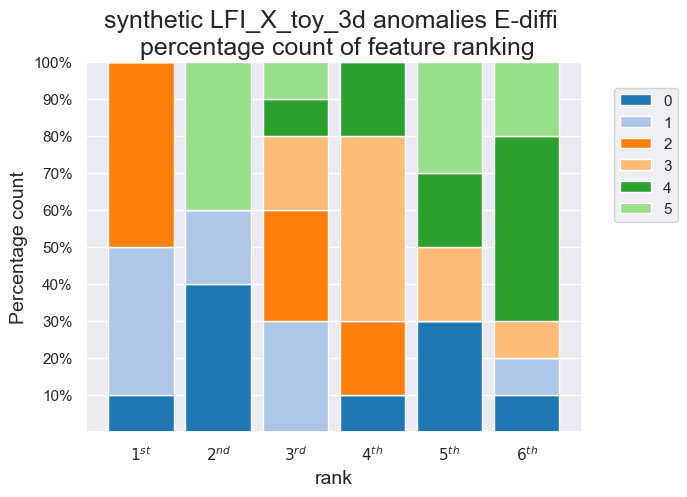

In [32]:
Local_importances = EDIFFI.Local_importances(X_test,True,True)
name = "X_toy_3d"
plt_importances_bars(Local_importances, name, pwd, dim)

### GFI 

100%|██████████| 10/10 [04:02<00:00, 24.21s/it]


0     1     2     3     4     5
0  100.0   0.0   0.0   0.0   0.0   0.0
1    0.0  20.0  10.0  30.0  20.0  20.0
2    0.0  20.0  30.0  40.0   0.0  10.0
3    0.0   0.0  20.0  30.0  30.0  20.0
4    0.0  30.0  30.0   0.0  20.0  20.0
5    0.0  30.0  10.0   0.0  30.0  30.0

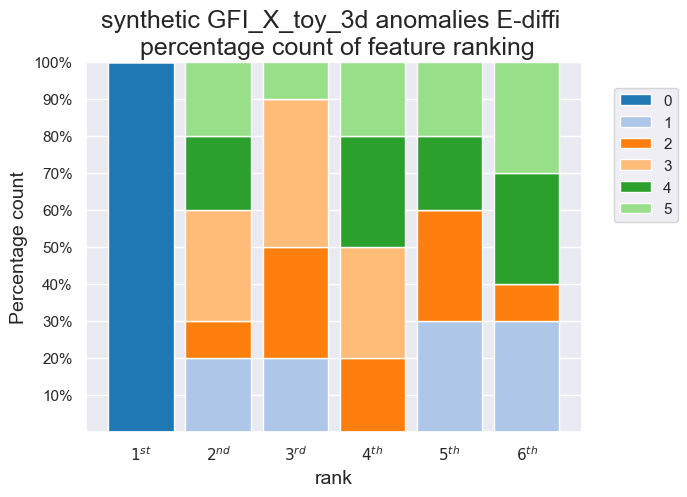

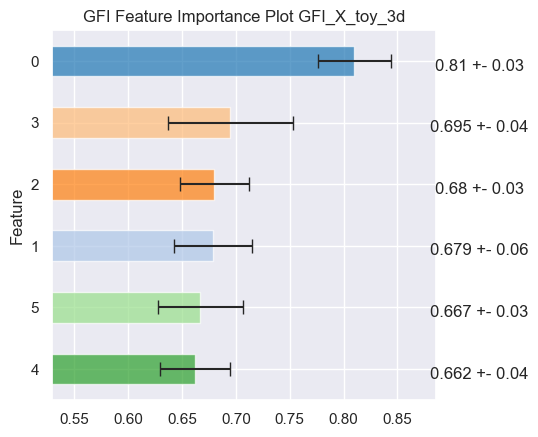

In [19]:
name='X_toy_3d'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

### Toy 4d

In [20]:
X_train,X_test=partition_data(X_toy_4d,y)
X_train.shape,X_test.shape

((390, 6), (10, 6))

#### LFI 

0     1     2     3     4     5
0  60.0   0.0   0.0  40.0   0.0   0.0
1  20.0  20.0  30.0   0.0  10.0  20.0
2  10.0  40.0  10.0  10.0   0.0  30.0
3  10.0  20.0  10.0  10.0  50.0   0.0
4   0.0  10.0  30.0  10.0  30.0  20.0
5   0.0  10.0  20.0  30.0  10.0  30.0

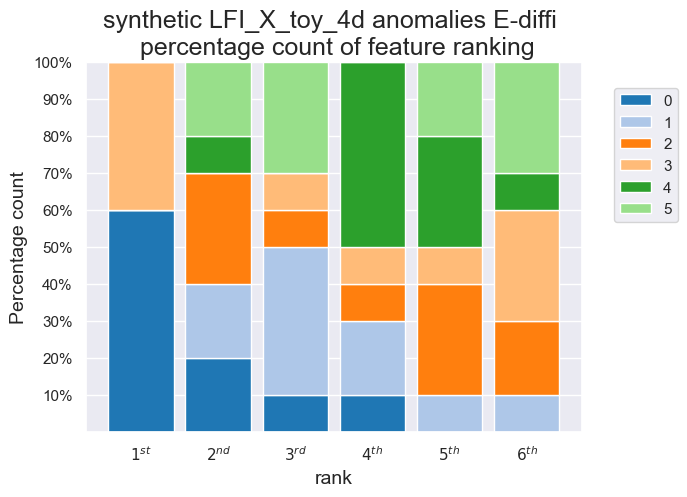

In [39]:
Local_importances = EDIFFI.Local_importances(X_test,True,True)
name = "X_toy_4d"
plt_importances_bars(Local_importances, name, pwd, dim)

### GFI 

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [04:41<00:00, 28.20s/it]


0     1     2     3     4     5
0  100.0   0.0   0.0   0.0   0.0   0.0
1    0.0  10.0  20.0  40.0  10.0  20.0
2    0.0  20.0  40.0  20.0  10.0  10.0
3    0.0  20.0  20.0  10.0  30.0  20.0
4    0.0  20.0   0.0  20.0  40.0  20.0
5    0.0  30.0  20.0  10.0  10.0  30.0

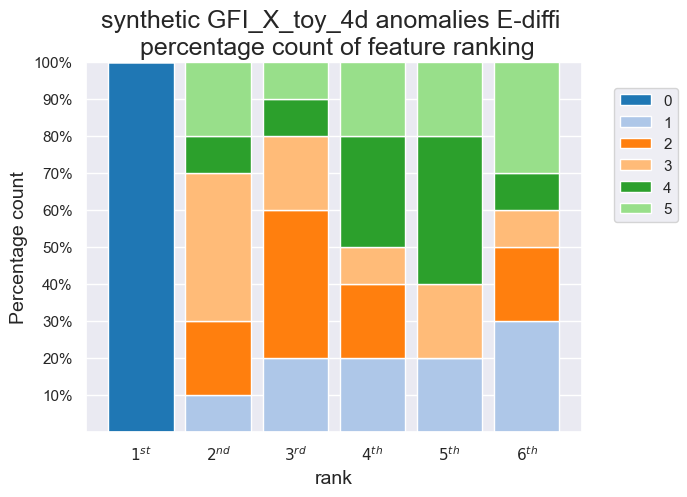

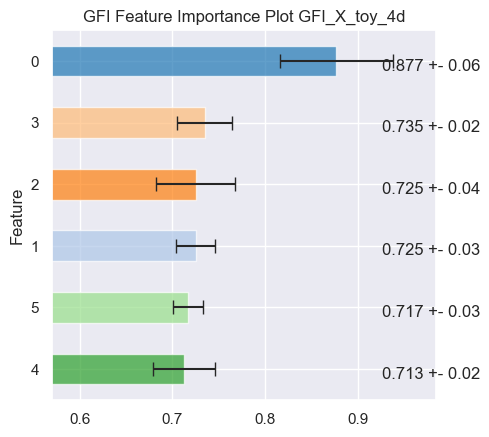

In [21]:
name='X_toy_4d'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

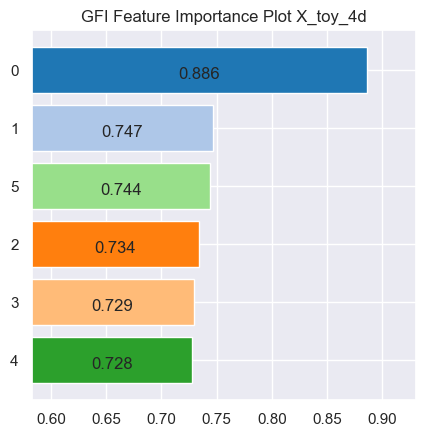

In [63]:
df_toy_4d=pd.DataFrame({'Importances': [0.886,0.747,0.744,0.734,0.729,0.728],
                     'feat_order':[0,1,5,2,3,4]})
plt_feat_bar_plot(df_toy_4d,X_train,'X_toy_4d',pwd)

## Toy 6d

In [22]:
X_train,X_test=partition_data(X_toy_6d,y)
X_train.shape,X_test.shape

((390, 6), (10, 6))

### LFI 

0     1     2     3     4     5
0  20.0   0.0   0.0   0.0  50.0  30.0
1  30.0  10.0  10.0   0.0  40.0  10.0
2  20.0  40.0   0.0   0.0  10.0  30.0
3  30.0  30.0  10.0   0.0   0.0  30.0
4   0.0  20.0  50.0  30.0   0.0   0.0
5   0.0   0.0  30.0  70.0   0.0   0.0

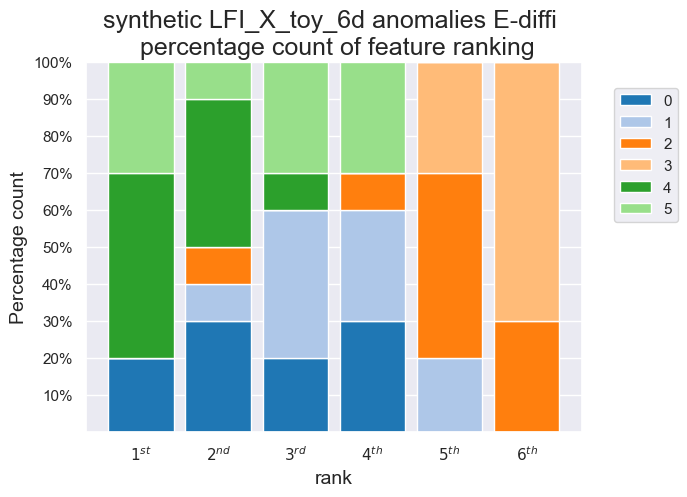

In [76]:
Local_importances = EDIFFI.Local_importances(X_test,True,True)
name = "X_toy_6d"
plt_importances_bars(Local_importances, name, pwd, dim)

### GFI 

100%|██████████| 10/10 [03:30<00:00, 21.05s/it]


0     1     2     3     4     5
0  100.0   0.0   0.0   0.0   0.0   0.0
1    0.0  20.0   0.0  10.0  60.0  10.0
2    0.0  30.0  10.0  30.0  20.0  10.0
3    0.0  20.0  10.0  30.0  10.0  30.0
4    0.0  20.0  30.0  20.0   0.0  30.0
5    0.0  10.0  50.0  10.0  10.0  20.0

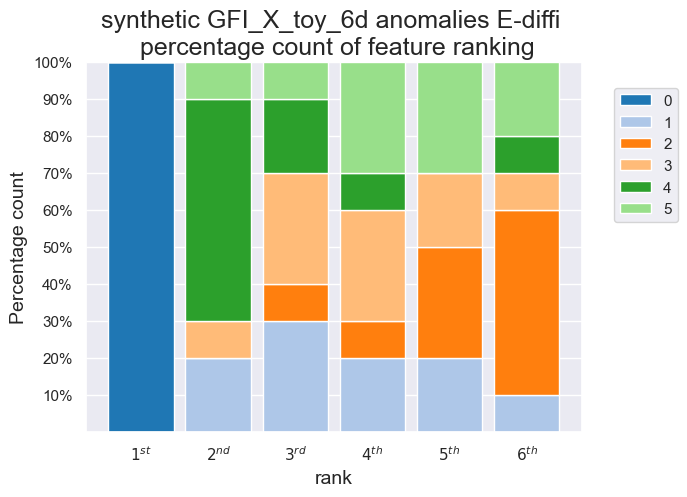

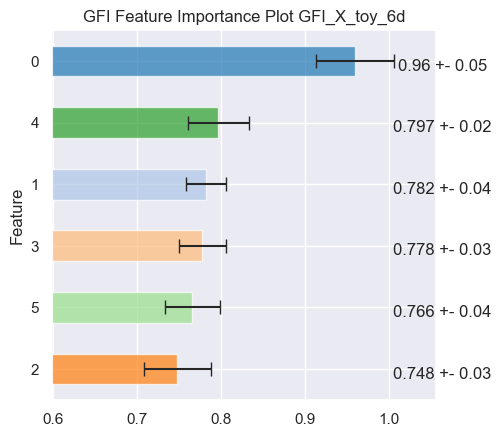

In [23]:
name='X_toy_6d'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

### N.B FOR THE PAPER 

It makes sense that the resulting GFI Bar Plot is similar to the one obtained for X_bisec so with the major importance divided (more or less evenly) between Feature 0 and Feature 1. In fact if we look at the scatter plot of the data distribution in the first two features the anomalies can be isolated with lines/hyperplanes that are parallel to the bisector. In other words the anomalies are points with abnormal values both on x and y. It is not exactly like the bisector because here the anomalies are not completely aligned to form a bisector line. 

Another reason may be the following: 

We have anomalies on the top left and bottom right and we have the two blobs of inliers in the top right and bottom left. Anomalies in the top left have low values for x and high values for y. The fact here is that the blob on the bottom left has low values for x and the one on the top right has high value for y as well. The same holds for the bottom right anomaly cluster. The anomalies on the top left are considered as outliers because they have BOTH high value on y and low values on x, the ones on the bottom right instead have BOTH high values for x and low values for y. 

## Local Importance Scoremap

### Toy_2d

In [78]:
x_train,X_test=partition_data(X_toy_2d,y)
y_train=np.zeros(shape=X_train.shape[0])
y_test=np.ones(shape=X_test.shape[0])

In [79]:
X_toy_2d.shape

(400, 6)

In [80]:
X_test.shape

(10, 6)

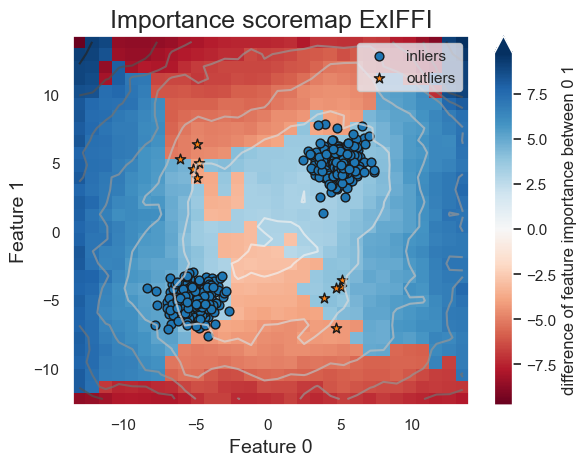

In [81]:
plot_importance_map(EDIFFI,np.r_[X_train,X_test],np.r_[y_train,y_test],30)

# GFI/LFI BAR PLOTS FOR REAL WORLD DATASET 


Here I have to make the division between Outliers and Inliers as it is done in the Importances function so considering that the outliers are 10% of the dataset and so we have to take the 10% of the samples with the highest anomaly score. 

## Wine

In [104]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data'

wine 

[numero elementi = 129]
[percentage outliers = 0.07751937984496124]
[number features = 13]
[number outliers = 10]


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:38<00:00, 15.90s/it]


0     1     2     3     4     5     6     7     8     9     10    11  \
0    0.0   0.0  10.0  10.0  50.0   0.0   0.0   0.0  30.0   0.0   0.0   0.0   
1    0.0   0.0   0.0  10.0  20.0   0.0   0.0   0.0  70.0   0.0   0.0   0.0   
2    0.0   0.0  20.0  40.0  30.0  10.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   10.0   0.0  60.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  20.0   0.0   
4   10.0  10.0   0.0  20.0   0.0   0.0  40.0   0.0   0.0   0.0  10.0   0.0   
5   20.0   0.0  10.0   0.0   0.0   0.0  30.0  10.0   0.0  30.0   0.0   0.0   
6   10.0   0.0   0.0  10.0   0.0  10.0  10.0  20.0   0.0   0.0  30.0  10.0   
7   30.0   0.0   0.0  10.0   0.0   0.0   0.0   0.0   0.0  40.0  20.0   0.0   
8   10.0  10.0   0.0   0.0   0.0  30.0  20.0  10.0   0.0  10.0   0.0  10.0   
9    0.0  10.0   0.0   0.0   0.0  30.0   0.0  20.0   0.0   0.0  10.0  20.0   
10   0.0  50.0   0.0   0.0   0.0   0.0   0.0  10.0   0.0  20.0   0.0  20.0   
11  10.0  10.0   0.0   0.0   0.0  10.0   0.0  30.0   0.0   0.0   0.0  20.0   
12   0.0  10.0   0.0   0.0   0.0  10.0   0.0   0.0   0.0   0.0  10.0  20.0   

      12  
0    0.0  
1    0.0  
2    0.0  
3   10.0  
4   10.0  
5    0.0  
6    0.0  
7    0.0  
8    0.0  
9   10.0  
10   0.0  
11  20.0  
12  50.0

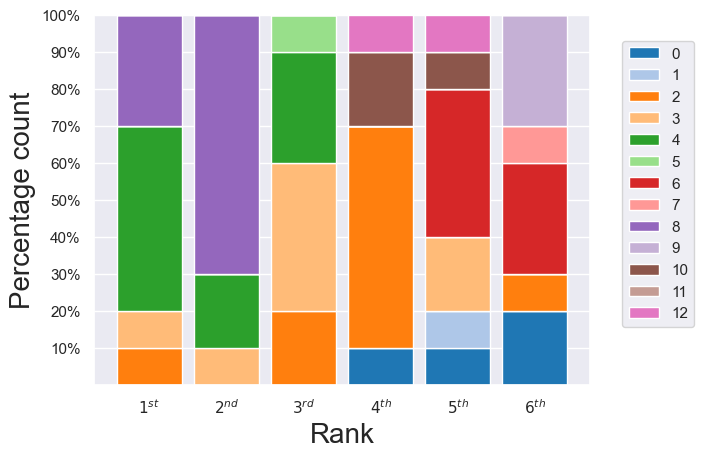

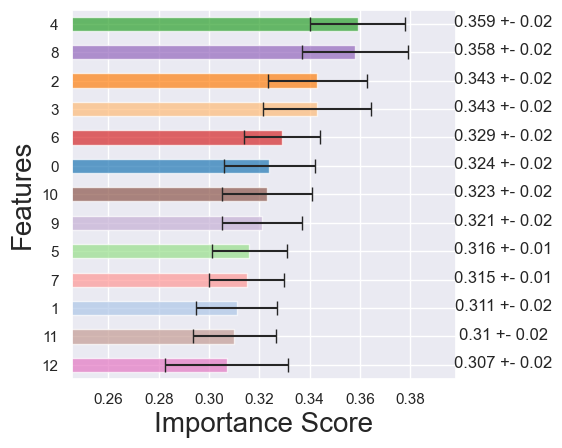

100%|██████████| 10/10 [02:27<00:00, 14.72s/it]


0     1     2     3     4     5     6     7     8     9     10    11  \
0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   30.0   0.0  10.0  10.0   0.0  10.0  30.0   0.0   0.0   0.0   0.0  10.0   
2    0.0   0.0   0.0  30.0  10.0   0.0  20.0   0.0  10.0   0.0   0.0  30.0   
3   30.0   0.0  10.0  20.0   0.0  20.0   0.0  10.0   0.0   0.0   0.0  10.0   
4    0.0   0.0  20.0  20.0  10.0   0.0  40.0   0.0   0.0  10.0   0.0   0.0   
5   10.0   0.0  10.0  10.0   0.0  10.0  10.0   0.0  20.0  20.0  10.0   0.0   
6    0.0  30.0   0.0   0.0  20.0  10.0   0.0  10.0   0.0   0.0  20.0  10.0   
7    0.0  10.0  10.0  10.0  10.0  30.0   0.0  10.0   0.0   0.0  10.0  10.0   
8    0.0  30.0  10.0   0.0   0.0   0.0   0.0  30.0  20.0  10.0   0.0   0.0   
9   10.0   0.0   0.0   0.0  10.0  10.0   0.0  10.0   0.0  20.0  20.0  20.0   
10  10.0   0.0  30.0   0.0  10.0   0.0   0.0  10.0   0.0  10.0  30.0   0.0   
11   0.0  20.0   0.0   0.0  20.0   0.0   0.0  10.0  10.0  20.0  10.0  10.0   
12  10.0  10.0   0.0   0.0  10.0  10.0   0.0  10.0  40.0  10.0   0.0   0.0   

       12  
0   100.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
5     0.0  
6     0.0  
7     0.0  
8     0.0  
9     0.0  
10    0.0  
11    0.0  
12    0.0

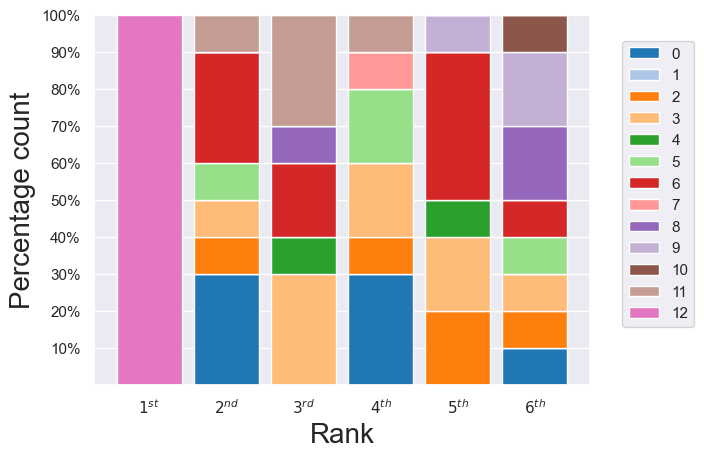

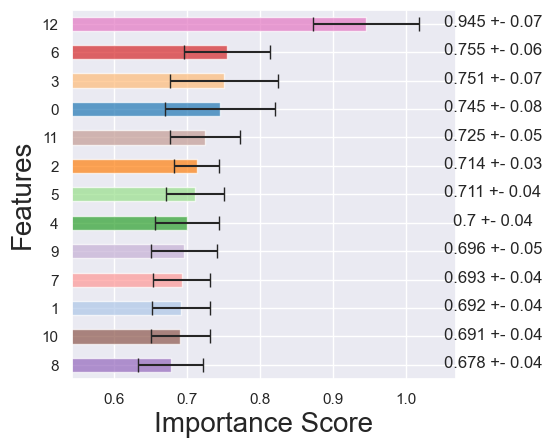

In [122]:
name='wine'
pwd='c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI'
interpretation_plots('wine',pwd)

In [ ]:
X,y=dataset('wine',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

No Split

In [94]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
X,y=dataset('wine',os.getcwd()+'\\')
X,y=downsample(X,y)
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
pwd=os.getcwd()
X_train,X_test=partition_data(X,y)
X=np.r_[X_train,X_test]
scaler=StandardScaler()
X=scaler.fit_transform(X)
dim=X.shape[1]
EDIFFI=Extended_DIFFI_original(300,max_depth=100,subsample_size=256,plus=1)

wine 

[numero elementi = 129]
[percentage outliers = 0.07751937984496124]
[number features = 13]
[number outliers = 10]


In [80]:
name='wine'
#X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X,X,10,name,pwd,dim,f=6)

100%|██████████| 10/10 [02:38<00:00, 15.90s/it]


In [108]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')

In [109]:
path = os.getcwd() + '\\results\\davide\\Importance_Scores\\Imp Score\\imp_score_GFI_' + name + '.pkl'
with open(path, 'rb') as f:
    imps_wine = pickle.load(f)

path = os.getcwd() + '\\results\\davide\\Importance_Scores\\Plt Data\\plt_data_GFI_' + name + '.pkl'
with open(path, 'rb') as f:
    plt_data_wine = pickle.load(f)

In [110]:
type(imps_wine)

numpy.ndarray

0     1     2     3     4     5     6     7     8     9     10    11  \
0    0.0   0.0   0.0  10.0  50.0   0.0  10.0   0.0  30.0   0.0   0.0   0.0   
1    0.0   0.0  10.0  30.0  40.0   0.0  10.0   0.0  10.0   0.0   0.0   0.0   
2   10.0   0.0  10.0  30.0  10.0   0.0   0.0   0.0  30.0   0.0  10.0   0.0   
3   30.0   0.0  20.0  10.0   0.0   0.0  10.0   0.0  10.0  10.0  10.0   0.0   
4   10.0   0.0  30.0  10.0   0.0   0.0   0.0   0.0  10.0   0.0  20.0   0.0   
5    0.0  10.0  10.0   0.0   0.0  20.0  40.0  10.0   0.0   0.0  10.0   0.0   
6   10.0  20.0  10.0   0.0   0.0  20.0  10.0   0.0   0.0  20.0   0.0   0.0   
7   30.0  10.0  10.0   0.0   0.0  10.0   0.0  10.0   0.0   0.0  30.0   0.0   
8    0.0   0.0   0.0   0.0   0.0   0.0  20.0  30.0   0.0  10.0  10.0  10.0   
9    0.0   0.0   0.0   0.0   0.0  20.0   0.0   0.0  10.0  10.0   0.0  40.0   
10   0.0  10.0   0.0  10.0   0.0  10.0   0.0  30.0   0.0  20.0   0.0  20.0   
11  10.0  10.0   0.0   0.0   0.0  10.0   0.0  10.0   0.0  30.0  10.0  10.0   
12   0.0  40.0   0.0   0.0   0.0  10.0   0.0  10.0   0.0   0.0   0.0  20.0   

      12  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4   20.0  
5    0.0  
6   10.0  
7    0.0  
8   20.0  
9   20.0  
10   0.0  
11  10.0  
12  20.0

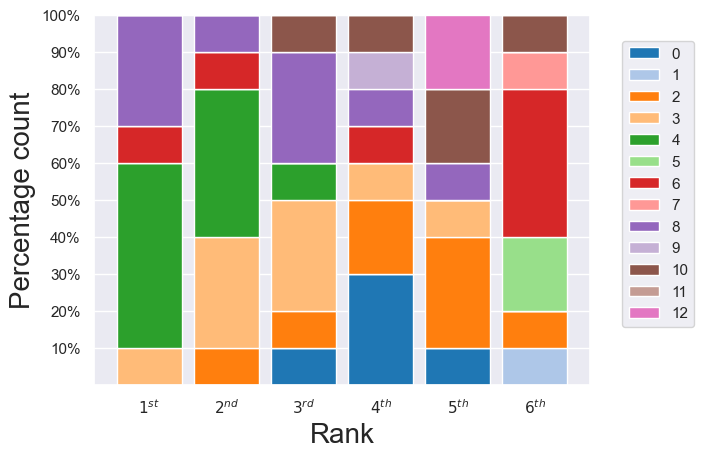

In [113]:
plt_importances_bars(imps_wine,name,pwd,dim)

100%|██████████| 10/10 [02:42<00:00, 16.27s/it]


0     1     2     3     4     5     6     7     8     9     10    11  \
0    0.0   0.0   0.0   0.0  60.0   0.0   0.0   0.0  40.0   0.0   0.0   0.0   
1    0.0   0.0  10.0  10.0  40.0   0.0  10.0   0.0  30.0   0.0   0.0   0.0   
2   20.0   0.0  10.0  40.0   0.0  10.0   0.0   0.0  20.0   0.0   0.0   0.0   
3    0.0   0.0  30.0  10.0   0.0   0.0  10.0   0.0  10.0   0.0  20.0  20.0   
4   10.0   0.0  10.0  20.0   0.0  10.0  10.0   0.0   0.0  10.0  30.0   0.0   
5   10.0  20.0   0.0  10.0   0.0  10.0  40.0  10.0   0.0   0.0   0.0   0.0   
6    0.0  10.0  20.0  10.0   0.0   0.0  20.0   0.0   0.0  20.0  10.0   0.0   
7   20.0   0.0  10.0   0.0   0.0  20.0   0.0   0.0   0.0  20.0  20.0   0.0   
8   20.0   0.0   0.0   0.0   0.0  10.0   0.0  10.0   0.0  10.0   0.0  20.0   
9    0.0  10.0  10.0   0.0   0.0  10.0   0.0  30.0   0.0  20.0   0.0  10.0   
10   0.0  20.0   0.0   0.0   0.0  10.0   0.0  20.0   0.0  10.0  10.0  20.0   
11  20.0  30.0   0.0   0.0   0.0  20.0   0.0  10.0   0.0   0.0  10.0   0.0   
12   0.0  10.0   0.0   0.0   0.0   0.0  10.0  20.0   0.0  10.0   0.0  30.0   

      12  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  
5    0.0  
6   10.0  
7   10.0  
8   30.0  
9   10.0  
10  10.0  
11  10.0  
12  20.0

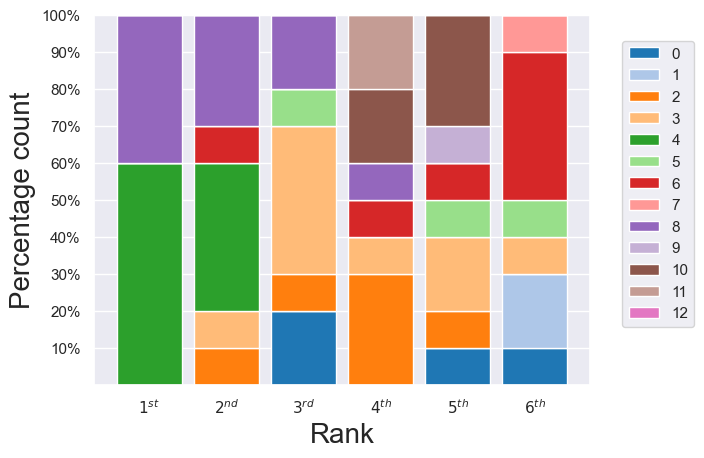

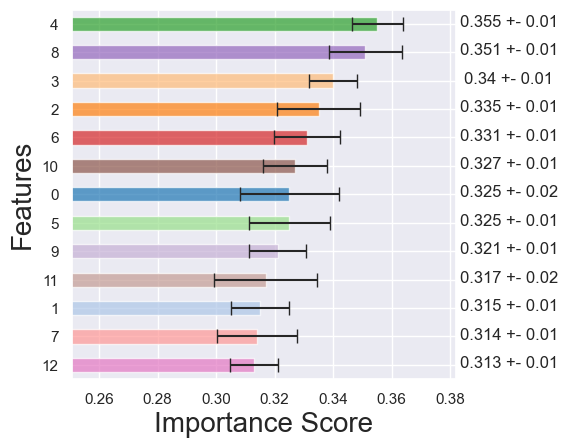

In [95]:
name='Wine'
#X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X,X,10,name,pwd,dim)

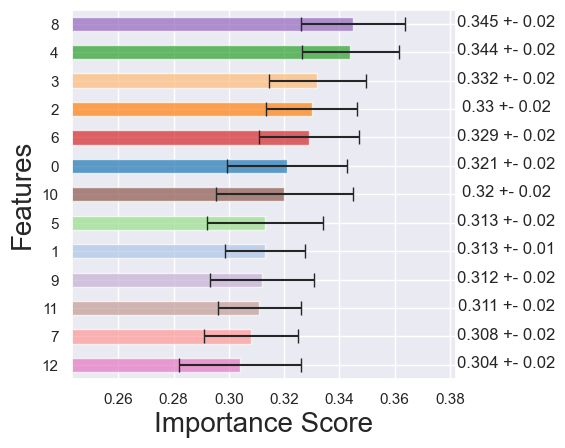

In [89]:
plt_importances_bars(imps_wine,name,pwd,dim,f)
plt_feat_bar_plot(plt_data_wine,X,name,pwd,f)

### Create and train the model 

In [5]:
N = X.shape[0]
dim = X.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10
p = sum(y)/len(y)

In [6]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()
pwd = os.getcwd()
dim = X.shape[1]
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size,plus=1)
EDIFFI.fit(X_train)

### LFI 

0     1     2     3     4     5     6     7     8     9     10    11  \
0   10.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   10.0   0.0  20.0  10.0   0.0   0.0  30.0   0.0   0.0   0.0   0.0  20.0   
2   20.0   0.0  10.0   0.0   0.0   0.0  20.0  10.0  10.0   0.0  10.0  20.0   
3   30.0  10.0  10.0  10.0   0.0  10.0   0.0  10.0   0.0   0.0   0.0  20.0   
4    0.0   0.0   0.0  10.0  10.0  10.0  10.0  20.0  10.0   0.0  10.0  20.0   
5   10.0  10.0  10.0  20.0  10.0   0.0  20.0   0.0  10.0   0.0   0.0  10.0   
6   10.0   0.0  20.0   0.0  30.0  10.0   0.0  20.0   0.0   0.0  10.0   0.0   
7    0.0   0.0  10.0  30.0  10.0  10.0   0.0  10.0  10.0  20.0   0.0   0.0   
8   10.0   0.0   0.0  10.0   0.0   0.0  10.0  20.0  20.0   0.0  30.0   0.0   
9    0.0  40.0   0.0   0.0  10.0  10.0  10.0  10.0   0.0   0.0  10.0  10.0   
10   0.0   0.0  20.0   0.0   0.0  30.0   0.0   0.0  20.0  10.0  20.0   0.0   
11   0.0  10.0   0.0  10.0  20.0  10.0   0.0   0.0  10.0  30.0  10.0   0.0   
12   0.0  30.0   0.0   0.0  10.0  10.0   0.0   0.0  10.0  40.0   0.0   0.0   

      12  
0   90.0  
1   10.0  
2    0.0  
3    0.0  
4    0.0  
5    0.0  
6    0.0  
7    0.0  
8    0.0  
9    0.0  
10   0.0  
11   0.0  
12   0.0

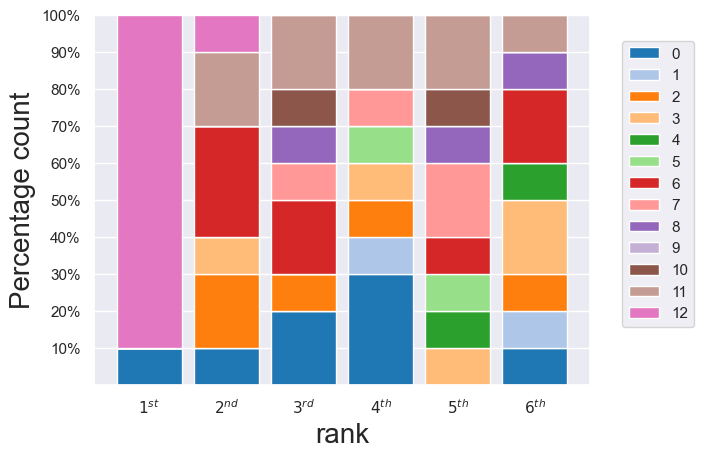

In [11]:
Local_importances = EDIFFI.Local_importances(X_test,True,True)
name = "Wine"
plt_importances_bars(Local_importances, name, pwd, dim,f=6)

### GFI 

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:42<00:00, 10.29s/it]


0     1     2     3     4     5     6     7     8     9     10    11  \
0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   10.0   0.0  10.0   0.0   0.0  10.0  30.0   0.0   0.0   0.0  10.0  30.0   
2   30.0   0.0  10.0   0.0   0.0  10.0  20.0   0.0   0.0   0.0  20.0  10.0   
3   10.0   0.0  20.0  20.0   0.0   0.0  20.0  20.0   0.0   0.0  10.0   0.0   
4   10.0   0.0   0.0  10.0  30.0  20.0   0.0   0.0  10.0  10.0   0.0  10.0   
5   20.0   0.0  10.0  10.0   0.0   0.0  10.0   0.0  10.0  10.0  20.0  10.0   
6   10.0  10.0  10.0  20.0   0.0  20.0  10.0   0.0  10.0  10.0   0.0   0.0   
7   10.0  10.0  10.0  20.0   0.0   0.0  10.0  10.0  10.0  10.0   0.0  10.0   
8    0.0   0.0  10.0   0.0  10.0  20.0   0.0  20.0  20.0  10.0  10.0   0.0   
9    0.0  20.0  10.0   0.0  20.0   0.0   0.0   0.0  30.0  10.0   0.0  10.0   
10   0.0  30.0  10.0  10.0   0.0  20.0   0.0  20.0   0.0  10.0   0.0   0.0   
11   0.0  10.0   0.0  10.0  10.0   0.0   0.0  20.0  10.0  10.0  20.0  10.0   
12   0.0  20.0   0.0   0.0  30.0   0.0   0.0  10.0   0.0  20.0  10.0  10.0   

       12  
0   100.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
5     0.0  
6     0.0  
7     0.0  
8     0.0  
9     0.0  
10    0.0  
11    0.0  
12    0.0

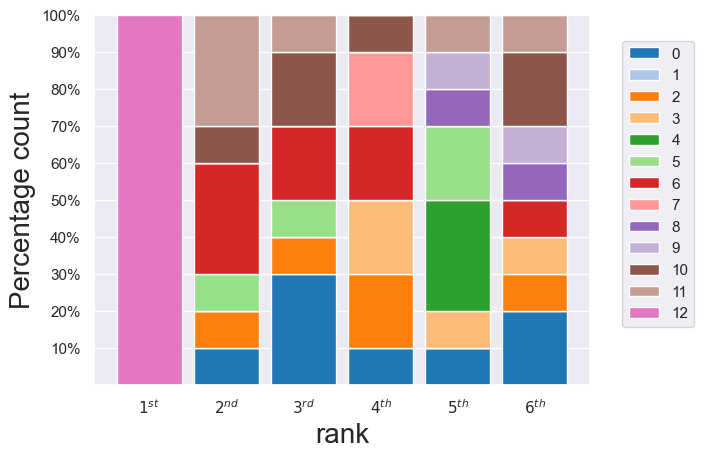

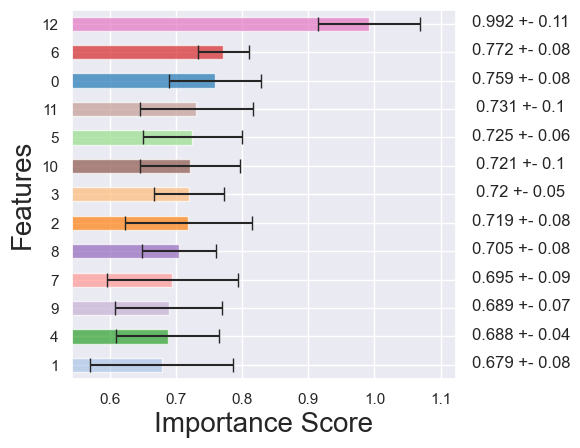

In [12]:
name='Wine'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

100%|██████████| 10/10 [02:45<00:00, 16.59s/it]


0     1     2     3     4     5     6     7     8     9     10    11  \
0   20.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   10.0   0.0   0.0  20.0  10.0   0.0   0.0   0.0  20.0  20.0   0.0   0.0   
2    0.0   0.0   0.0  40.0  20.0  10.0  20.0   0.0   0.0   0.0   0.0  10.0   
3   20.0   0.0  10.0  10.0   0.0   0.0  30.0   0.0  10.0  10.0   0.0  10.0   
4    0.0  10.0  20.0  10.0  10.0   0.0  10.0  10.0  10.0  10.0  10.0   0.0   
5   10.0   0.0  20.0   0.0  20.0  20.0   0.0   0.0  20.0   0.0   0.0  10.0   
6   10.0   0.0  30.0   0.0  10.0   0.0   0.0   0.0  10.0  10.0  10.0  20.0   
7   10.0   0.0   0.0   0.0  20.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0   
8    0.0  10.0   0.0  10.0   0.0  10.0   0.0  10.0  10.0   0.0  20.0  30.0   
9   20.0  10.0   0.0  10.0  10.0   0.0   0.0  20.0  10.0   0.0  10.0  10.0   
10   0.0  20.0   0.0   0.0   0.0  10.0  30.0  10.0   0.0  20.0  10.0   0.0   
11   0.0  10.0  20.0   0.0   0.0  30.0   0.0  20.0   0.0   0.0  20.0   0.0   
12   0.0  40.0   0.0   0.0   0.0  10.0   0.0  20.0   0.0  20.0  10.0   0.0   

      12  
0   80.0  
1   20.0  
2    0.0  
3    0.0  
4    0.0  
5    0.0  
6    0.0  
7    0.0  
8    0.0  
9    0.0  
10   0.0  
11   0.0  
12   0.0

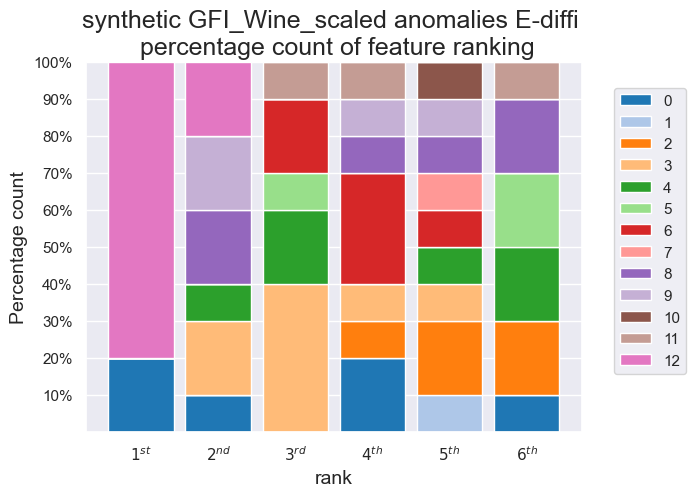

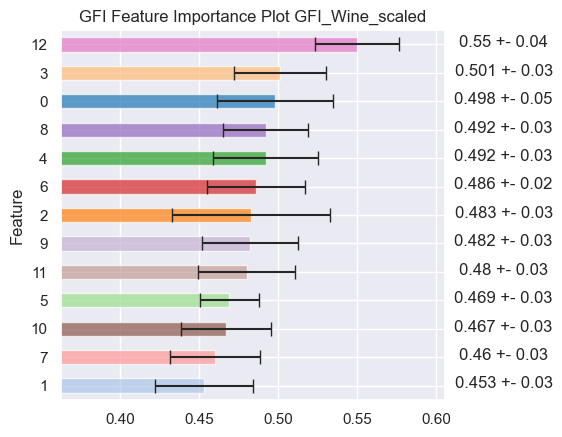

In [64]:
name='Wine_scaled'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

## Annthyroid

In [6]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data'

In [7]:
X,y=dataset('annthyroid',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

annthyroid 

[numero elementi = 7062]
[percentage outliers = 0.07561597281223449]
[number features = 6]
[number outliers = 534]
downsampled to 2500
(2500, 6)


In [8]:
N = X.shape[0]
dim = X.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10
p = sum(y)/len(y)

In [9]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI'

In [10]:
pwd = os.getcwd()
dim = X.shape[1]

In [11]:
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size,plus=1)
EDIFFI.fit(X_train)
#X_train,X_test=partition_data(X,y)

### LFI 

0          1          2          3          4          5
0   1.058201  95.767196   2.645503   0.000000   0.000000   0.529101
1  13.227513   3.174603  22.222222  11.640212   3.174603  46.560847
2  14.814815   0.000000  19.047619  30.158730  10.052910  25.925926
3  25.925926   0.529101  21.693122  15.873016  16.402116  19.576720
4  25.396825   0.529101  16.931217  21.693122  30.158730   5.291005
5  19.576720   0.000000  17.460317  20.634921  40.211640   2.116402

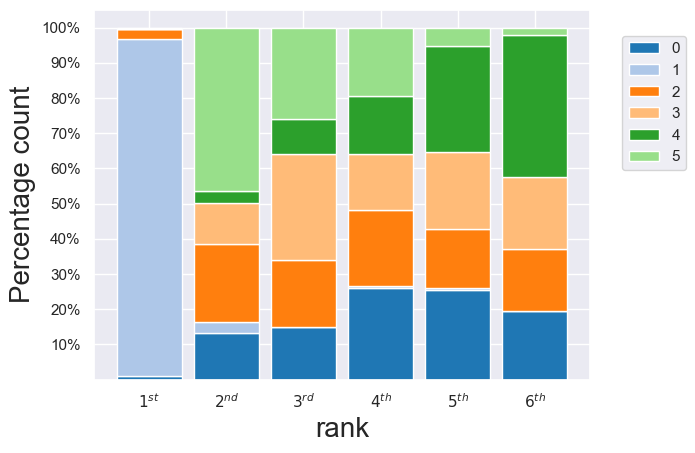

In [12]:
Local_importances = EDIFFI.Local_importances(X_test,True,True)
name = 'Annthyroid'
plt_importances_bars(Local_importances, name, pwd, dim,f=6)

### GFI 

100%|██████████| 10/10 [30:09<00:00, 180.96s/it]


0      1     2     3     4     5
0   0.0  100.0   0.0   0.0   0.0   0.0
1   0.0    0.0  40.0  20.0  10.0  30.0
2   0.0    0.0  20.0  50.0  10.0  20.0
3   0.0    0.0  40.0  20.0   0.0  40.0
4  10.0    0.0   0.0  10.0  70.0  10.0
5  90.0    0.0   0.0   0.0  10.0   0.0

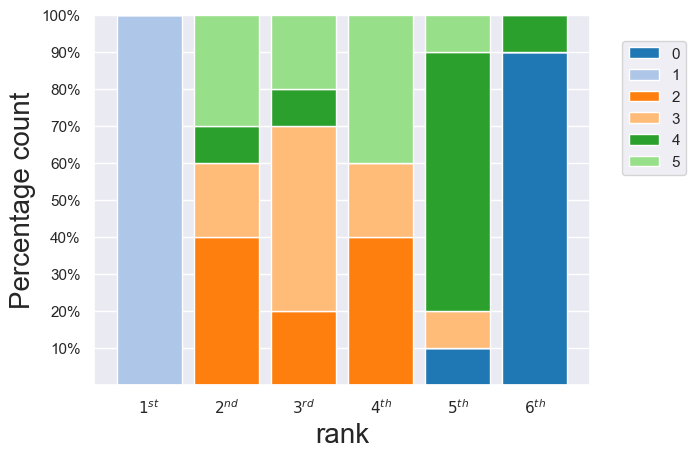

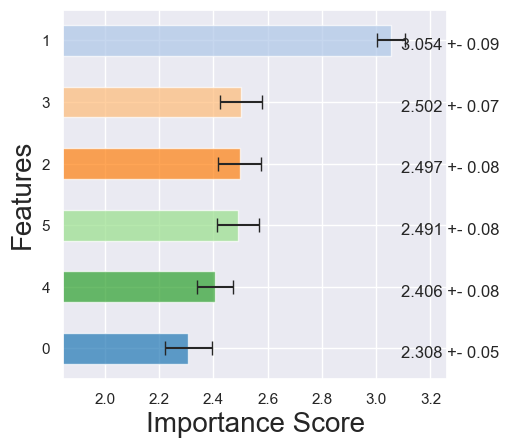

In [13]:
name='Annthyroid'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

## Breastw

In [22]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data'

In [23]:
X,y=dataset('breastw',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

breastw 

[numero elementi = 449]
[percentage outliers = 0.5256124721603563]
[number features = 9]
[number outliers = 236]


Subsample

Take only 45 anomalies from the test set. In this way the percentage of outliers reduces to 10%. 

In [24]:
ind=np.random.choice(np.arange(X_test.shape[0]),int(X.shape[0]*0.1))
X_test=X_test[ind,:]
X_test.shape

(44, 9)

In [25]:
N = X.shape[0]
dim = X.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10
p = sum(y)/len(y)

In [26]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI'

In [27]:
pwd = os.getcwd()
dim = X.shape[1]

In [28]:
pwd = os.getcwd()
dim = X.shape[1]
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size,plus=1)
EDIFFI.fit(X_train)

### LFI 

0          1          2          3          4          5  \
0  20.454545   4.545455   4.545455  13.636364   4.545455  13.636364   
1  11.363636  13.636364   4.545455  15.909091   2.272727  27.272727   
2  11.363636  20.454545  13.636364  11.363636   4.545455  11.363636   
3   9.090909   6.818182  11.363636   6.818182  15.909091   9.090909   
4  11.363636  13.636364  13.636364  18.181818   6.818182   6.818182   
5   6.818182   9.090909  11.363636  15.909091  20.454545   9.090909   
6  15.909091  11.363636   2.272727  13.636364  13.636364   9.090909   
7   2.272727   9.090909  15.909091   4.545455  13.636364   9.090909   
8  11.363636  11.363636  22.727273   0.000000  18.181818   4.545455   

           6          7          8  
0   4.545455  25.000000   9.090909  
1   2.272727  18.181818   4.545455  
2   4.545455  13.636364   9.090909  
3  11.363636   9.090909  20.454545  
4   9.090909   6.818182  13.636364  
5   9.090909   6.818182  11.363636  
6  11.363636  11.363636  11.363636  
7  27.272727   9.090909   9.090909  
8  20.454545   0.000000  11.363636

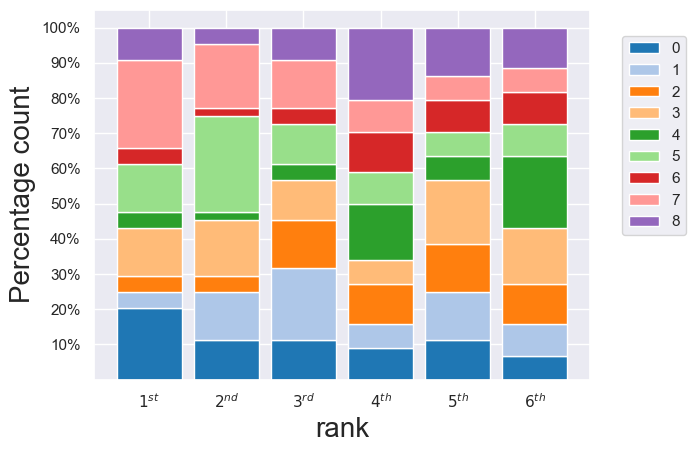

In [29]:
Local_importances = EDIFFI.Local_importances(X_test,True,True)
name = 'Breast_subsample_scaled'
plt_importances_bars(Local_importances, name, pwd, dim,f=6)

### GFI

100%|██████████| 10/10 [02:59<00:00, 17.92s/it]


0     1     2     3     4     5     6     7     8
0   0.0  50.0  10.0  10.0  10.0   0.0   0.0   0.0  20.0
1  10.0  20.0  10.0   0.0   0.0  10.0  40.0   0.0  10.0
2  10.0   0.0  10.0   0.0  20.0   0.0  10.0  30.0  20.0
3  10.0  10.0   0.0  30.0  10.0  20.0  10.0   0.0  10.0
4  20.0  10.0  10.0  10.0  10.0  10.0   0.0  20.0  10.0
5  20.0   0.0  20.0  10.0   0.0  20.0  30.0   0.0   0.0
6  20.0  10.0   0.0  10.0  10.0  10.0  10.0  30.0   0.0
7  10.0   0.0  20.0  10.0   0.0  10.0   0.0  20.0  30.0
8   0.0   0.0  20.0  20.0  40.0  20.0   0.0   0.0   0.0

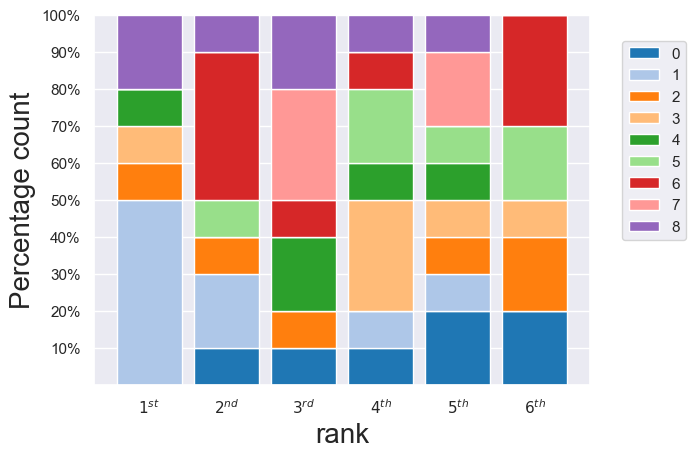

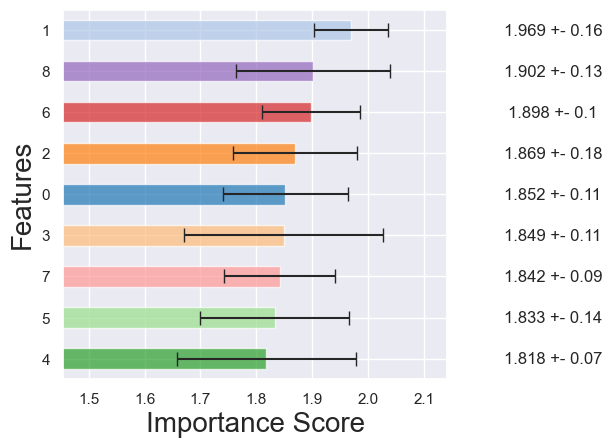

In [30]:
name='Breast'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

## Pima

In [31]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data'

In [32]:
X,y=dataset('pima',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

pima 

[numero elementi = 768]
[percentage outliers = 0.3489583333333333]
[number features = 8]
[number outliers = 268]


Subsample

In [33]:
ind=np.random.choice(np.arange(X_test.shape[0]),int(X.shape[0]*0.1))
X_test=X_test[ind,:]
X_test.shape

(76, 8)

In [34]:
N = X.shape[0]
dim = X.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10
p = sum(y)/len(y)

In [36]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()
pwd = os.getcwd()
dim = X.shape[1]
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size,plus=1)
EDIFFI.fit(X_train)

### LFI 

0          1          2          3          4          5  \
0  13.157895  28.947368   5.263158   9.210526  10.526316  10.526316   
1  14.473684  15.789474   6.578947  14.473684  21.052632   7.894737   
2  26.315789   7.894737   6.578947  11.842105   9.210526  13.157895   
3  11.842105   5.263158  11.842105   7.894737  17.105263  22.368421   
4  14.473684   9.210526  11.842105  14.473684  11.842105   9.210526   
5  10.526316  14.473684  21.052632  17.105263   7.894737  10.526316   
6   2.631579  13.157895  21.052632   5.263158  14.473684  15.789474   
7   6.578947   5.263158  15.789474  19.736842   7.894737  10.526316   

           6          7  
0  17.105263   5.263158  
1  13.157895   6.578947  
2  10.526316  14.473684  
3  10.526316  13.157895  
4  15.789474  13.157895  
5   9.210526   9.210526  
6   6.578947  21.052632  
7  17.105263  17.105263

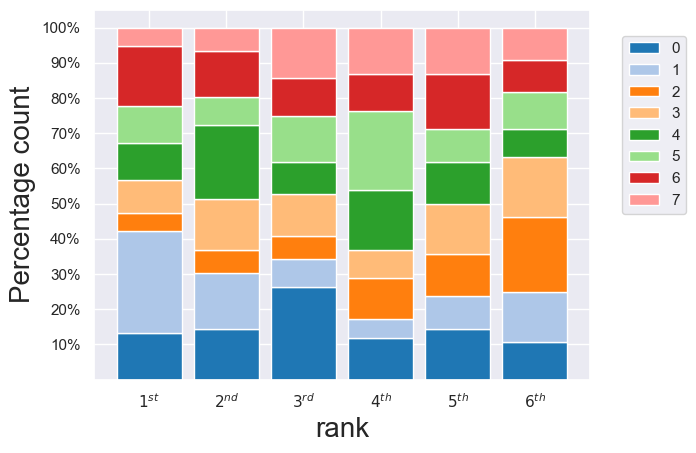

In [37]:
Local_importances = EDIFFI.Local_importances(X_test,True,True)
name = 'Pima'
plt_importances_bars(Local_importances, name, pwd, dim,f=6)

### GFI

100%|██████████| 10/10 [04:24<00:00, 26.45s/it]


0     1     2     3     4     5     6     7
0   0.0  50.0  10.0   0.0   0.0  30.0  10.0   0.0
1   0.0  10.0  40.0   0.0  30.0  20.0   0.0   0.0
2   0.0  40.0  10.0  10.0  10.0  20.0  10.0   0.0
3   0.0   0.0  30.0   0.0  30.0  20.0  20.0   0.0
4  10.0   0.0  10.0   0.0  30.0  10.0  30.0  10.0
5  10.0   0.0   0.0  40.0   0.0   0.0  30.0  20.0
6  30.0   0.0   0.0  30.0   0.0   0.0   0.0  40.0
7  50.0   0.0   0.0  20.0   0.0   0.0   0.0  30.0

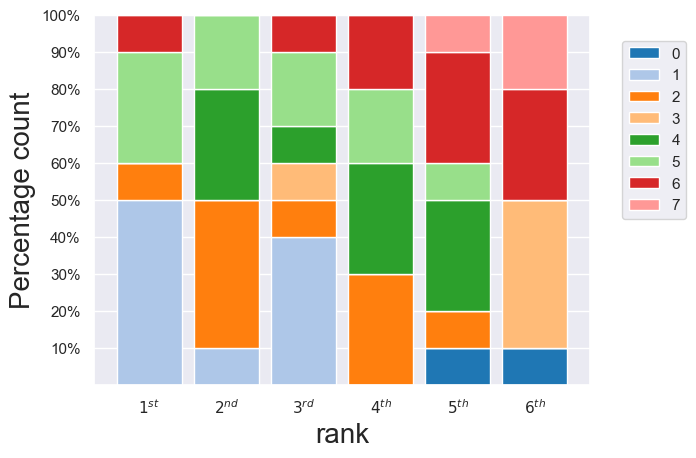

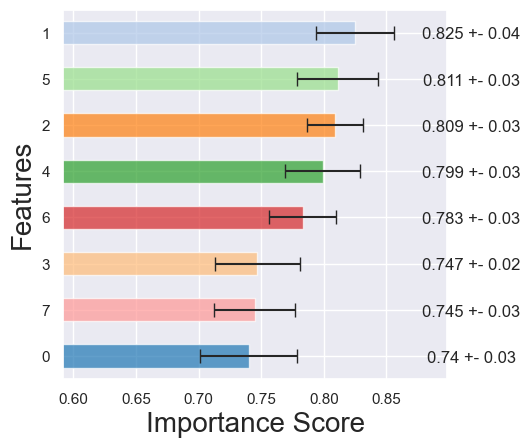

In [38]:
name='Pima'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

## Cardio 

In [5]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data'

In [19]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
X,y=dataset('cardio',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

cardio 

[numero elementi = 1822]
[percentage outliers = 0.09604829857299671]
[number features = 21]
[number outliers = 175]


In [7]:
N = X.shape[0]
dim = X.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10
p = sum(y)/len(y)

In [8]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
pwd = os.getcwd()
dim = X.shape[1]
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size,plus=1)
EDIFFI.fit(X_train)

### LFI 

0         1          2          3         4          5          6   \
0   1.142857  0.000000   3.428571   5.142857  2.285714   0.000000  38.857143   
1   5.142857  1.142857   1.714286   3.428571  2.857143   0.571429   4.571429   
2   9.142857  2.285714   1.714286   5.714286  5.714286   2.857143   5.142857   
3   9.142857  0.571429   3.428571   4.000000  6.285714   2.285714   0.000000   
4   5.714286  1.714286   2.857143  10.285714  5.714286   0.571429   0.571429   
5   9.142857  2.285714   2.285714   5.714286  8.000000   3.428571   1.142857   
6   7.428571  1.714286   6.285714   6.285714  8.571429   5.714286   0.571429   
7   4.571429  4.571429   8.000000   8.000000  5.142857   4.571429   1.714286   
8   8.000000  5.142857   8.000000   6.285714  4.000000   5.142857   1.714286   
9   5.142857  2.857143  10.857143   6.857143  4.571429  12.000000   1.714286   
10  6.857143  6.285714   2.285714   3.428571  3.428571   6.285714   1.142857   
11  5.714286  7.428571   6.285714   5.142857  4.000000   5.142857   4.000000   
12  4.000000  5.714286   2.285714   4.000000  7.428571   7.428571   2.857143   
13  1.714286  6.857143   1.714286   1.714286  3.428571   2.857143   1.714286   
14  4.000000  7.428571   6.285714   4.000000  3.428571   5.142857   2.857143   
15  2.857143  5.142857   6.285714   3.428571  6.285714   6.285714   2.857143   
16  4.000000  7.428571   4.571429   1.714286  4.571429  11.428571   6.857143   
17  1.142857  8.571429   4.571429   4.571429  4.000000   5.714286   6.285714   
18  3.428571  6.285714   5.142857   1.714286  4.000000   4.000000   4.571429   
19  0.571429  8.571429   4.571429   2.857143  5.142857   6.285714   5.142857   
20  1.142857  8.000000   7.428571   5.714286  1.142857   2.285714   5.714286   

          7          8          9   ...        11         12         13  \
0   0.571429   8.000000  25.714286  ...  1.142857   1.142857   1.714286   
1   5.714286  18.857143  18.857143  ...  1.142857   8.000000   1.714286   
2   5.714286   9.714286   7.428571  ...  1.142857  13.714286   2.285714   
3   6.285714   1.142857   8.000000  ...  9.714286   8.000000  10.857143   
4   5.714286   1.142857   4.571429  ...  4.000000   5.142857   8.000000   
5   6.285714   0.571429   3.428571  ...  7.428571   8.000000   2.857143   
6   4.571429   0.571429   1.714286  ...  7.428571   1.714286   9.714286   
7   6.285714   1.714286   3.428571  ...  5.714286   5.142857   4.571429   
8   4.571429   2.285714   2.857143  ...  4.571429   4.000000   5.714286   
9   4.571429   3.428571   2.285714  ...  3.428571   4.571429   2.857143   
10  6.857143   2.857143   2.285714  ...  4.000000   2.857143   5.142857   
11  5.714286   3.428571   2.285714  ...  5.714286   3.428571   4.000000   
12  8.571429   5.714286   0.571429  ...  6.285714   2.285714   3.428571   
13  4.000000   4.000000   4.571429  ...  5.714286   6.285714   4.000000   
14  4.000000   2.857143   1.142857  ...  4.000000   6.857143   4.571429   
15  5.142857   4.571429   5.714286  ...  4.571429   5.142857   2.857143   
16  3.428571   3.428571   1.714286  ...  4.571429   2.857143   6.857143   
17  4.000000   6.857143   0.571429  ...  1.714286   2.857143   5.714286   
18  4.571429   6.857143   1.142857  ...  6.857143   3.428571   3.428571   
19  1.714286   9.142857   0.000000  ...  4.000000   2.857143   6.857143   
20  1.714286   2.857143   1.714286  ...  6.857143   1.714286   2.857143   

           14        15         16        17        18        19         20  
0    0.000000  2.857143   1.714286  0.000000  1.714286  2.857143   1.714286  
1    0.571429  9.714286   1.142857  2.857143  3.428571  2.857143   2.285714  
2    0.571429  5.714286   1.714286  5.714286  9.142857  2.285714   1.714286  
3    2.285714  6.857143   1.714286  7.428571  2.285714  2.857143   4.000000  
4    2.857143  5.142857   2.857143  6.285714  6.857143  6.285714   6.857143  
5    1.142857  5.714286   4.571429  4.571429  7.428571  6.857143   5.714286  
6    2.857143  4.571429   2.857143  4.000000  4.0000

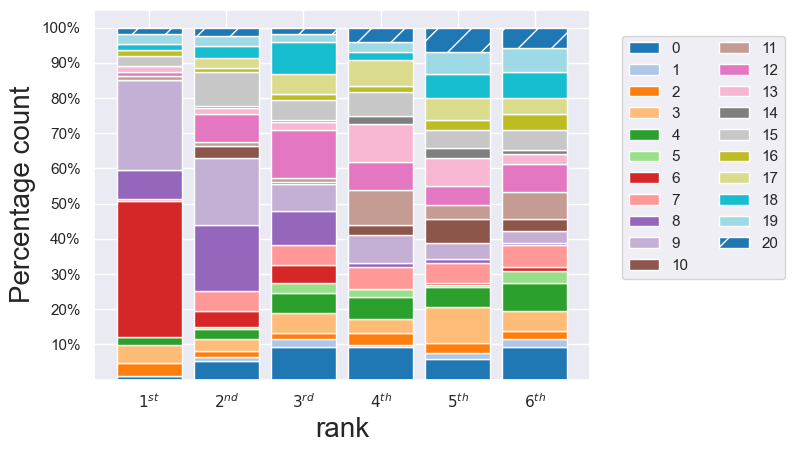

In [9]:
Local_importances = EDIFFI.Local_importances(X_test,True,True)
name = 'Cardio'
plt_importances_bars(Local_importances, name, pwd, dim,f=6)

### GFI 

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [09:29<00:00, 56.93s/it]


0     1     2     3     4     5      6     7     8     9   ...    11  \
0    0.0   0.0   0.0   0.0   0.0   0.0  100.0   0.0   0.0   0.0  ...   0.0   
1    0.0   0.0   0.0   0.0   0.0  10.0    0.0   0.0  10.0  30.0  ...  10.0   
2    0.0   0.0   0.0   0.0   0.0  10.0    0.0   0.0   0.0   0.0  ...  10.0   
3   10.0  10.0   0.0   0.0   0.0  20.0    0.0   0.0  10.0  30.0  ...   0.0   
4   10.0   0.0  20.0   0.0  10.0  10.0    0.0   0.0   0.0  10.0  ...   0.0   
5    0.0   0.0  10.0   0.0  10.0  10.0    0.0   0.0  10.0  20.0  ...  10.0   
6   20.0   0.0   0.0  20.0   0.0   0.0    0.0  20.0   0.0   0.0  ...   0.0   
7   10.0   0.0  30.0  10.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   0.0   
8    0.0   0.0  10.0   0.0   0.0   0.0    0.0   0.0  10.0   0.0  ...   0.0   
9   10.0   0.0  10.0  30.0   0.0   0.0    0.0   0.0  10.0   0.0  ...  10.0   
10   0.0  10.0   0.0   0.0  10.0   0.0    0.0   0.0  10.0   0.0  ...  20.0   
11   0.0   0.0  10.0  10.0   0.0   0.0    0.0  10.0   0.0   0.0  ...  10.0   
12   0.0  20.0   0.0  20.0   0.0  10.0    0.0   0.0   0.0   0.0  ...   0.0   
13  10.0   0.0   0.0   0.0   0.0  10.0    0.0  10.0   0.0   0.0  ...   0.0   
14  10.0  10.0   0.0   0.0  10.0  10.0    0.0  20.0  10.0   0.0  ...   0.0   
15   0.0   0.0   0.0   0.0   0.0  10.0    0.0   0.0  20.0  10.0  ...   0.0   
16  10.0  30.0   0.0   0.0   0.0   0.0    0.0  10.0  10.0   0.0  ...   0.0   
17   0.0   0.0   0.0  10.0  20.0   0.0    0.0  20.0   0.0   0.0  ...  10.0   
18   0.0  10.0  10.0   0.0  20.0   0.0    0.0  10.0   0.0   0.0  ...  10.0   
19  10.0   0.0   0.0   0.0  10.0   0.0    0.0   0.0   0.0   0.0  ...  10.0   
20   0.0  10.0   0.0   0.0  10.0   0.0    0.0   0.0   0.0   0.0  ...   0.0   

      12    13    14    15    16    17    18    19    20  
0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   10.0   0.0   0.0   0.0  10.0   0.0   0.0  20.0   0.0  
2   20.0   0.0   0.0  20.0   0.0  20.0  10.0  10.0   0.0  
3    0.0   0.0   0.0   0.0   0.0  20.0   0.0   0.0   0.0  
4    0.0   0.0  10.0   0.0  20.0   0.0  10.0   0.0   0.0  
5    0.0   0.0  10.0  10.0   0.0   0.0  10.0   0.0   0.0  
6    0.0  10.0  10.0   0.0  10.0  10.0   0.0   0.0   0.0  
7   20.0  20.0   0.0   0.0   0.0   0.0   0.0  10.0   0.0  
8    0.0  10.0  10.0   0.0  20.0   0.0  10.0   0.0  20.0  
9    0.0   0.0   0.0   0.0   0.0   0.0   0.0  10.0   0.0  
10  10.0   0.0   0.0   0.0  20.0  10.0   0.0   0.0   0.0  
11   0.0  10.0  10.0   0.0   0.0   0.0  20.0  10.0   0.0  
12  10.0   0.0   0.0   0.0  10.0  10.0  20.0   0.0   0.0  
13  20.0   0.0  10.0   0.0   0.0   0.0   0.0   0.0  20.0  
14   0.0  10.0   0.0   0.0   0.0   0.0   0.0  10.0  10.0  
15   0.0  10.0   0.0  20.0   0.0  10.0   0.0  10.0   0.0  
16   0.0   0.0   0.0  10.0   0.0  10.0  10.0   0.0  10.0  
17  10.0   0.0  10.0  10.0   0.0  10.0   0.0   0.0   0.0  
18   0.0  10.0  20.0   0.0  10.0   0.0   0.0   0.0   0.0  
19   0.0   0.0  10.0  30.0   0.0   0.0   0.0  20.0   0.0  
20   0.0  20.0   0.0   0.0   0.0   0.0  10.0   0.0  40.0  

[21 rows x 21 columns]

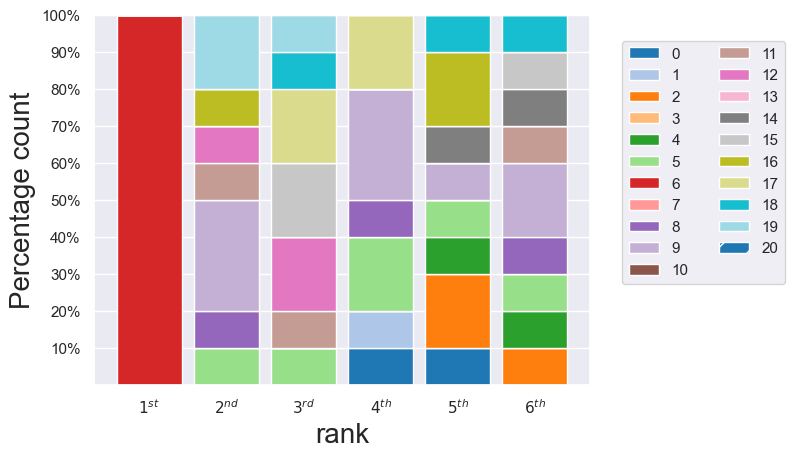

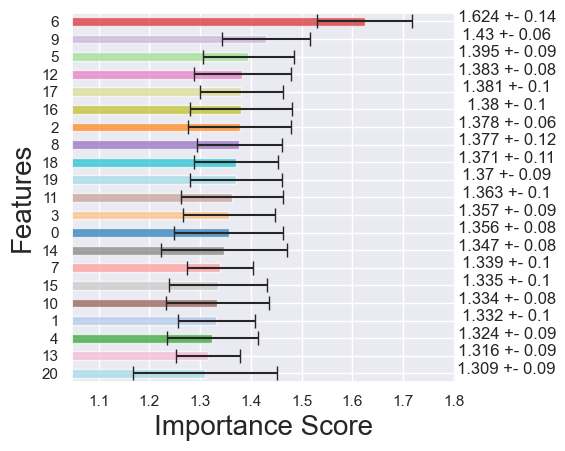

In [10]:
name='Cardio'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

## Ionosphere 

In [42]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
X,y=dataset('ionosphere',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

ionosphere 

[numero elementi = 350]
[percentage outliers = 0.35714285714285715]
[number features = 33]
[number outliers = 125]


Subsample

In [31]:
ind=np.random.choice(np.arange(X_test.shape[0]),int(X.shape[0]*0.1))
X_test=X_test[ind,:]
X_test.shape

(35, 33)

In [118]:
N = X.shape[0]
dim = X.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10
p = sum(y)/len(y)

In [119]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()
pwd = os.getcwd()
dim = X.shape[1]
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size,plus=1)
EDIFFI.fit(X_train)

### LFI 

0          1         2          3          4          5          6   \
0   0.000000  20.000000  0.000000  22.857143   2.857143   0.000000   2.857143   
1   0.000000  20.000000  0.000000   5.714286   0.000000   0.000000  14.285714   
2   5.714286   0.000000  0.000000   5.714286   0.000000   2.857143   0.000000   
3   2.857143   0.000000  2.857143  11.428571   5.714286   0.000000   5.714286   
4   0.000000   0.000000  0.000000   2.857143   0.000000  17.142857   5.714286   
5   0.000000   0.000000  5.714286   2.857143   2.857143   2.857143   2.857143   
6   2.857143   0.000000  2.857143   8.571429   0.000000   5.714286   5.714286   
7   2.857143   2.857143  0.000000   0.000000   0.000000   5.714286  14.285714   
8   0.000000   0.000000  5.714286   5.714286  17.142857   0.000000   8.571429   
9   0.000000   2.857143  8.571429   2.857143   2.857143   0.000000   5.714286   
10  5.714286   5.714286  0.000000   0.000000   0.000000   0.000000   0.000000   
11  5.714286   2.857143  0.000000   2.857143   0.000000   8.571429   2.857143   
12  0.000000   5.714286  2.857143   0.000000   2.857143   2.857143   2.857143   
13  8.571429   2.857143  0.000000   0.000000   5.714286   2.857143   2.857143   
14  0.000000   5.714286  0.000000   0.000000   8.571429   2.857143   0.000000   
15  8.571429   0.000000  8.571429   5.714286   5.714286   8.571429   0.000000   
16  0.000000   5.714286  0.000000   0.000000   0.000000   0.000000   0.000000   
17  5.714286   0.000000  5.714286   0.000000   0.000000   0.000000   0.000000   
18  5.714286   2.857143  0.000000   5.714286   2.857143   0.000000   0.000000   
19  0.000000   5.714286  2.857143   0.000000   0.000000   0.000000   8.571429   
20  2.857143   0.000000  5.714286   0.000000   2.857143   2.857143   2.857143   
21  2.857143   0.000000  2.857143   0.000000   8.571429   5.714286   5.714286   
22  2.857143   0.000000  5.714286   0.000000   2.857143   2.857143   0.000000   
23  5.714286   0.000000  5.714286   0.000000   2.857143   0.000000   2.857143   
24  5.714286   0.000000  0.000000   2.857143   2.857143   8.571429   0.000000   
25  0.000000   0.000000  8.571429   0.000000   2.857143   0.000000   0.000000   
26  0.000000   2.857143  8.571429   0.000000   0.000000   0.000000   2.857143   
27  0.000000   0.000000  0.000000   2.857143   0.000000   2.857143   0.000000   
28  2.857143   5.714286  5.714286   2.857143   0.000000   0.000000   0.000000   
29  5.714286   5.714286  0.000000   2.857143   5.714286   5.714286   0.000000   
30  0.000000   0.000000  2.857143   0.000000   5.714286   5.714286   0.000000   
31  8.571429   0.000000  5.714286   0.000000   8.571429   5.714286   0.000000   
32  8.571429   2.857143  2.857143   5.714286   0.000000   0.000000   2.857143   

          7          8          9   ...        23        24         25  \
0   0.000000   0.000000   0.000000  ...  0.000000  0.000000   0.000000   
1   2.857143   2.857143   8.571429  ...  5.714286  0.000000   0.000000   
2   5.714286   0.000000   5.714286  ...  5.714286  0.000000   0.000000   
3   2.857143   0.000000   5.714286  ...  0.000000  0.000000   0.000000   
4   0.000000   2.857143   2.857143  ...  0.000000  2.857143   0.000000   
5   0.000000   0.000000   2.857143  ...  2.857143  2.857143   0.000000   
6   0.000000   2.857143   5.714286  ...  0.000000  5.714286   0.000000   
7   2.857143   0.000000   2.857143  ...  0.000000  2.857143   0.000000   
8   0.000000   0.000000   0.000000  ...  0.000000  2.857143   5.714286   
9   2.857143   5.714286   0.000000  ...  5.714286  5.714286   0.000000   
10  0.000000   0.000000   2.857143  ...  2.857143  8.571429   2.857143   
11  2.857143   0.000000   2.857143  ...  0.000000  0.000000   0.000000   
12  0.000000   8.571429   2.857143  ...  0.000000  0.000000   2.857143   
13  0.000000   0.000000   2.857143  ...  5.714286  8.571429   0.000000   
14  8.571429   5.714286  11.428571  ...  0.000000  8.571429   0.000000   
15  0.000000   5.714286   2.857143  ...  0.000000  0.000000   0.000000 

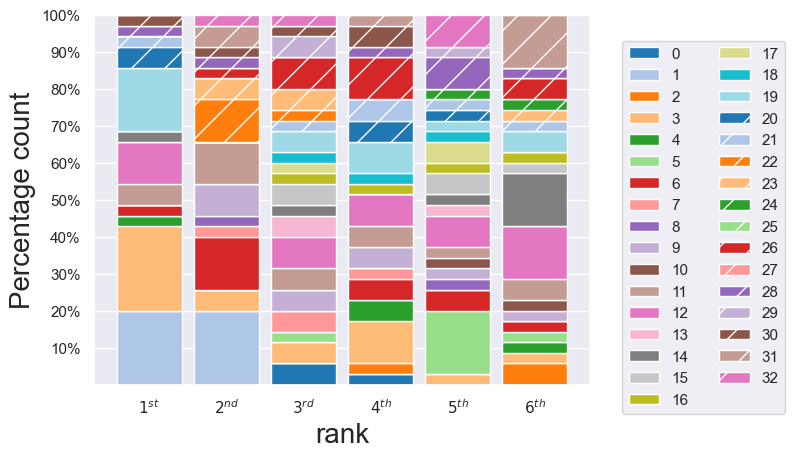

In [120]:
Local_importances = EDIFFI.Local_importances(X_test,True,True)
name = 'Ionosphere'
plt_importances_bars(Local_importances, name, pwd, dim,f=6)

### GFI 

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [03:20<00:00, 20.00s/it]


0     1     2     3     4     5     6     7     8     9   ...    23  \
0    0.0  20.0   0.0  60.0   0.0   0.0  10.0   0.0   0.0   0.0  ...   0.0   
1    0.0   0.0   0.0  30.0   0.0  10.0   0.0   0.0  10.0  10.0  ...   0.0   
2    0.0   0.0  10.0   0.0  10.0   0.0  10.0   0.0   0.0  10.0  ...  20.0   
3    0.0  10.0   0.0   0.0   0.0   0.0   0.0  20.0  10.0   0.0  ...   0.0   
4    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
5    0.0   0.0   0.0   0.0   0.0   0.0   0.0  10.0   0.0   0.0  ...   0.0   
6    0.0   0.0  10.0  10.0   0.0  10.0   0.0   0.0   0.0   0.0  ...   0.0   
7   10.0  10.0  10.0   0.0  20.0   0.0   0.0   0.0  10.0   0.0  ...  10.0   
8    0.0   0.0  10.0   0.0   0.0   0.0   0.0   0.0  10.0   0.0  ...   0.0   
9    0.0  10.0   0.0   0.0   0.0   0.0  10.0   0.0   0.0   0.0  ...   0.0   
10  20.0   0.0   0.0   0.0  10.0  10.0   0.0  10.0   0.0   0.0  ...  10.0   
11  20.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  10.0   
12   0.0   0.0  10.0   0.0   0.0  30.0  10.0   0.0   0.0   0.0  ...   0.0   
13   0.0  10.0   0.0   0.0  10.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
14   0.0   0.0  10.0   0.0  10.0   0.0  10.0  20.0   0.0  10.0  ...   0.0   
15  10.0   0.0  20.0   0.0  10.0   0.0   0.0  20.0   0.0   0.0  ...   0.0   
16   0.0   0.0   0.0   0.0   0.0  10.0   0.0   0.0  20.0   0.0  ...   0.0   
17   0.0  10.0   0.0   0.0   0.0   0.0   0.0   0.0  10.0   0.0  ...   0.0   
18   0.0   0.0   0.0   0.0  10.0   0.0   0.0   0.0   0.0  10.0  ...   0.0   
19  10.0   0.0   0.0   0.0   0.0  10.0   0.0  10.0   0.0  20.0  ...  20.0   
20   0.0   0.0   0.0   0.0   0.0  10.0   0.0   0.0   0.0   0.0  ...   0.0   
21   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  20.0   
22  10.0  10.0   0.0   0.0   0.0   0.0   0.0  10.0   0.0   0.0  ...   0.0   
23   0.0   0.0  10.0   0.0   0.0   0.0   0.0   0.0  10.0   0.0  ...   0.0   
24   0.0   0.0   0.0   0.0   0.0   0.0  20.0   0.0   0.0  10.0  ...   0.0   
25   0.0   0.0   0.0   0.0   0.0   0.0  10.0   0.0   0.0  10.0  ...   0.0   
26   0.0   0.0  10.0   0.0   0.0   0.0   0.0   0.0  10.0   0.0  ...   0.0   
27  20.0  10.0   0.0   0.0  10.0  10.0   0.0   0.0   0.0   0.0  ...   0.0   
28   0.0   0.0   0.0   0.0  10.0   0.0  10.0   0.0   0.0  10.0  ...   0.0   
29   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
30   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  10.0   
31   0.0  10.0   0.0   0.0   0.0   0.0  10.0   0.0  10.0  10.0  ...   0.0   
32   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      24    25    26    27    28    29    30    31    32  
0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1    0.0   0.0  10.0  10.0   0.0   0.0  10.0   0.0   0.0  
2    0.0   0.0   0.0   0.0   0.0   0.0   0.0  10.0   0.0  
3    0.0   0.0  10.0  20.0   0.0   0.0   0.0   0.0   0.0  
4   10.0  10.0   0.0   0.0   0.0   0.0  20.0   0.0   0.0  
5   10.0  30.0   0.0   0.0  10.0  10.0   0.0   0.0   0.0  
6    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  20.0  
7    0.0   0.0   0.0   0.0   0.0   0.0  10.0   0.0   0.0  
8    0.0  10.0   0.0   0.0   0.0   0.0   0.0  20.0   0.0  
9    0.0   0.0   0.0  30.0  10.0   0.0   0.0   0.0   0.0  
10  10.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
11   0.0   0.0  10.0   0.0  10.0  10.0   0.0   0.0   0.0  
12  10.0   0.0   0.0   0.0   0.0  10.0   0.0   0.0   0.0  
13  10.0   0.0   0.0  10.0  10.0   0.0  10.0   0.0  10.0  
14   0.0   0.0  10.0   0.0  10.0   0.0   0.0  10.0   0.0  
15   0.0   0.0   0.0   0.0  10.0   0.0   0.0   0.0   0.0  
16   0.0   0.0   0.0   0.0   0.0   0.0   0.0  10.0   0.0  
17   0.0   0.0   0.0  10.0  10.0  10.0   0.0   0.0   0.0  
18  10.0  20.0   0.0   0.0   0.0   0.0   0.0   0.0  10.0  
19   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
20   0.0  10.0   0.0   0.0   0.0  10.0   0.0   0.0  10.0  
21  10.0   0.0   0.0   0.0   0.0   0.0  10.0   0.0   0.0  
22  10.0   0.0   0.0  10.0   0

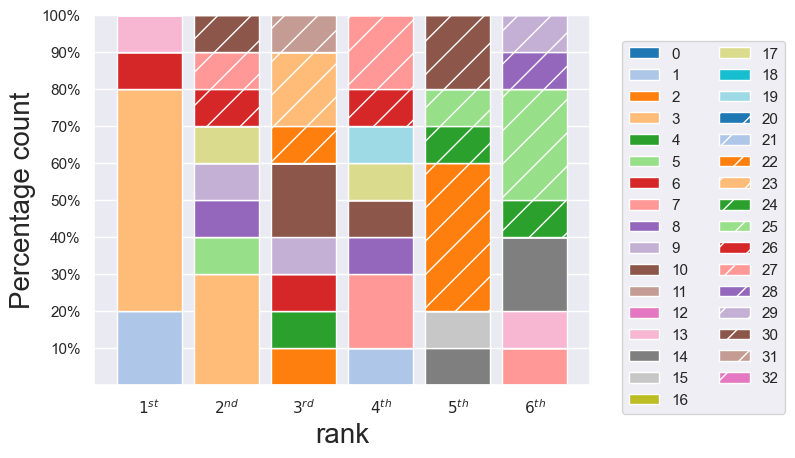

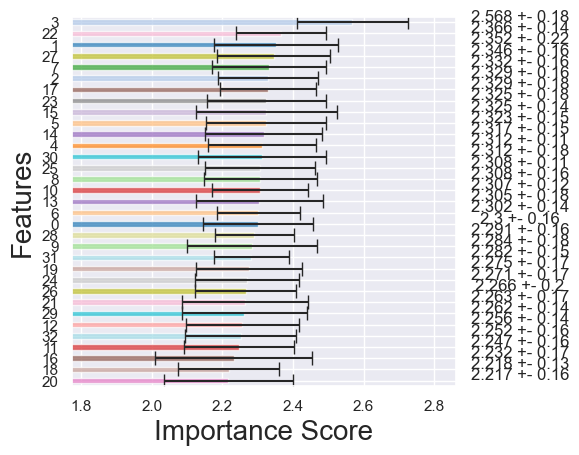

In [121]:
name='Ionosphere'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

In [58]:
color=plt.cm.get_cmap('tab20',33).colors
color=color[np.array(df_ionosphere['feat_order'])-1]

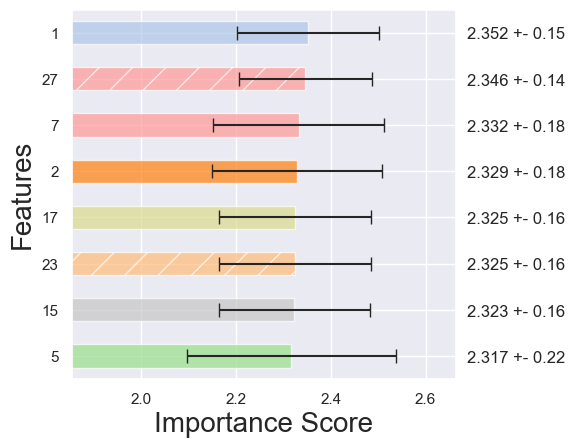

In [65]:
''' 
df_ionosphere={
    'Importances':np.array([2.568,2.366,2.352,2.346,2.332,2.329,2.325,2.325,2.323,2.317][::-1]),
    'feat_order':[3,22,1,27,7,2,17,23,15,5][::-1],
    'std':[0.18,0.14,0.22,0.16,0.16,0.16,0.18,0.18,0.14,0.15]
}
'''
df_ionosphere={
    'Importances':np.array([2.352,2.346,2.332,2.329,2.325,2.325,2.323,2.317][::-1]),
    'feat_order':[1,27,7,2,17,23,15,5][::-1],
    'std':[0.22,0.16,0.16,0.16,0.18,0.18,0.14,0.15]
}
plt_feat_bar_plot(df_ionosphere,X,'ionosphere',pwd,f=6)

## Glass 

In [91]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
X,y=dataset('glass',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

glass 

[numero elementi = 213]
[percentage outliers = 0.04225352112676056]
[number features = 9]
[number outliers = 9]


Subsample

In [92]:
ind=np.random.choice(np.arange(X_test.shape[0]),int(X.shape[0]*0.1))
X_test=X_test[ind,:]
X_test.shape

(21, 9)

In [93]:
N = X.shape[0]
dim = X.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10
p = sum(y)/len(y)

In [94]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()
pwd = os.getcwd()
dim = X.shape[1]
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size,plus=1)
EDIFFI.fit(X_train)

### LFI 

0          1          2          3          4          5  \
0   0.000000  52.380952   0.000000  19.047619   0.000000  19.047619   
1   0.000000   0.000000  66.666667  14.285714   0.000000   0.000000   
2  19.047619   9.523810   0.000000  47.619048   9.523810   0.000000   
3   0.000000   0.000000   0.000000   0.000000   0.000000  52.380952   
4   0.000000   0.000000   0.000000   9.523810   0.000000   0.000000   
5  47.619048  19.047619   0.000000   0.000000   0.000000  19.047619   
6  33.333333   0.000000   0.000000   9.523810   0.000000   9.523810   
7   0.000000  19.047619  33.333333   0.000000  38.095238   0.000000   
8   0.000000   0.000000   0.000000   0.000000  52.380952   0.000000   

           6          7          8  
0   9.523810   0.000000   0.000000  
1   0.000000   0.000000  19.047619  
2   4.761905   0.000000   9.523810  
3   9.523810  38.095238   0.000000  
4  66.666667  23.809524   0.000000  
5   9.523810   0.000000   4.761905  
6   0.000000  28.571429  19.047619  
7   0.000000   0.000000   9.523810  
8   0.000000   9.523810  38.095238

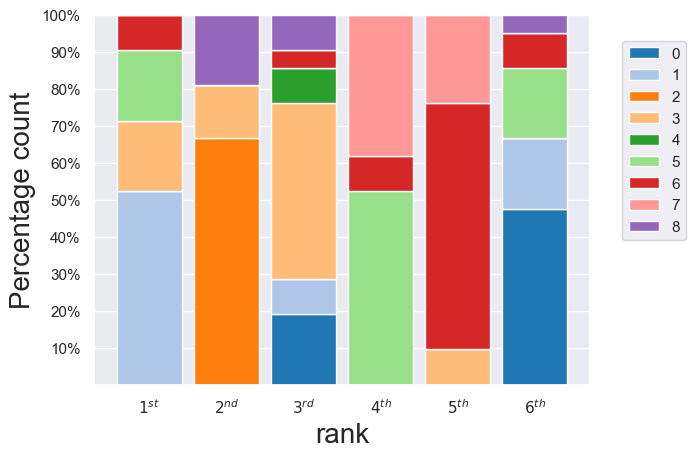

In [95]:
Local_importances = EDIFFI.Local_importances(X_test,True,True)
name = 'Glass'
plt_importances_bars(Local_importances, name, pwd, dim,f=6)

### GFI 

100%|██████████| 10/10 [03:04<00:00, 18.43s/it]


0     1     2     3     4     5     6     7     8
0   0.0   0.0   0.0   0.0  10.0  60.0  20.0  10.0   0.0
1  10.0  10.0   0.0   0.0  10.0  40.0  30.0   0.0   0.0
2  10.0   0.0  10.0   0.0  30.0   0.0  20.0  30.0   0.0
3   0.0  10.0   0.0  30.0  10.0   0.0  20.0  30.0   0.0
4  20.0  20.0   0.0  30.0  20.0   0.0  10.0   0.0   0.0
5  40.0  10.0  20.0   0.0  10.0   0.0   0.0  10.0  10.0
6  10.0  10.0  40.0   0.0   0.0   0.0   0.0  10.0  30.0
7  10.0  10.0  20.0  30.0  10.0   0.0   0.0  10.0  10.0
8   0.0  30.0  10.0  10.0   0.0   0.0   0.0   0.0  50.0

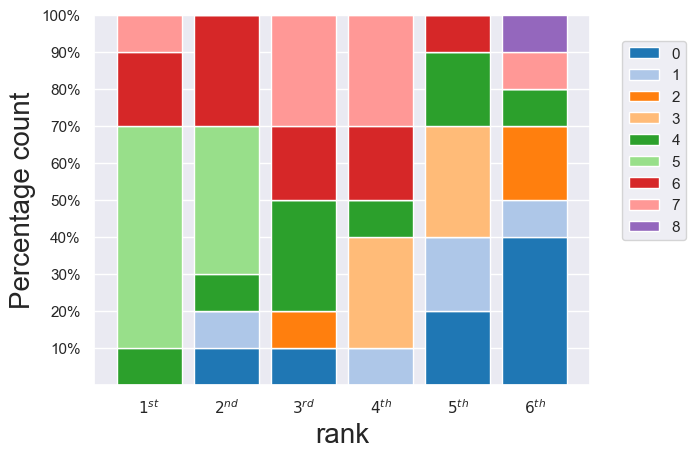

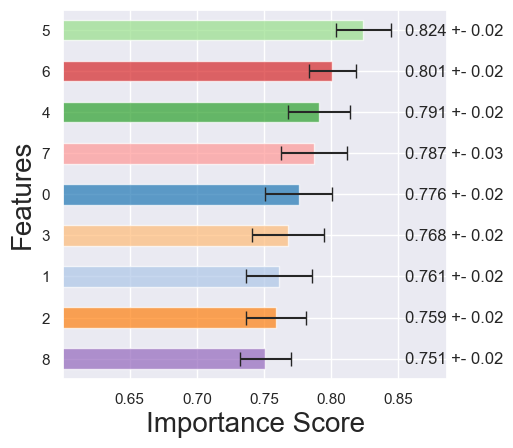

In [96]:
name='Glass'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

## Pendigits

In [127]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
X,y=dataset('pendigits',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

pendigits 

[numero elementi = 6870]
[percentage outliers = 0.022707423580786028]
[number features = 16]
[number outliers = 156]
downsampled to 2500
(2500, 16)


In [128]:
N = X.shape[0]
dim = X.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10
p = sum(y)/len(y)

In [129]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()
pwd = os.getcwd()
dim = X.shape[1]
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size,plus=1)
EDIFFI.fit(X_train)

### LFI 

0          1          2          3          4          5   \
0    0.000000   0.000000   0.000000   7.017544   8.771930   5.263158   
1    0.000000   3.508772   0.000000   7.017544  15.789474  15.789474   
2    1.754386   8.771930   0.000000   8.771930  10.526316   7.017544   
3    7.017544   3.508772   0.000000  10.526316   1.754386   5.263158   
4    0.000000   1.754386   0.000000   7.017544  15.789474   8.771930   
5    0.000000   8.771930   1.754386  12.280702   3.508772   5.263158   
6    3.508772   1.754386   1.754386  10.526316   7.017544   8.771930   
7    3.508772   5.263158   3.508772  10.526316   5.263158   3.508772   
8    3.508772  12.280702   1.754386   7.017544   8.771930   8.771930   
9    5.263158   8.771930   3.508772   0.000000   8.771930  10.526316   
10   8.771930   7.017544  12.280702   7.017544   3.508772   7.017544   
11  17.543860  15.789474   5.263158   1.754386   5.263158   3.508772   
12  12.280702  10.526316  14.035088   5.263158   3.508772   3.508772   
13  14.035088   7.017544  19.298246   3.508772   0.000000   1.754386   
14   5.263158   0.000000  29.824561   0.000000   1.754386   3.508772   
15  17.543860   5.263158   7.017544   1.754386   0.000000   1.754386   

           6          7          8          9          10         11  \
0    0.000000   1.754386  40.350877   0.000000   0.000000   3.508772   
1    0.000000   7.017544   5.263158   1.754386   0.000000   1.754386   
2    5.263158   5.263158  19.298246   0.000000   0.000000   1.754386   
3    3.508772  19.298246   3.508772   5.263158   7.017544  15.789474   
4    0.000000  10.526316   5.263158  10.526316   8.771930  14.035088   
5    3.508772   5.263158   5.263158  15.789474  10.526316  14.035088   
6    3.508772  10.526316   7.017544  14.035088   8.771930   1.754386   
7    7.017544  12.280702   3.508772  10.526316  12.280702   8.771930   
8    7.017544   7.017544   3.508772  10.526316   7.017544   1.754386   
9    7.017544   7.017544   1.754386  14.035088   8.771930   5.263158   
10   1.754386   7.017544   3.508772   8.771930  10.526316   7.017544   
11   7.017544   5.263158   0.000000   3.508772   7.017544   3.508772   
12  10.526316   1.754386   0.000000   1.754386   8.771930   8.771930   
13  19.298246   0.000000   0.000000   0.000000   7.017544   3.508772   
14  21.052632   0.000000   0.000000   3.508772   3.508772   3.508772   
15   3.508772   0.000000   1.754386   0.000000   0.000000   5.263158   

           12         13         14         15  
0    0.000000  17.543860   0.000000  15.789474  
1    3.508772  26.315789   0.000000  12.280702  
2    8.771930   8.771930   0.000000  14.035088  
3    1.754386   5.263158   0.000000  10.526316  
4    8.771930   8.771930   0.000000   0.000000  
5    3.508772  10.526316   0.000000   0.000000  
6    3.508772   5.263158   0.000000  12.280702  
7    8.771930   3.508772   0.000000   1.754386  
8   10.526316   1.754386   0.000000   8.771930  
9    7.017544   3.508772   1.754386   7.017544  
10  12.280702   0.000000   1.754386   1.754386  
11  15.789474   1.754386   1.754386   5.263158  
12   7.017544   3.508772   3.508772   5.263158  
13   5.263158   0.000000  14.035088   5.263158  
14   1.754386   1.754386  24.561404   0.000000  
15   1.754386   1.754386  52.631579   0.000000

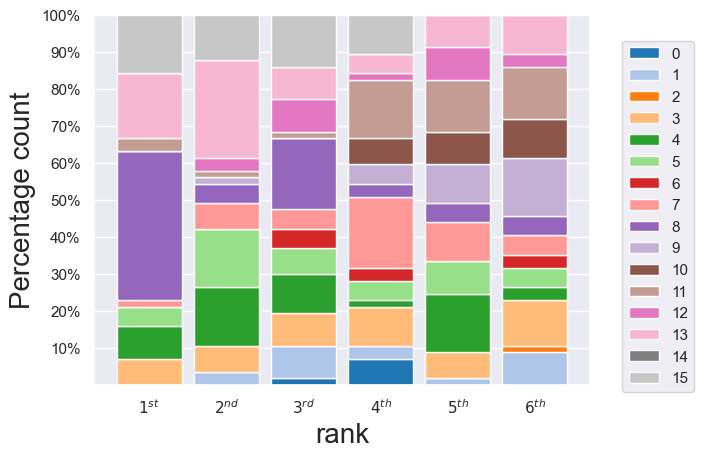

In [130]:
Local_importances = EDIFFI.Local_importances(X_test,True,True)
name = 'pendigits'
plt_importances_bars(Local_importances, name, pwd, dim,f=6)

### GFI 

100%|██████████| 10/10 [17:44<00:00, 106.41s/it]


0     1     2     3     4     5     6     7     8     9     10    11  \
0    0.0  20.0   0.0  20.0   0.0  40.0   0.0   0.0   0.0   0.0   0.0  10.0   
1    0.0  20.0   0.0  40.0   0.0  10.0   0.0   0.0  10.0   0.0   0.0   0.0   
2    0.0  10.0  10.0  20.0   0.0  10.0  10.0  20.0  10.0   0.0   0.0   0.0   
3    0.0  20.0  10.0   0.0   0.0  10.0  10.0  10.0   0.0   0.0   0.0  20.0   
4    0.0  20.0   0.0  10.0  10.0  20.0   0.0  10.0   0.0   0.0   0.0  20.0   
5    0.0   0.0  10.0  10.0   0.0   0.0   0.0  10.0  10.0  10.0   0.0   0.0   
6    0.0   0.0  10.0   0.0   0.0   0.0   0.0  10.0   0.0   0.0   0.0  10.0   
7    0.0   0.0  10.0   0.0   0.0   0.0  10.0  10.0  10.0  20.0   0.0  20.0   
8    0.0   0.0  10.0   0.0  10.0   0.0   0.0   0.0   0.0  10.0  20.0  20.0   
9   20.0   0.0  10.0   0.0  20.0  10.0   0.0  10.0  20.0   0.0   0.0   0.0   
10   0.0  10.0   0.0   0.0   0.0   0.0  10.0  10.0  10.0  10.0  30.0   0.0   
11  10.0   0.0  10.0   0.0   0.0   0.0  10.0  10.0  10.0   0.0  10.0   0.0   
12   0.0   0.0  10.0   0.0  30.0   0.0   0.0   0.0  10.0  10.0  20.0   0.0   
13  10.0   0.0  10.0   0.0  20.0   0.0  30.0   0.0   0.0   0.0  10.0   0.0   
14  20.0   0.0   0.0   0.0  10.0   0.0  10.0   0.0   0.0  10.0  10.0   0.0   
15  40.0   0.0   0.0   0.0   0.0   0.0  10.0   0.0  10.0  30.0   0.0   0.0   

      12    13    14    15  
0    0.0  10.0   0.0   0.0  
1    0.0  10.0   0.0  10.0  
2    0.0   0.0   0.0  10.0  
3    0.0   0.0   0.0  20.0  
4    0.0  10.0   0.0   0.0  
5    0.0  30.0  10.0  10.0  
6   20.0  20.0  10.0  20.0  
7   10.0  10.0   0.0   0.0  
8    0.0   0.0  20.0  10.0  
9    0.0   0.0  10.0   0.0  
10   0.0  10.0   0.0  10.0  
11  40.0   0.0   0.0   0.0  
12  10.0   0.0  10.0   0.0  
13   0.0   0.0  20.0   0.0  
14  20.0   0.0  10.0  10.0  
15   0.0   0.0  10.0   0.0

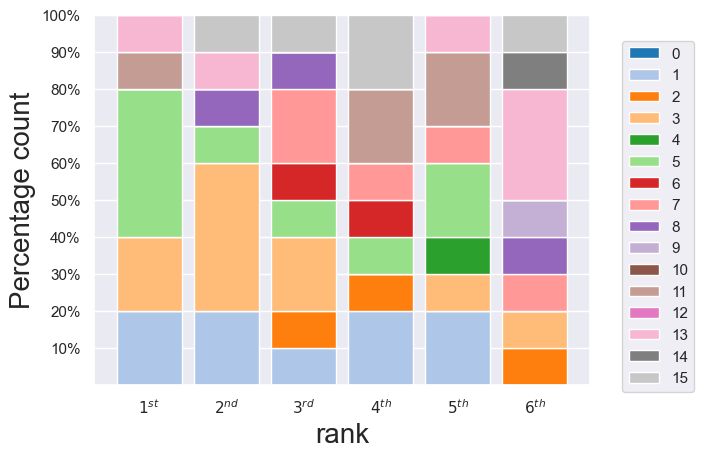

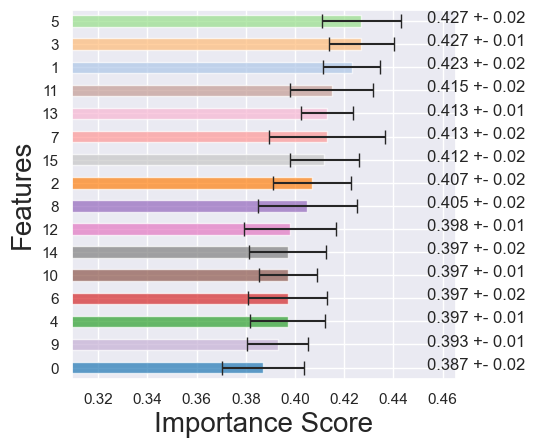

In [131]:
name='pendigits'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

## Shuttle

In [132]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
X,y=dataset('shuttle',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

shuttle 

[numero elementi = 49097]
[percentage outliers = 0.0715114976475141]
[number features = 9]
[number outliers = 3511]
downsampled to 2500
(2500, 9)


In [133]:
N = X.shape[0]
dim = X.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10
p = sum(y)/len(y)

In [134]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()
pwd = os.getcwd()
dim = X.shape[1]
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size,plus=1)
EDIFFI.fit(X_train)

### LFI 

0          1          2          3          4          5  \
0   3.351955   5.027933  37.430168   3.351955   0.000000   0.000000   
1  24.022346   0.558659  20.670391   6.703911   1.117318   0.558659   
2   4.469274   0.000000  11.731844  17.318436  32.960894   0.000000   
3  13.966480   0.000000   0.558659  15.642458  41.340782   1.675978   
4  24.022346   3.351955   1.675978  35.754190  13.407821   6.703911   
5  24.581006  15.083799   8.379888  18.435754   6.703911   7.262570   
6   3.910615   8.938547  10.055866   2.234637   2.793296  37.430168   
7   1.675978  12.290503   8.938547   0.558659   1.675978  45.251397   
8   0.000000  54.748603   0.558659   0.000000   0.000000   1.117318   

           6          7          8  
0  34.078212   0.000000  16.759777  
1  14.525140   0.000000  31.843575  
2  11.731844   3.910615  17.877095  
3   1.675978  22.905028   2.234637  
4  11.173184   3.910615   0.000000  
5   8.938547   8.938547   1.675978  
6   9.497207  24.022346   1.117318  
7   8.379888  21.229050   0.000000  
8   0.000000  15.083799  28.491620

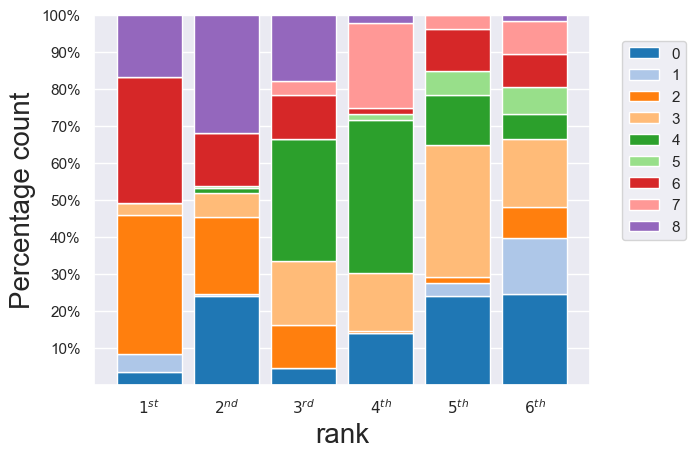

In [135]:
Local_importances = EDIFFI.Local_importances(X_test,True,True)
name = 'shuttle'
plt_importances_bars(Local_importances, name, pwd, dim,f=6)

### GFI 

100%|██████████| 10/10 [16:56<00:00, 101.67s/it]


0     1     2     3     4     5     6     7     8
0  90.0   0.0   0.0   0.0   0.0   0.0  10.0   0.0   0.0
1   0.0  20.0  40.0   0.0   0.0   0.0  10.0  10.0  20.0
2   0.0  20.0  10.0  10.0  10.0   0.0  20.0  10.0  20.0
3  10.0  10.0   0.0  20.0  20.0  10.0  10.0  10.0  10.0
4   0.0   0.0   0.0  20.0   0.0  30.0  30.0  10.0  10.0
5   0.0  20.0  10.0  20.0  10.0  20.0  10.0  10.0   0.0
6   0.0  10.0   0.0   0.0   0.0  20.0  10.0  40.0  20.0
7   0.0   0.0  20.0  20.0  20.0  20.0   0.0   0.0  20.0
8   0.0  20.0  20.0  10.0  40.0   0.0   0.0  10.0   0.0

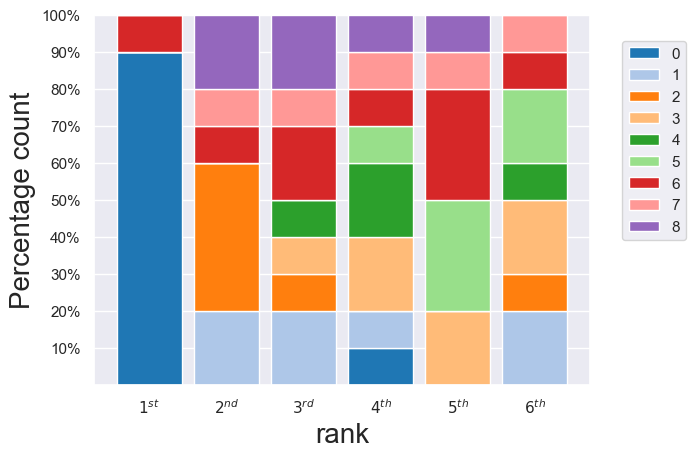

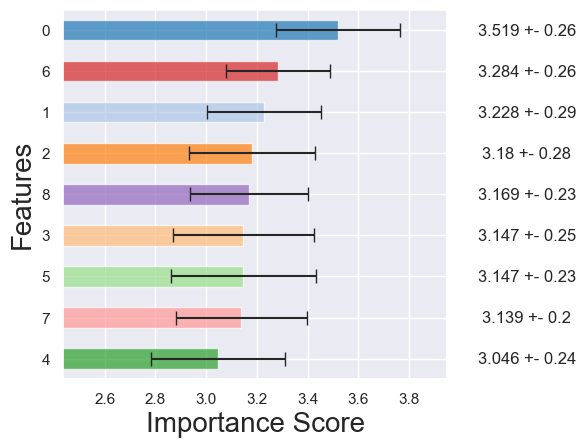

In [136]:
name='shuttle'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

# New Datasets 

In [31]:
def csv_dataset(name, path = "../data/"):
    datapath = path + name + ".csv"
    data=pd.read_csv(datapath,index_col=0)
    if 'Unnamed: 0' in data.columns:
        data=data.drop(columns=['Unnamed: 0'])
    
    X=data[data.columns[data.columns!='Target']]
    y=data['Target']
    
    X,y = drop_duplicates(X,y)
    print(name, "\n")
    print_dataset_resume(X,y)
    
    return X,y

## Diabetes 

In [137]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
X,y=csv_dataset('diabetes',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

diabetes 

[numero elementi = 85916]
[percentage outliers = 0.096582708692211]
[number features = 4]
[number outliers = 8298]
downsampled to 2500
(2500, 4)


In [138]:
N = X.shape[0]
dim = X.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10
p = sum(y)/len(y)
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()
pwd = os.getcwd()
dim = X.shape[1]
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size,plus=1)
EDIFFI.fit(X_train)

### LFI 

0          1          2          3
0  12.863071  14.937759  36.514523  35.684647
1  24.481328  31.120332  23.651452  20.746888
2  39.834025  20.331950  21.161826  18.672199
3  22.821577  33.609959  18.672199  24.896266

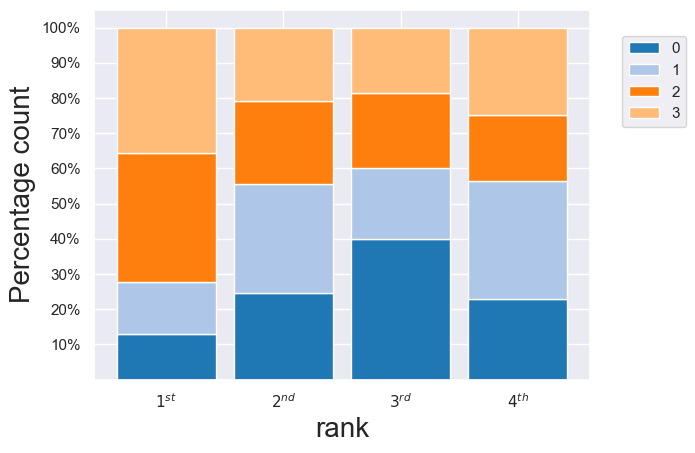

In [139]:
Local_importances = EDIFFI.Local_importances(X_test,True,True)
name = 'diabetes'
plt_importances_bars(Local_importances, name, pwd, dim,f=dim)

### GFI 

100%|██████████| 10/10 [15:05<00:00, 90.59s/it]


0     1     2     3
0   0.0   0.0  40.0  60.0
1   0.0   0.0  60.0  40.0
2  10.0  90.0   0.0   0.0
3  90.0  10.0   0.0   0.0

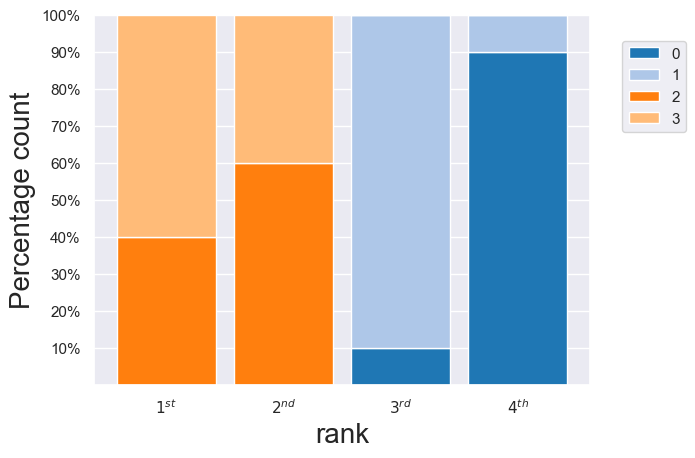

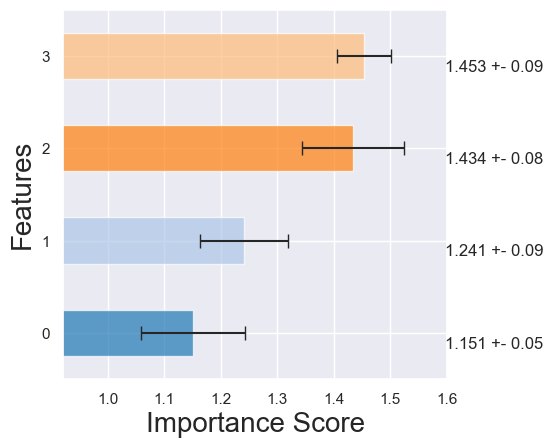

In [140]:
name='diabetes'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim,f=dim)

## Moodify

In [87]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
X,y=csv_dataset('moodify',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

moodify 

[numero elementi = 276260]
[percentage outliers = 0.1527112140736987]
[number features = 11]
[number outliers = 42188]
downsampled to 2500
(2500, 11)


In [88]:
N = X.shape[0]
dim = X.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10
p = sum(y)/len(y)
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()
pwd = os.getcwd()
dim = X.shape[1]
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size,plus=1)
EDIFFI.fit(X_train)

### LFI

0          1          2          3          4          5   \
0    1.832461   9.424084   0.000000  41.623037   0.261780  12.827225   
1    4.188482   6.544503   1.570681  10.471204   2.356021  34.816754   
2    4.450262   9.947644   2.617801   8.115183   4.973822  16.753927   
3    7.853403  14.136126   3.403141   7.329843   8.900524  13.350785   
4    8.638743   9.685864   6.544503   6.020942  14.136126   8.115183   
5   12.041885  10.209424   8.376963   8.376963  24.083770   3.664921   
6   14.659686  11.256545  11.780105   6.544503  13.874346   1.832461   
7   14.921466  12.041885  15.968586   3.664921  10.994764   2.617801   
8   12.827225   4.450262  21.989529   4.712042   8.900524   2.879581   
9   10.732984   6.020942  15.968586   1.570681   8.376963   1.570681   
10   7.853403   6.282723  11.780105   1.570681   3.141361   1.570681   

           6          7          8          9          10  
0   25.916230   2.094241   0.523560   1.570681   3.926702  
1   20.418848   1.308901   2.094241   2.617801  13.612565  
2   13.612565   1.832461   6.282723   2.356021  29.057592  
3   12.041885   1.832461   7.329843   3.926702  19.895288  
4   14.921466   4.450262  10.471204   3.403141  13.612565  
5    5.497382   4.973822  10.732984   4.188482   7.853403  
6    3.403141   5.759162  15.706806   9.162304   6.020942  
7    2.617801   8.638743  15.706806   9.685864   3.141361  
8    0.785340  15.445026   9.685864  16.230366   2.094241  
9    0.261780  18.848168  13.089005  23.036649   0.523560  
10   0.523560  34.816754   8.376963  23.821990   0.261780

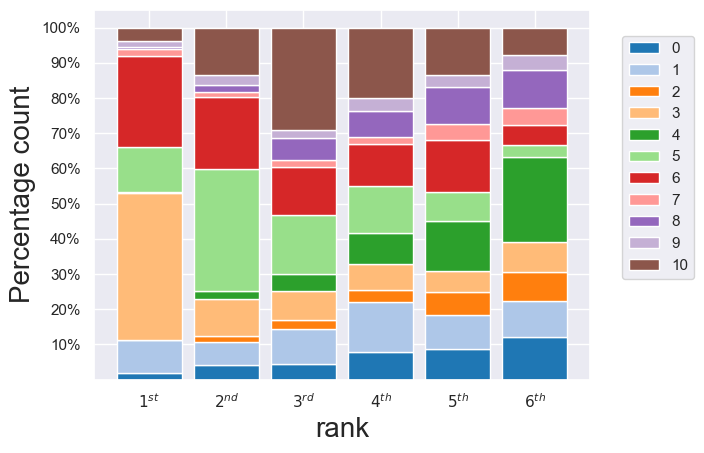

In [89]:
Local_importances = EDIFFI.Local_importances(X_test,True,True)
name = 'moodify'
plt_importances_bars(Local_importances, name, pwd, dim,f=6)

### GFI

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [15:34<00:00, 93.48s/it]


0     1     2      3     4     5     6     7     8     9     10
0    0.0   0.0   0.0  100.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
1   10.0   0.0  20.0    0.0  10.0  20.0  30.0   0.0   0.0   0.0  10.0
2    0.0   0.0  20.0    0.0  30.0   0.0  10.0   0.0  10.0  10.0  20.0
3   20.0   0.0  20.0    0.0  10.0   0.0  10.0  10.0   0.0   0.0  30.0
4    0.0  10.0   0.0    0.0  30.0   0.0  20.0   0.0   0.0  10.0  30.0
5   30.0   0.0  10.0    0.0   0.0  20.0  20.0   0.0  20.0   0.0   0.0
6   20.0  10.0   0.0    0.0   0.0  10.0   0.0  20.0  20.0  10.0  10.0
7   10.0  30.0  10.0    0.0   0.0  10.0   0.0  20.0   0.0  20.0   0.0
8   10.0  20.0  10.0    0.0  10.0  20.0   0.0  10.0   0.0  20.0   0.0
9    0.0  30.0  10.0    0.0   0.0  10.0  10.0  10.0  20.0  10.0   0.0
10   0.0   0.0   0.0    0.0  10.0  10.0   0.0  30.0  30.0  20.0   0.0

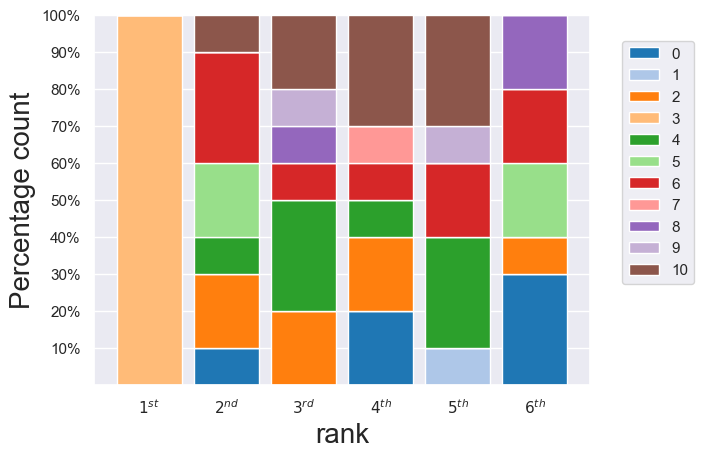

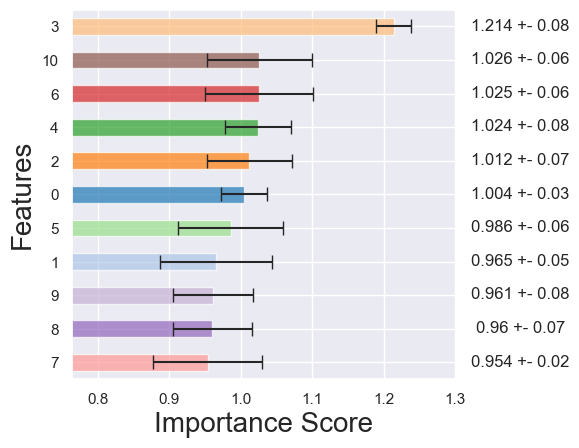

In [90]:
name='moodify'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

## Bearings 

### Bearings 1

In [33]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
X,y=csv_dataset('bearings_1',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

bearings_1 

[numero elementi = 2156]
[percentage outliers = 0.09972170686456401]
[number features = 8]
[number outliers = 215]


In [34]:
N = X.shape[0]
dim = X.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10
p = sum(y)/len(y)
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()
pwd = os.getcwd()
dim = X.shape[1]
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size)
EDIFFI.fit(X_train)

### LFI 

0          1          2          3          4          5  \
0   4.186047   3.255814  19.534884   0.930233   2.325581   3.255814   
1   9.302326   6.046512  20.465116   5.581395  14.418605   4.651163   
2  16.744186   5.581395  28.372093  12.558140  12.093023   5.116279   
3  10.697674  11.162791  10.697674  30.697674   7.441860  14.883721   
4   9.302326  13.953488   8.372093  17.674419   9.302326  26.511628   
5  27.906977  17.209302   3.255814  14.883721  10.697674  15.813953   
6  10.697674  14.883721   6.046512  10.232558  26.046512  20.000000   
7  11.162791  27.906977   3.255814   7.441860  17.674419   9.767442   

           6          7  
0  26.976744  39.534884  
1  29.767442   9.767442  
2  14.418605   5.116279  
3   8.372093   6.046512  
4   4.651163  10.232558  
5   4.186047   6.046512  
6   5.116279   6.976744  
7   6.511628  16.279070

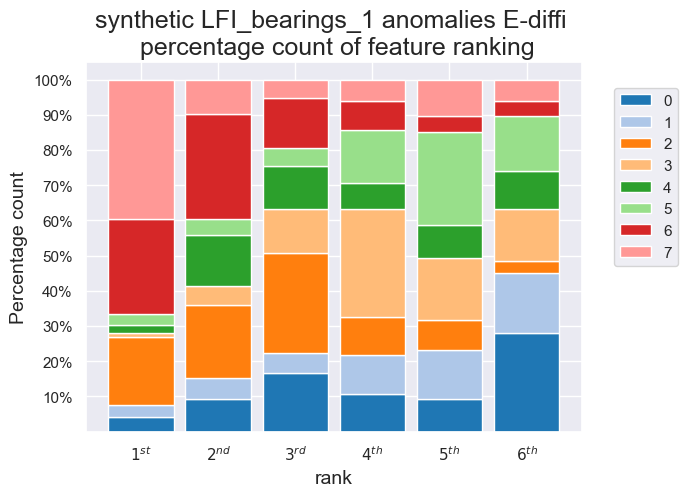

In [35]:
Local_importances = EDIFFI.Local_importances(X_test,True,True)
name = 'bearings_1'
plt_importances_bars(Local_importances, name, pwd, dim,f=6)

### GFI 

100%|██████████| 10/10 [14:36<00:00, 87.65s/it]


0     1     2     3     4     5     6     7
0   0.0   0.0   0.0   0.0   0.0  20.0  20.0  60.0
1  10.0  20.0  20.0   0.0  10.0  30.0   0.0  10.0
2   0.0  10.0  10.0  10.0  20.0   0.0  30.0  20.0
3  30.0  20.0  10.0   0.0   0.0  10.0  20.0  10.0
4  10.0   0.0  20.0  40.0  20.0  10.0   0.0   0.0
5   0.0  10.0  10.0  40.0  10.0  20.0  10.0   0.0
6  10.0  40.0   0.0   0.0  40.0   0.0  10.0   0.0
7  40.0   0.0  30.0  10.0   0.0  10.0  10.0   0.0

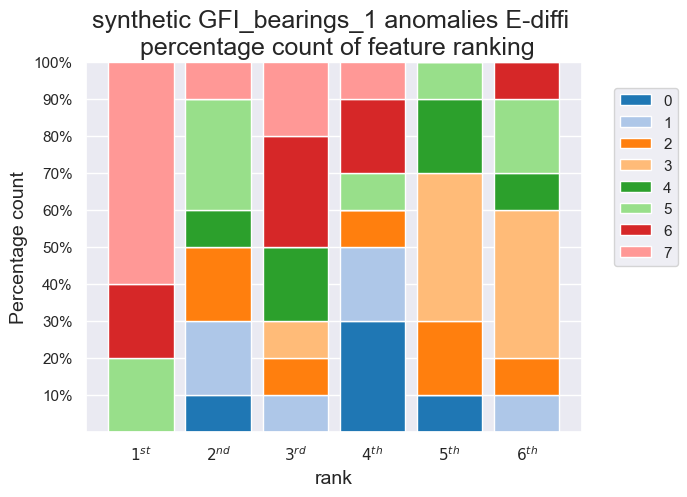

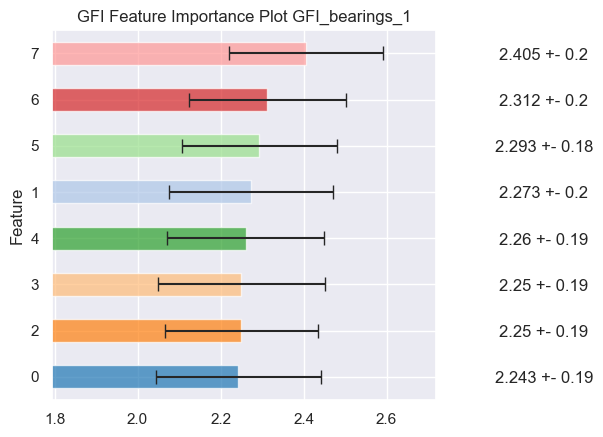

In [36]:
name='bearings_1'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

### Bearings 2

In [37]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
X,y=csv_dataset('bearings_2',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

bearings_2 

[numero elementi = 984]
[percentage outliers = 0.09959349593495935]
[number features = 4]
[number outliers = 98]


In [38]:
N = X.shape[0]
dim = X.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10
p = sum(y)/len(y)
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()
pwd = os.getcwd()
dim = X.shape[1]
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size)
EDIFFI.fit(X_train)

### LFI 

0          1          2          3
0   8.163265  14.285714  20.408163  57.142857
1  24.489796  41.836735  24.489796   9.183673
2  24.489796  35.714286  25.510204  14.285714
3  42.857143   8.163265  29.591837  19.387755

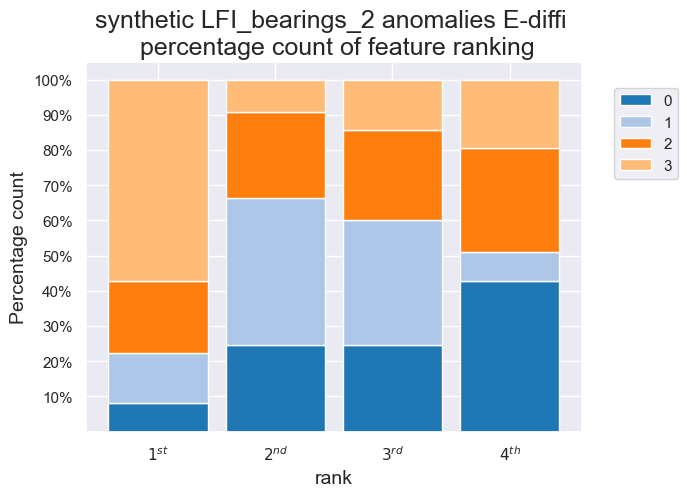

In [41]:
Local_importances = EDIFFI.Local_importances(X_test,True,True)
name = 'bearings_2'
plt_importances_bars(Local_importances, name, pwd, dim,f=dim)

### GFI 

100%|██████████| 10/10 [06:42<00:00, 40.30s/it]


0     1     2     3
0   0.0  10.0  50.0  40.0
1  30.0  20.0  20.0  30.0
2  40.0  20.0  20.0  20.0
3  30.0  50.0  10.0  10.0

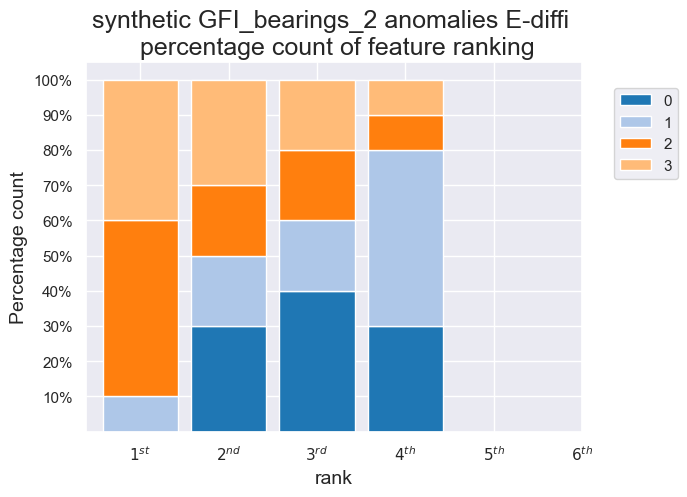

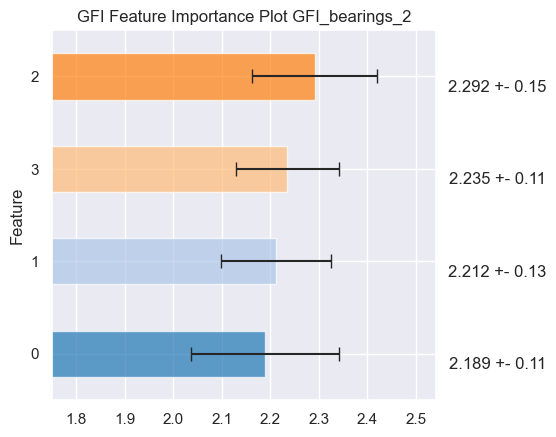

In [42]:
name='bearings_2'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

### Bearings 3

In [ ]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
X,y=csv_dataset('bearings_3',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
N = X.shape[0]
dim = X.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10
p = sum(y)/len(y)
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()
pwd = os.getcwd()
dim = X.shape[1]
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size)
EDIFFI.fit(X_train)

### LFI 

In [ ]:
Local_importances = EDIFFI.Local_importances(X_test,True,True)
name = 'bearings_3'
plt_importances_bars(Local_importances, name, pwd, dim,f=6)

### GFI 

In [ ]:
name='bearings_3'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

## PROVE

In [39]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
X,y=dataset('wine',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
#scaler=StandardScaler()
#X_train=scaler.fit_transform(X_train)
#X_test=scaler.transform(X_test)

wine 

[numero elementi = 129]
[percentage outliers = 0.07751937984496124]
[number features = 13]
[number outliers = 10]


In [40]:
N = X.shape[0]
dim = X.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10
p = sum(y)/len(y)
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()
pwd = os.getcwd()
dim = X.shape[1]
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size,plus=0)
EDIFFI.fit(X_train)

GFI Score with plus=1 and Scaler 

In [32]:
X_test=np.r_[X_train,X_test]
imps=EDIFFI.Global_importance(X_test,calculate=True,sovrascrivi=False,depth_based=False)
imps

array([0.68520356, 0.64128899, 0.73635986, 0.68392698, 0.68037575,
       0.71727302, 0.7029616 , 0.58820539, 0.67655142, 0.66855808,
       0.74124701, 0.74901589, 1.03692103])

Random Values

In [34]:
X_rand=np.random.uniform(1500,2500,size=(129,dim))
imps=EDIFFI.Global_importance(X_rand,calculate=True,sovrascrivi=False,depth_based=False)
imps

array([0.05923061, 0.05258886, 0.05429499, 0.0525192 , 0.04360988,
       0.06321155, 0.04239972, 0.04770738, 0.05315583, 0.05372794,
       0.04470846, 0.04681034, 0.05190778])

GFI Score with plus=1 and NO Scaler 

The importance score values are higher if we do not insert the Scaler. 

In [12]:
X_test=np.r_[X_train,X_test]
imps=EDIFFI.Global_importance(X_test,calculate=True,sovrascrivi=False,depth_based=False)
imps

array([3.15379121, 3.20973608, 3.22702473, 2.79005389, 3.43974482,
       2.75870432, 3.30355683, 3.10140449, 3.07844019, 3.36322665,
       3.26868718, 3.24053344, 3.28257603])

It is interesting to see what happens if we compute the Importance Scores on other points. Looking at the Scoremaps without the Scaler the Importance Score stays more or less constant (in fact there is not a change in the red/blue shape). So if I generate random points then the scores should have similar values. 

In [28]:
X_train,X_test=partition_data(X,y)
X_test.shape

(10, 13)

In [29]:
X_rand=np.random.uniform(0.15,1500,size=(129,dim))
imps=EDIFFI.Global_importance(X_test,calculate=True,sovrascrivi=False,depth_based=False)
imps

array([0.51052855, 0.46564717, 0.54960418, 0.40427923, 0.55885622,
       0.52834038, 0.57763535, 0.43137087, 0.54805678, 0.47254631,
       0.50034003, 0.51287994, 0.4664693 ])

GFI Score with plus=0 and Scaler 

In [37]:
X_test=np.r_[X_train,X_test]
imps=EDIFFI.Global_importance(X_test,calculate=True,sovrascrivi=False,depth_based=False)
imps

array([0.71192352, 0.70677382, 0.73527445, 0.69934999, 0.72393817,
       0.7352093 , 0.73725678, 0.71385623, 0.73095732, 0.6944313 ,
       0.7185488 , 0.72533455, 0.82058389])

Random Values

In [38]:
X_rand=np.random.uniform(0.15,1500,size=(129,dim))
imps=EDIFFI.Global_importance(X_rand,calculate=True,sovrascrivi=False,depth_based=False)
imps

array([0.09239824, 0.07689633, 0.1112633 , 0.09964015, 0.10725256,
       0.08368065, 0.1206964 , 0.11271365, 0.07402431, 0.09599919,
       0.11193672, 0.07975722, 0.10820809])

GFI Score with plus=0 and NO Scaler

In [41]:
X_test=np.r_[X_train,X_test]
imps=EDIFFI.Global_importance(X_test,calculate=True,sovrascrivi=False,depth_based=False)
imps

array([2.49721394, 3.08081312, 2.76327245, 2.83400918, 2.42706622,
       2.45031725, 2.40881619, 2.45116899, 2.84233704, 2.60369613,
       2.53594066, 2.57151409, 3.06530647])

Random Values

In [42]:
X_rand=np.random.uniform(0.15,1500,size=(129,dim))
imps=EDIFFI.Global_importance(X_rand,calculate=True,sovrascrivi=False,depth_based=False)
imps

array([0.08493202, 0.1085494 , 0.08545275, 0.09122123, 0.07446581,
       0.07706884, 0.08061371, 0.04568945, 0.08788516, 0.06301421,
       0.06888591, 0.10839917, 0.1011137 ])